<a href="https://colab.research.google.com/github/Mojtaba1996-glitch/Stock-Price-Forecasting-Traditional-vs.-Deep-Learning-Models/blob/main/FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [ ]:
pip install --upgrade yfinance


In [ ]:
# Data collection block
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']
start_date = '2017-12-08'
end_date = '2023-12-30'
df = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
df = df.resample('W-FRI').last()
df.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']
df.index = pd.to_datetime(df.index.date)

[*********************100%***********************]  9 of 9 completed


In [ ]:
df

ADVANC          BH        EGCO       GULF     INTUCH  \
2017-12-08  136.462524  175.947495  170.262924  10.030399  39.609108   
2017-12-15  142.612961  171.592361  169.485474   9.892996  39.609108   
2017-12-22  142.997330  169.414780  173.372726  10.213602  39.969189   
2017-12-29  146.841354  164.624130  167.930557  11.908237  40.509315   
2018-01-05  149.916595  167.672729  167.930557  12.595249  41.409519   
...                ...         ...         ...        ...        ...   
2023-12-01  209.930481  216.196136  120.347847  44.600224  67.220261   
2023-12-08  210.889069  209.348297  118.926414  44.600224  66.505157   
2023-12-15  210.889069  213.261353  117.978790  45.580448  66.743523   
2023-12-22  211.847641  211.304825  120.347847  43.865055  67.697006   
2023-12-29  208.013306  217.174393  121.295464  43.619999  68.173737   

                 PTTEP      PTTGC        TOP         TU  
2017-12-08   65.345451  64.348122  72.496758  14.680014  
2017-12-15   66.044327  65.326057  74.870689  14.529450  
2017-12-22   69.713448  66.695175  73.775024  14.454167  
2017-12-29   69.888168  66.499588  75.601135  14.981145  
2018-01-05   74.780350  70.606911  78.157707  15.658680  
...                ...        ...        ...        ...  
2023-12-01  139.151657  37.754841  47.709446  14.260377  
2023-12-08  133.060852  38.000000  47.476715  14.549439  
2023-12-15  137.746094  38.490322  49.338547  14.453085  
2023-12-22  138.214600  37.754841  50.036736  13.874961  
2023-12-29  140.088699  37.754841  50.036736  14.453085  

[317 rows x 9 columns]

In [ ]:

# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define ARIMA parameters for each stock
arima_params = {
    'ADVANC': (3, 1, 2),
    'BH': (3, 1, 2),
    'EGCO': (3, 1, 2),
    'GULF': (6, 1, 0), #310
    'INTUCH': (0, 1, 1),
    'PTTEP': (3, 1, 1),
    'PTTGC': (4, 1, 3),
    'TOP': (3, 1, 3), #310
    'TU': (0, 1, 0)
}

# Data collection block
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']
start_date = '2017-12-08'
end_date = '2023-12-30'
df = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
df = df.resample('W-FRI').last()
df.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']
df.index = pd.to_datetime(df.index.date)

def forecast_stocks_arima(data, arima_params, forecast_horizon=1):           #    forecasts, directions = forecast_stocks_arima(full_train_data, arima_params)

    forecasted_prices = {}
    directions = {}

    for column in data.columns:
        p, d, q = arima_params[column]

        model = ARIMA(data[column], order=(p, d, q))
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=forecast_horizon)[0]
        last_actual_price = data[column].iloc[-1]

        forecasted_prices[column] = forecast
        direction = 1 if forecast > last_actual_price else -1
        directions[column] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

# Initialize variables
initial_train_end = '2022-09-30'
full_train_data = df[df.index <= initial_train_end]
test_data = df[(df.index > initial_train_end) & (df.index <= '2022-12-31')]

# Initialize prediction DataFrames
predicted_prices = pd.DataFrame(index=test_data.index, columns=df.columns)
predicted_directions = pd.DataFrame(index=test_data.index, columns=df.columns)
windowz_size = 252
full_train_data = full_train_data.iloc[-windowz_size:]

print("Starting forecasting loop...")
# Loop over each week in the test set
for i in range(len(test_data)):
    test_week = test_data.iloc[i:i+1]
    current_date = test_data.index[i]

    print(f"Processing week {i+1}/{len(test_data)}: {current_date}")

    forecasts, directions = forecast_stocks_arima(full_train_data, arima_params)

    predicted_prices.loc[current_date] = forecasts   #first output
    predicted_directions.loc[current_date] = directions #second output

    full_train_data = pd.concat([full_train_data, test_week])
    full_train_data = full_train_data.iloc[-windowz_size:]  # Maintain window


[*********************100%***********************]  9 of 9 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Starting forecasting loop...
Processing week 1/13: 2022-10-07 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
<ipython-input-21-a4b881e5c569>:42: FutureWarning: Seri

Processing week 2/13: 2022-10-14 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/bas

Processing week 3/13: 2022-10-21 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/bas

Processing week 4/13: 2022-10-28 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/bas

Processing week 5/13: 2022-11-04 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
<ipython-input-21-a4b881e5c569>:42: FutureWarning: Seri

Processing week 6/13: 2022-11-11 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
<ipython-input-21-a4b881e5c569>:42: FutureWarning: Seri

Processing week 7/13: 2022-11-18 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

Processing week 8/13: 2022-11-25 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

Processing week 9/13: 2022-12-02 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
<ipython-input-21-a4b881e5c569>:42: FutureWarning: Seri

Processing week 10/13: 2022-12-09 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

Processing week 11/13: 2022-12-16 00:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

Processing week 12/13: 2022-12-23 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

Processing week 13/13: 2022-12-30 00:00:00


<ipython-input-21-a4b881e5c569>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=forecast_horizon)[0]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa

In [ ]:
predicted_directions

ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2022-10-07     -1   1   -1   -1      1     1    -1   1  -1
2022-10-14     -1   1    1    1     -1    -1    -1  -1  -1
2022-10-21      1   1   -1   -1     -1     1     1  -1  -1
2022-10-28      1  -1    1   -1      1    -1    -1  -1  -1
2022-11-04     -1  -1   -1    1      1    -1     1  -1  -1
2022-11-11      1   1    1    1     -1    -1     1  -1  -1
2022-11-18     -1   1   -1   -1      1     1     1   1  -1
2022-11-25      1   1    1    1      1     1    -1   1  -1
2022-12-02     -1  -1    1   -1     -1    -1     1  -1  -1
2022-12-09      1   1   -1   -1      1     1    -1   1  -1
2022-12-16     -1   1    1    1      1     1    -1   1  -1
2022-12-23      1   1   -1   -1      1    -1     1   1  -1
2022-12-30      1  -1    1    1     -1     1    -1  -1  -1

#ARIMA (included in my thesis)

In [ ]:

# Combine the predicted prices and actual prices
combined_prices = pd.concat([predicted_prices, test_data], axis=1)
combined_prices.columns = [f'Predicted_{col}' if i < len(predicted_prices.columns) else f'Actual_{col}'
                           for i, col in enumerate(combined_prices.columns)]

combined_prices

#-------------------------------------------------------------------------------
def selectted_stocks(predicted_directions):
  selected_stocks={}
  for i in range(len(predicted_directions)):
    date_str = predicted_directions.index[i].strftime('%Y-%m-%d')
    selected_stocks[date_str] = predicted_directions.iloc[i][predicted_directions.iloc[i]==1].index.tolist()

  return selected_stocks

selected_stocks_arima=selectted_stocks(predicted_directions)
selected_stocks_arima


#------------------------------------------------------------------------------

#overall i expect to have  "predicted_prices", "predicted_directions", "combined_prices", selected_stocks_arima"

{'2022-10-07': ['BH', 'INTUCH', 'PTTEP', 'TOP'],
 '2022-10-14': ['BH', 'EGCO', 'GULF'],
 '2022-10-21': ['ADVANC', 'BH', 'PTTEP', 'PTTGC'],
 '2022-10-28': ['ADVANC', 'EGCO', 'INTUCH'],
 '2022-11-04': ['GULF', 'INTUCH', 'PTTGC'],
 '2022-11-11': ['ADVANC', 'BH', 'EGCO', 'GULF', 'PTTGC'],
 '2022-11-18': ['BH', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-25': ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'TOP'],
 '2022-12-02': ['EGCO', 'PTTGC'],
 '2022-12-09': ['ADVANC', 'BH', 'INTUCH', 'PTTEP', 'TOP'],
 '2022-12-16': ['BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'TOP'],
 '2022-12-23': ['ADVANC', 'BH', 'INTUCH', 'PTTGC', 'TOP'],
 '2022-12-30': ['ADVANC', 'EGCO', 'GULF', 'PTTEP']}

In [ ]:
full_train_data2

ADVANC          BH        EGCO       GULF     INTUCH  \
2017-12-08  136.462524  175.947495  170.262924  10.030399  39.609108   
2017-12-15  142.612961  171.592361  169.485474   9.892996  39.609108   
2017-12-22  142.997330  169.414780  173.372726  10.213602  39.969189   
2017-12-29  146.841354  164.624130  167.930557  11.908237  40.509315   
2018-01-05  149.916595  167.672729  167.930557  12.595249  41.409519   
...                ...         ...         ...        ...        ...   
2022-09-02  176.636765  208.868378  162.315033  49.904640  64.498825   
2022-09-09  177.559128  215.606064  162.096725  54.749752  66.521423   
2022-09-16  178.020325  210.793442  155.757751  52.327198  64.948288   
2022-09-23  178.020325  216.568588  156.210526  51.600430  64.049347   
2022-09-30  179.865097  218.493637  149.418762  50.873665  65.397751   

                 PTTEP      PTTGC        TOP         TU  
2017-12-08   65.345451  64.348122  72.496758  14.680014  
2017-12-15   66.044327  65.326057  74.870689  14.529450  
2017-12-22   69.713448  66.695175  73.775024  14.454167  
2017-12-29   69.888168  66.499588  75.601135  14.981145  
2018-01-05   74.780350  70.606911  78.157707  15.658680  
...                ...        ...        ...        ...  
2022-09-02  147.417297  44.140644  50.485733  15.942031  
2022-09-09  144.318436  43.652905  48.337406  15.575547  
2022-09-16  147.417297  43.652905  46.833572  15.209064  
2022-09-23  150.958832  42.189678  47.048409  15.942031  
2022-09-30  142.104950  40.482582  44.040749  17.133102  

[252 rows x 9 columns]

In [ ]:
last_train_week

ADVANC          BH        EGCO       GULF     INTUCH  \
2022-09-30  179.865097  218.493637  149.418762  50.873665  65.397751   

                PTTEP      PTTGC        TOP         TU  
2022-09-30  142.10495  40.482582  44.040749  17.133102

In [ ]:

full_train_data2 = df[df.index <= initial_train_end]  # Training data

# Get the last row of the training data to compare with the first week of test data
last_train_week = full_train_data2.iloc[-1:]

# Combine the last train week with the test data
full_data_for_direction = pd.concat([last_train_week, test_data])

actual_directions = (full_data_for_direction.diff() > 0).astype(int).replace(0, -1)

# Since we concatenated, the first row will be NaN (no previous value to compare), so we drop it
actual_directions = actual_directions.iloc[1:]

print("Actual Market Directions:")
print(actual_directions)
print("Predicted Market Directions:")
print(predicted_directions)

Actual Market Directions:
            ADVANC  BH  EGCO  GULF  INTUCH  PTTEP  PTTGC  TOP  TU
2022-10-07      -1   1    -1    -1      -1      1     -1    1  -1
2022-10-14      -1  -1     1    -1      -1     -1     -1   -1  -1
2022-10-21       1  -1     1     1       1      1      1    1   1
2022-10-28       1  -1     1     1       1      1      1    1  -1
2022-11-04      -1  -1     1    -1      -1      1      1    1  -1
2022-11-11       1   1     1     1       1     -1      1    1  -1
2022-11-18       1  -1    -1    -1       1     -1     -1   -1  -1
2022-11-25      -1   1     1     1      -1     -1     -1    1  -1
2022-12-02      -1  -1    -1     1       1     -1     -1    1  -1
2022-12-09      -1  -1    -1     1       1     -1     -1   -1  -1
2022-12-16      -1   1    -1     1       1      1      1   -1  -1
2022-12-23       1  -1    -1    -1      -1     -1     -1    1  -1
2022-12-30       1   1     1     1       1      1      1    1   1
Predicted Market Directions:
           ADVANC  BH

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions = predicted_directions.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions = predicted_directions.dropna()

# # Align both series to have the same length
# predicted_directions = predicted_directions.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions[stock].values)
    all_accuracies.append(accuracy)
    print(f"Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall Model Accuracy: {np.mean(all_accuracies) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions[stock].values)
    print(f"\nConfusion Matrix for {stock}:")
    print(conf_matrix)

Accuracy for ADVANC: 76.92%
Accuracy for BH: 53.85%
Accuracy for EGCO: 69.23%
Accuracy for GULF: 53.85%
Accuracy for INTUCH: 38.46%
Accuracy for PTTEP: 61.54%
Accuracy for PTTGC: 53.85%
Accuracy for TOP: 23.08%
Accuracy for TU: 76.92%
Overall Model Accuracy: 56.41%

Confusion Matrix for ADVANC:
[[5 2]
 [1 5]]

Confusion Matrix for BH:
[[3 5]
 [1 4]]

Confusion Matrix for EGCO:
[[4 2]
 [2 5]]

Confusion Matrix for GULF:
[[3 2]
 [4 4]]

Confusion Matrix for INTUCH:
[[1 4]
 [4 4]]

Confusion Matrix for PTTEP:
[[4 3]
 [2 4]]

Confusion Matrix for PTTGC:
[[4 3]
 [3 3]]

Confusion Matrix for TOP:
[[0 4]
 [6 3]]

Confusion Matrix for TU:
[[10  1]
 [ 2  0]]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Initialize dictionaries to store the results for each stock
rmse_dict = {}
mae_dict = {}
mape_dict = {}
r2_dict = {}

# Extract predicted and actual values from combined_prices
predicted_values = combined_prices[[col for col in combined_prices.columns if col.startswith('Predicted')]]
actual_values = combined_prices[[col for col in combined_prices.columns if col.startswith('Actual')]]

# Loop through each stock (column pair of actual and predicted values)
for stock in predicted_values.columns:
    # Extract the actual and predicted values for this stock
    actual_col = stock.replace('Predicted', 'Actual')
    predicted_stock = combined_prices[stock]
    actual_stock = combined_prices[actual_col]

    # Calculate RMSE
    rmse_dict[stock] = np.sqrt(mean_squared_error(actual_stock, predicted_stock))

    # Calculate MAE
    mae_dict[stock] = mean_absolute_error(actual_stock, predicted_stock)

    # Calculate MAPE
    mape_dict[stock] = np.mean(np.abs((actual_stock - predicted_stock) / actual_stock)) * 100

    # Calculate R-squared
    r2_dict[stock] = r2_score(actual_stock, predicted_stock)

# Print the results for each stock
for stock in predicted_values.columns:
    print(f"Metrics for {stock.replace('Predicted_', '')}:")
    print(f"  RMSE: {rmse_dict[stock]}")
    print(f"  MAE: {mae_dict[stock]}")
    print(f"  MAPE: {mape_dict[stock]}%")
    print(f"  R-squared: {r2_dict[stock]}")
    print("\n")


Metrics for ADVANC:
  RMSE: 3.0207923323892074
  MAE: 2.3011145211141057
  MAPE: 1.3230913237430948%
  R-squared: -0.6344527521247514


Metrics for BH:
  RMSE: 9.245301135366173
  MAE: 6.074073532446216
  MAPE: 2.8788127273374915%
  R-squared: -0.05952921725740956


Metrics for EGCO:
  RMSE: 2.4803577479710825
  MAE: 1.9198511140271273
  MAPE: 1.2549106822609983%
  R-squared: 0.39495735399043863


Metrics for GULF:
  RMSE: 1.5789967876110176
  MAE: 1.367120450892867
  MAPE: 2.7468589391557154%
  R-squared: 0.3403504644788601


Metrics for INTUCH:
  RMSE: 1.2652322127268034
  MAE: 1.1642598976020722
  MAPE: 1.7850049463263036%
  R-squared: 0.6341628293374462


Metrics for PTTEP:
  RMSE: 5.401685194575109
  MAE: 4.06943672261479
  MAPE: 2.5658800942923143%
  R-squared: 0.3691957598613893


Metrics for PTTGC:
  RMSE: 1.5269909607251946
  MAE: 1.1925904482143947
  MAPE: 2.6806963852333907%
  R-squared: 0.6184165067165472


Metrics for TOP:
  RMSE: 1.486816402082714
  MAE: 1.173188927241683

In [ ]:
!pip install seaborn


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoLocator

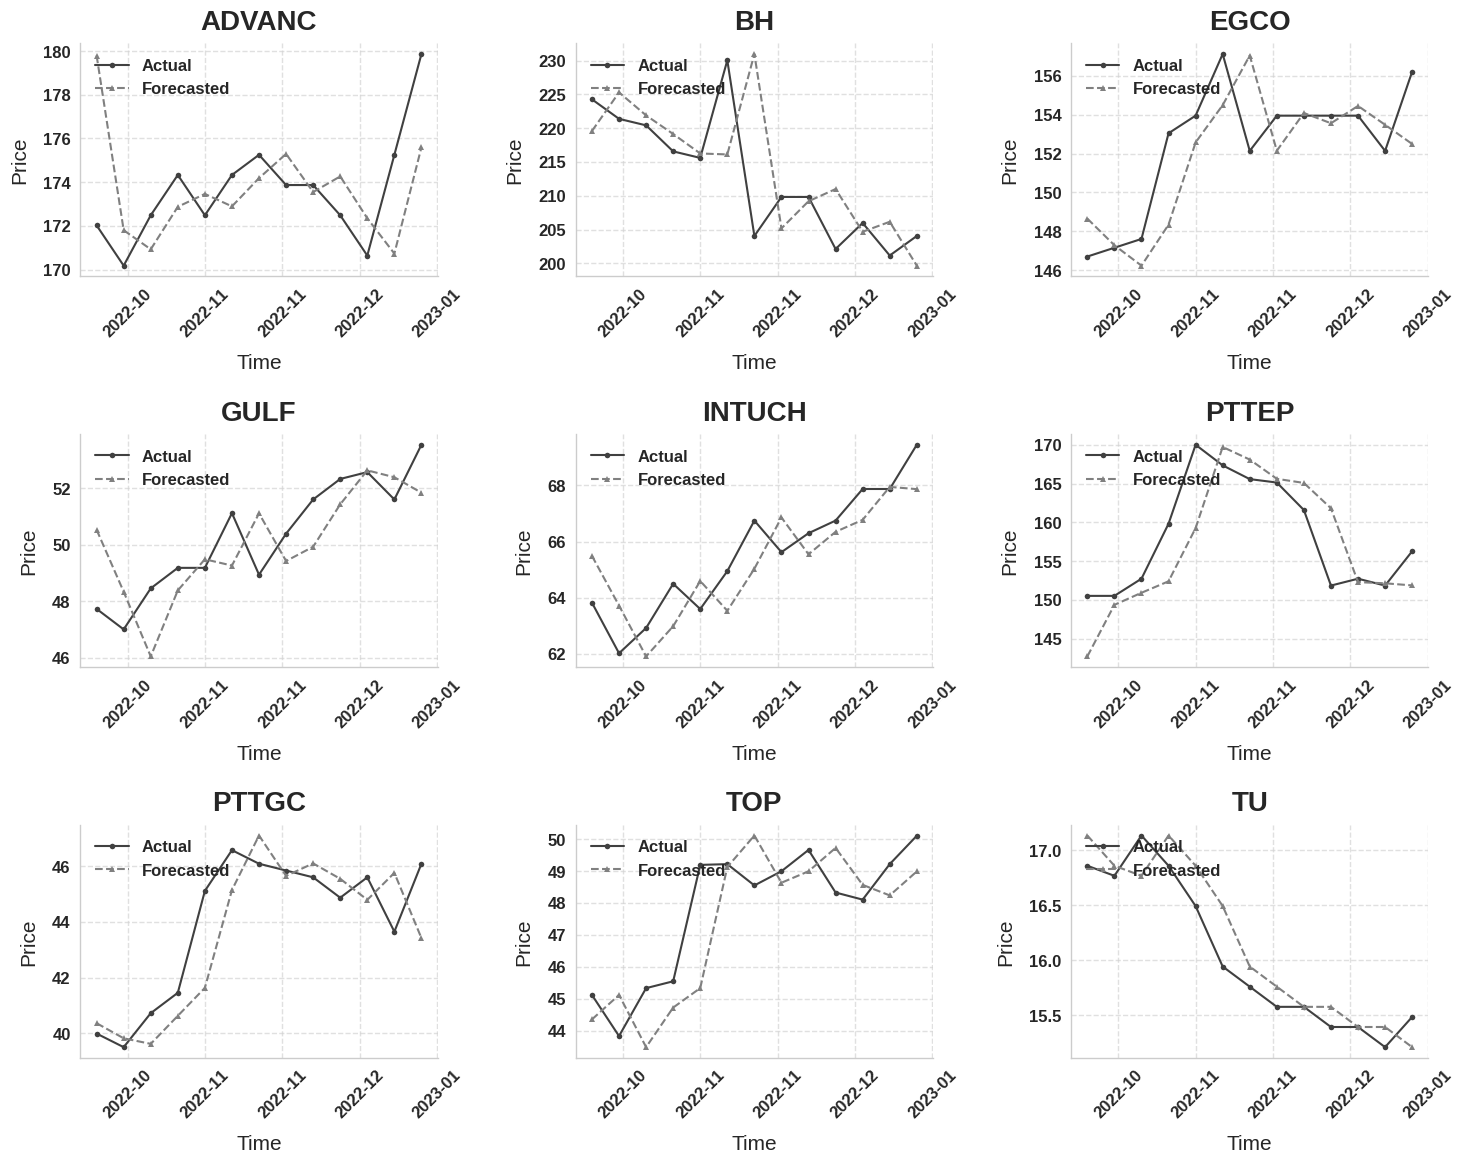

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoLocator

def plot_actual_vs_forecasted(actual_values, predicted_values):
    stocks = actual_values.columns
    plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn style for better aesthetics
    fig = plt.figure(figsize=(15, 12))

    # Define gray color palette
    colors = ['#404040', '#808080']  # Dark gray, Medium gray

    for i, stock in enumerate(stocks, 1):
        ax = plt.subplot(3, 3, i)

        # Extract data
        actual_stock_data = actual_values[stock]
        predicted_stock_name = stock.replace('Actual_', 'Predicted_')
        predicted_stock_data = predicted_values[predicted_stock_name]

        # Plot with different markers and gray colors
        ax.plot(actual_values.index, actual_stock_data,
                label='Actual',
                color=colors[0],
                marker='o',
                markersize=4,
                linestyle='-',
                linewidth=1.5)

        ax.plot(predicted_values.index, predicted_stock_data,
                label='Forecasted',
                color=colors[1],
                marker='^',
                markersize=4,
                linestyle='--',
                linewidth=1.5)

        # Customize x-axis
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        # Add grid with light gray color
        ax.grid(True, linestyle='--', alpha=0.7, color='#D3D3D3')

        # Customize title and labels
        plt.title(stock.replace('Actual_', ''), pad=10, fontsize=20, fontweight='bold')
        plt.xlabel('Time', labelpad=10, fontsize=15)
        plt.ylabel('Price', labelpad=10, fontsize=15)

        # Add legend with custom position
        plt.legend(loc='upper left', frameon=False, framealpha=0.9,  fontsize=12)

        # Add legend with custom position and get legend handles and labels
        legend = plt.legend(loc='upper left', frameon=False, framealpha=0.9, fontsize=12)

        # Make legend text bold
        for text in legend.get_texts():
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make x-tick labels bold
        for text in ax.get_xticklabels(): # This line was incorrectly indented
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make y-tick labels bold
        for text in ax.get_yticklabels():
            text.set_fontweight('bold')
            text.set_fontsize(12)


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig

# Example usage:
fig = plot_actual_vs_forecasted(actual_values, predicted_values)
plt.show()

In [ ]:
actual_values

Actual_ADVANC   Actual_BH  Actual_EGCO  Actual_GULF  \
2022-10-07     172.024826  224.268814   146.702072    47.724342   
2022-10-14     170.180054  221.381210   147.154846    46.997574   
2022-10-21     172.486023  220.418701   147.607635    48.451107   
2022-10-28     174.330780  216.568588   153.041061    49.177876   
2022-11-04     172.486023  215.606079   153.946609    49.177876   
2022-11-11     174.330780  230.043991   157.116104    51.115917   
2022-11-18     175.253174  204.055740   152.135483    48.935619   
2022-11-25     173.869583  209.830902   153.946609    50.389153   
2022-12-02     173.869583  209.830902   153.946609    51.600430   
2022-12-09     172.486023  202.130692   153.946609    52.327198   
2022-12-16     170.641235  205.980804   153.946609    52.569450   
2022-12-23     175.253174  201.168152   152.135483    51.600430   
2022-12-30     179.865097  204.055740   156.210510    53.538475   

            Actual_INTUCH  Actual_PTTEP  Actual_PTTGC  Actual_TOP  Actual_TU  
2022-10-07      63.824615    150.516144     39.994839   45.114910  16.858240  
2022-10-14      62.026745    150.516144     39.507099   43.825916  16.766617  
2022-10-21      62.925678    152.729630     40.726452   45.329742  17.133101  
2022-10-28      64.498810    159.812729     41.458069   45.544579  16.858240  
2022-11-04      63.599884    169.994705     45.116131   49.196739  16.491756  
2022-11-11      64.948296    167.338547     46.579357   49.220390  15.942032  
2022-11-18      66.746162    165.567780     46.091614   48.552238  15.758788  
2022-11-25      65.622490    165.125076     45.847744   48.997673  15.575547  
2022-12-02      66.296692    161.583496     45.603874   49.665821  15.575547  
2022-12-09      66.746162    151.844238     44.872261   48.329525  15.392305  
2022-12-16      67.869835    152.729630     45.603874   48.106808  15.392305  
2022-12-23      67.869835    151.844238     43.652905   49.220390  15.209064  
2022-12-30      69.442978    156.271179     46.091614   50.111256  15.483927

In [ ]:
predicted_values

Predicted_ADVANC Predicted_BH Predicted_EGCO Predicted_GULF  \
2022-10-07       179.797361   219.586208     148.652853      50.527968   
2022-10-14       171.803536   225.293114     147.283523      48.332429   
2022-10-21       170.928493    221.89285      146.23325      46.040703   
2022-10-28       172.874409   219.139044      148.34096       48.37881   
2022-11-04       173.462573   216.260129     152.570745      49.481803   
2022-11-11       172.894224   216.117362      154.48813      49.259081   
2022-11-18       174.185841    230.96872     157.039698      51.108074   
2022-11-25       175.295909   205.183328     152.141912      49.420039   
2022-12-02       173.548302   209.195091     154.084257      49.925353   
2022-12-09       174.265326   210.997726      153.55708      51.429125   
2022-12-16       172.349532   204.680442     154.447207      52.632415   
2022-12-23       170.733144   206.157276     153.478268      52.387751   
2022-12-30         175.5962   199.665462     152.489703      51.839627   

           Predicted_INTUCH Predicted_PTTEP Predicted_PTTGC Predicted_TOP  \
2022-10-07        65.489646       142.71273       40.367099     44.348968   
2022-10-14         63.72202      149.358233       39.825333     45.117229   
2022-10-21         61.91484      150.916194       39.625552     43.478139   
2022-10-28        62.989165      152.393227       40.631427     44.720198   
2022-11-04        64.597232      159.253221       41.635161     45.331031   
2022-11-11        63.537276       169.70841       45.146931     49.129288   
2022-11-18        65.033562      168.086235       47.104928     50.118589   
2022-11-25         66.85649       165.60541       45.655497     48.637014   
2022-12-02        65.546548      165.074189       46.103866     48.995244   
2022-12-09        66.346068      161.809226       45.551079     49.729741   
2022-12-16        66.773031      152.286367          44.796     48.569878   
2022-12-23        67.944214      152.138219       45.763134     48.239211   
2022-12-30        67.864775      151.865825       43.421843     48.991901   

           Predicted_TU  
2022-10-07    17.133101  
2022-10-14     16.85824  
2022-10-21    16.766617  
2022-10-28    17.133101  
2022-11-04     16.85824  
2022-11-11    16.491756  
2022-11-18    15.942032  
2022-11-25    15.758788  
2022-12-02    15.575547  
2022-12-09    15.575547  
2022-12-16    15.392305  
2022-12-23    15.392305  
2022-12-30    15.209064

In [ ]:
combined_prices

Predicted_ADVANC Predicted_BH Predicted_EGCO Predicted_GULF  \
2022-10-07       179.797365   219.585381     148.652824      50.527963   
2022-10-14       171.803538   225.272157     147.283506      48.332425   
2022-10-21       170.928498   222.206929     146.233286      46.040707   
2022-10-28       172.874464   218.964657     148.340936      48.378808   
2022-11-04       173.462589   216.260218     152.570742      49.481801   
2022-11-11       172.894214   216.117274     154.488055      49.259077   
2022-11-18       174.185917   230.968703     157.039505      51.108071   
2022-11-25       175.295901   205.322807     152.141862      49.420036   
2022-12-02       173.548298   209.196493     154.084136      49.925349   
2022-12-09       174.265329   210.993082     153.557054      51.429121   
2022-12-16       172.349473   204.680874     154.447165      52.632412   
2022-12-23       170.733173   206.157264     153.478213      52.387752   
2022-12-30       175.596194   200.222277       152.4897      51.839622   

           Predicted_INTUCH Predicted_PTTEP Predicted_PTTGC Predicted_TOP  \
2022-10-07        65.489654      142.712765       40.353028     44.348068   
2022-10-14        63.722019       149.35823       39.821167     45.114458   
2022-10-21        61.914828      150.916197        39.61418     43.495712   
2022-10-28        62.989162      152.393227       40.631019     44.670452   
2022-11-04         64.59724      159.253224       41.627658     45.368698   
2022-11-11        63.537276       169.70841       45.151184     49.125073   
2022-11-18        65.033554      168.086231       47.121052     50.119008   
2022-11-25        66.856498      165.605407       45.617109      48.63691   
2022-12-02        65.546556      165.074189       46.113658      48.99484   
2022-12-09        66.346068      161.809241       45.563972     49.727376   
2022-12-16        66.773039      152.286371       44.673119     48.570494   
2022-12-23        67.944221      152.138221       45.748817     48.245142   
2022-12-30        67.864783      151.865824       43.427738     48.986448   

           Predicted_TU  Actual_ADVANC   Actual_BH  Actual_EGCO  Actual_GULF  \
2022-10-07    17.133102     172.024826  224.268799   146.702057    47.724339   
2022-10-14     16.85824     170.180069  221.381226   147.154846    46.997574   
2022-10-21    16.766617     172.486023  220.418716   147.607620    48.451107   
2022-10-28    17.133102     174.330795  216.568573   153.041061    49.177872   
2022-11-04     16.85824     172.486023  215.606064   153.946609    49.177872   
2022-11-11    16.491756     174.330795  230.043976   157.116119    51.115917   
2022-11-18    15.942029     175.253174  204.055756   152.135483    48.935616   
2022-11-25     15.75879     173.869583  209.830902   153.946609    50.389149   
2022-12-02    15.575547     173.869583  209.830902   153.946609    51.600426   
2022-12-09    15.575547     172.486023  202.130707   153.946609    52.327194   
2022-12-16    15.392303     170.641235  205.980789   153.946609    52.569450   
2022-12-23    15.392303     175.253174  201.168152   152.135483    51.600426   
2022-12-30    15.209064     179.865097  204.055756   156.210526    53.538471   

            Actual_INTUCH  Actual_PTTEP  Actual_PTTGC  Actual_TOP  Actual_TU  
2022-10-07      63.824615    150.516144     39.994839   45.114910  16.858240  
2022-10-14      62.026733    150.516144     39.507099   43.825916  16.766617  
2022-10-21      62.925674    152.729630     40.726452   45.329742  17.133102  
2022-10-28      64.498817    159.812744     41.458069   45.544579  16.858240  
2022-11-04      63.599884    169.994705     45.116131   49.196735  16.491756  
2022-11-11      64.948288    167.338547     46.579357   49.220390  15.942029  
2022-11-18      66.746170    165.567780     46.091614   48.552242  15.758790  
2022-11-25      65.622498    165.125076     45.847744   48.997669  15.575547  
2022-12-02      66.296692    161.583511     45.603874   49.6658

## download

In [ ]:
from os import lstat
test_data.to_csv('test_data.csv')
full_train_data.to_csv('full_train_data.csv')
actual_directions.to_csv('actual_directions.csv')
predicted_directions.to_csv('predicted_directions_arima.csv')
predicted_prices.to_csv('predicted_prices_arima.csv')
combined_prices.to_csv('combined_prices_arima.csv')


In [ ]:
actual_selected_stock=selectted_stocks(actual_directions)
actual_selected_stock

{'2022-10-07': ['BH', 'PTTEP', 'TOP'],
 '2022-10-14': ['EGCO'],
 '2022-10-21': ['ADVANC',
  'EGCO',
  'GULF',
  'INTUCH',
  'PTTEP',
  'PTTGC',
  'TOP',
  'TU'],
 '2022-10-28': ['ADVANC', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-04': ['EGCO', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-11': ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTGC', 'TOP'],
 '2022-11-18': ['ADVANC', 'INTUCH'],
 '2022-11-25': ['BH', 'EGCO', 'GULF', 'TOP'],
 '2022-12-02': ['GULF', 'INTUCH', 'TOP'],
 '2022-12-09': ['GULF', 'INTUCH'],
 '2022-12-16': ['BH', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC'],
 '2022-12-23': ['ADVANC', 'TOP'],
 '2022-12-30': ['ADVANC',
  'BH',
  'EGCO',
  'GULF',
  'INTUCH',
  'PTTEP',
  'PTTGC',
  'TOP',
  'TU']}

In [ ]:


import pandas as pd

# Assuming selected_stocks_arima is a dictionary
selected_stocks_arima_df = pd.DataFrame(list(selected_stocks_arima.items()),
                                       columns=['Date', 'Selected Stocks'])

# If 'Selected Stocks' column contains lists, convert them to strings
selected_stocks_arima_df['Selected Stocks'] = selected_stocks_arima_df['Selected Stocks'].apply(', '.join)

selected_stocks_arima_df.to_csv('selected_stocks_arima.csv', index=False)




import pandas as pd

# Convert the dictionary to a DataFrame
actual_selected_stock_df = pd.DataFrame(list(actual_selected_stock.items()),
                                       columns=['Date', 'Selected Stocks'])

# Assuming 'Selected Stocks' column might contain lists, convert them to strings
actual_selected_stock_df['Selected Stocks'] = actual_selected_stock_df['Selected Stocks'].apply(', '.join)

# Now you can save the DataFrame to CSV
actual_selected_stock_df.to_csv('actual_selected_stock.csv', index=False)


# working

In [ ]:
import numpy as np
import pandas as pd

# -----------------------------------------
# RSI-based filtering function
# -----------------------------------------
def calculate_rsi(data, window=1):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def forecast_stocks_rsi(data, window=1, threshold=30, forecast_horizon=1):
    forecasted_directions = pd.DataFrame(index=data.index, columns=data.columns)

    rsi_scores = data.apply(calculate_rsi, window=window)

    for date in rsi_scores.index:
        forecasted_directions.loc[date] = np.where(rsi_scores.loc[date] < threshold, 1, -1)

    return forecasted_directions

# Apply RSI forecast
predicted_directions_rsi = forecast_stocks_rsi(df)
print("Predicted Directions (RSI):\n", predicted_directions_rsi)




Predicted Directions (RSI):
            ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2017-12-08     -1  -1   -1   -1     -1    -1    -1  -1  -1
2017-12-15     -1   1    1    1     -1    -1    -1  -1   1
2017-12-22     -1   1   -1   -1     -1    -1    -1   1   1
2017-12-29     -1   1    1   -1     -1    -1     1  -1  -1
2018-01-05     -1  -1   -1   -1     -1    -1    -1  -1  -1
...           ...  ..  ...  ...    ...   ...   ...  ..  ..
2023-12-01     -1  -1    1   -1      1     1    -1  -1  -1
2023-12-08     -1   1    1   -1      1     1    -1   1  -1
2023-12-15     -1  -1    1   -1     -1    -1    -1  -1   1
2023-12-22     -1   1   -1    1     -1    -1     1  -1   1
2023-12-29      1  -1   -1    1     -1    -1    -1  -1  -1

[317 rows x 9 columns]


In [ ]:
predicted_directions_rsi=predicted_directions_rsi.loc['2022-09-30':'2022-12-30']
predicted_directions_rsi

ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2022-09-30     -1  -1    1    1     -1     1     1   1  -1
2022-10-07      1  -1    1    1      1    -1     1  -1   1
2022-10-14      1   1   -1    1      1    -1     1   1   1
2022-10-21     -1   1   -1   -1     -1    -1    -1  -1  -1
2022-10-28     -1   1   -1   -1     -1    -1    -1  -1   1
2022-11-04      1   1   -1   -1      1    -1    -1  -1   1
2022-11-11     -1  -1   -1   -1     -1     1    -1  -1   1
2022-11-18     -1   1    1    1     -1     1     1   1   1
2022-11-25      1  -1   -1   -1      1     1     1  -1   1
2022-12-02     -1  -1   -1   -1     -1     1     1  -1  -1
2022-12-09      1   1   -1   -1     -1     1     1   1   1
2022-12-16      1  -1   -1   -1     -1    -1    -1   1  -1
2022-12-23     -1   1    1    1     -1     1     1  -1   1
2022-12-30     -1  -1   -1   -1     -1    -1    -1  -1  -1

In [ ]:
# predicted_directions_rsi=predicted_directions_rsi.loc['2022-09-30':'2022-12-30']
predicted_directions_rsi=predicted_directions_rsi[:-1]
# Reset the index to convert the current index to a column and create a new sequential index
predicted_directions_rsi = predicted_directions_rsi.reset_index(drop=True)
predicted_directions_rsi.index = test_data.index


In [ ]:
predicted_directions_rsi

ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2022-10-07     -1  -1    1    1     -1     1     1   1  -1
2022-10-14      1  -1    1    1      1    -1     1  -1   1
2022-10-21      1   1   -1    1      1    -1     1   1   1
2022-10-28     -1   1   -1   -1     -1    -1    -1  -1  -1
2022-11-04     -1   1   -1   -1     -1    -1    -1  -1   1
2022-11-11      1   1   -1   -1      1    -1    -1  -1   1
2022-11-18     -1  -1   -1   -1     -1     1    -1  -1   1
2022-11-25     -1   1    1    1     -1     1     1   1   1
2022-12-02      1  -1   -1   -1      1     1     1  -1   1
2022-12-09     -1  -1   -1   -1     -1     1     1  -1  -1
2022-12-16      1   1   -1   -1     -1     1     1   1   1
2022-12-23      1  -1   -1   -1     -1    -1    -1   1  -1
2022-12-30     -1   1    1    1     -1     1     1  -1   1

In [ ]:
selected_stocks_rsi=selectted_stocks(predicted_directions_rsi)
selected_stocks_rsi

{'2022-10-07': ['EGCO', 'GULF', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-10-14': ['ADVANC', 'EGCO', 'GULF', 'INTUCH', 'PTTGC', 'TU'],
 '2022-10-21': ['ADVANC', 'BH', 'GULF', 'INTUCH', 'PTTGC', 'TOP', 'TU'],
 '2022-10-28': ['BH'],
 '2022-11-04': ['BH', 'TU'],
 '2022-11-11': ['ADVANC', 'BH', 'INTUCH', 'TU'],
 '2022-11-18': ['PTTEP', 'TU'],
 '2022-11-25': ['BH', 'EGCO', 'GULF', 'PTTEP', 'PTTGC', 'TOP', 'TU'],
 '2022-12-02': ['ADVANC', 'INTUCH', 'PTTEP', 'PTTGC', 'TU'],
 '2022-12-09': ['PTTEP', 'PTTGC'],
 '2022-12-16': ['ADVANC', 'BH', 'PTTEP', 'PTTGC', 'TOP', 'TU'],
 '2022-12-23': ['ADVANC', 'TOP'],
 '2022-12-30': ['BH', 'EGCO', 'GULF', 'PTTEP', 'PTTGC', 'TU']}

In [ ]:
selectted_stocks(actual_directions)

{'2022-10-07': ['BH', 'PTTEP', 'TOP'],
 '2022-10-14': ['EGCO'],
 '2022-10-21': ['ADVANC',
  'EGCO',
  'GULF',
  'INTUCH',
  'PTTEP',
  'PTTGC',
  'TOP',
  'TU'],
 '2022-10-28': ['ADVANC', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-04': ['EGCO', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-11': ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTGC', 'TOP'],
 '2022-11-18': ['ADVANC', 'INTUCH'],
 '2022-11-25': ['BH', 'EGCO', 'GULF', 'TOP'],
 '2022-12-02': ['GULF', 'INTUCH', 'TOP'],
 '2022-12-09': ['GULF', 'INTUCH'],
 '2022-12-16': ['BH', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC'],
 '2022-12-23': ['ADVANC', 'TOP'],
 '2022-12-30': ['ADVANC',
  'BH',
  'EGCO',
  'GULF',
  'INTUCH',
  'PTTEP',
  'PTTGC',
  'TOP',
  'TU']}

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_rsi = predicted_directions_rsi.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_rsi = predicted_directions_rsi.dropna()

# Align both series to have the same length
# predicted_directions_rsi = predicted_directions_rsi.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_rsi[stock].values)
    all_accuracies.append(accuracy)
    print(f"Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall Model Accuracy: {np.mean(all_accuracies) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_rsi[stock].values)
    print(f"\nConfusion Matrix for {stock}:")
    print(conf_matrix)


Accuracy for ADVANC: 53.85%
Accuracy for BH: 69.23%
Accuracy for EGCO: 61.54%
Accuracy for GULF: 46.15%
Accuracy for INTUCH: 53.85%
Accuracy for PTTEP: 46.15%
Accuracy for PTTGC: 38.46%
Accuracy for TOP: 53.85%
Accuracy for TU: 46.15%
Overall Model Accuracy: 52.14%

Confusion Matrix for ADVANC:
[[4 3]
 [3 3]]

Confusion Matrix for BH:
[[5 3]
 [1 4]]

Confusion Matrix for EGCO:
[[5 1]
 [4 3]]

Confusion Matrix for GULF:
[[3 2]
 [5 3]]

Confusion Matrix for INTUCH:
[[4 1]
 [5 3]]

Confusion Matrix for PTTEP:
[[3 4]
 [3 3]]

Confusion Matrix for PTTGC:
[[2 5]
 [3 3]]

Confusion Matrix for TOP:
[[3 1]
 [5 4]]

Confusion Matrix for TU:
[[4 7]
 [0 2]]


# LSTM

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense, Input # Import GRU instead of LSTM


In [ ]:
from re import X
from tensorflow.keras.layers import LSTM, Dense, Input # Import Input here


#function 1
def prepare_data_for_lstm(data, look_back):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back), 0])
        y.append(scaled_data[i + look_back, 0])

    return np.array(X), np.array(y), scaler

#function 2

# def create_lstm_model(look_back):
#     model = Sequential()
#     model.add(LSTM(units=5, input_shape=(look_back, 1)))  # Only one LSTM layer now
#     model.add(Dense(units=1))  # Output layer
#     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
#     return model



def  create_lstm_model (look_back):
    model = Sequential()
    model.add(Input(shape=(look_back, 1)))  # Input layer
    model.add(LSTM(units=5))  # LSTM layer  #3 neurons
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model





# # Function 2: Change LSTM to GRU in the model creation function
# def create_lstm_model(look_back):
#     model = Sequential()
#     model.add(Input(shape=(look_back, 1)))  # Input layer
#     model.add(GRU(units=3))  # GRU layer with 3 units
#     model.add(Dense(units=1))  # Output layer
#     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
#     return model

#function 3

def forecast_stocks_lstm(data, forecast_horizon=1, look_back=100, epochs=50, batch_size=32):
    forecasted_prices = {}
    directions = {}

#---------------------------------------------------------------------------------------------------------------------------------------

    for column in data.columns:
        X, y, scaler = prepare_data_for_lstm(data[column], look_back)
        #(samples, time steps, features)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        model = create_lstm_model(look_back)
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Prepare the last 'look_back' days for forecasting
        last_look_back_days = data[column].iloc[-look_back:].values.reshape(-1, 1)
        last_look_back_days_scaled = scaler.transform(last_look_back_days)
        X_forecast = last_look_back_days_scaled.reshape(1, look_back, 1)  #samples, time steps, features (WHY NOT X_forecast.shape[0], X_forecast.shape[1], 1) )

        # Forecast
        forecast_scaled = model.predict(X_forecast)
        forecast = scaler.inverse_transform(forecast_scaled)[0][0]

        # Store forecasted price
        forecasted_prices[column] = forecast

        # Determine direction: 1 for up, -1 for down
        last_actual_price = data[column].iloc[-1]
        direction = 1 if forecast > last_actual_price else -1
        directions[column] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

In [ ]:

from sklearn.preprocessing import MinMaxScaler

# Initialize variables
initial_train_end = '2022-09-30'
full_train_data = df[df.index <= initial_train_end]  # Training data
test_data = df[(df.index > initial_train_end) & (df.index <= '2022-12-31')]  #
#test_data = df[(df.index > initial_train_end)]  #




# DataFrames to store both forecasted prices and directions
predicted_prices_lstm = pd.DataFrame(index=test_data.index, columns=df.columns)
predicted_directions_lstm = pd.DataFrame(index=test_data.index, columns=df.columns)

# Loop over each week in the test set
for i in range(len(test_data)):
    test_week = test_data.iloc[i:i+1]
    current_date = test_data.index[i]

    # Forecast prices and directions using LSTM
    forecasts, directions = forecast_stocks_lstm(full_train_data)

    # Store forecasted prices and directions
    predicted_prices_lstm.loc[current_date] = forecasts
    predicted_directions_lstm.loc[current_date] = directions

    # Add the actual prices of the current test week to the training data
    full_train_data = pd.concat([full_train_data, test_week])

1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 355ms/step


In [ ]:

def selectted_stocks(predicted_directions):
  selected_stocks={}
  for i in range(len(predicted_directions)):
    date_str = predicted_directions.index[i].strftime('%Y-%m-%d')
    selected_stocks[date_str] = predicted_directions.iloc[i][predicted_directions.iloc[i]==1].index.tolist()

  return selected_stocks

In [ ]:
# Print results
print("LSTM Predicted Prices:")
print(predicted_prices_lstm)
print("LSTM Predicted Directions:")
print(predicted_directions_lstm)
selected_stocks_lstm = selectted_stocks(predicted_directions_lstm)
print("Selected Stocks (LSTM):")
print(selected_stocks_lstm)

LSTM Predicted Prices:
                ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07  177.496353  217.630249  151.759079  50.683357  64.662506   
2022-10-14  174.745667  230.449799  150.793121  49.906544  64.475922   
2022-10-21   171.01622  229.638504  148.164749  49.196762  63.956047   
2022-10-28  172.908066  229.686279  149.849396  49.572571   63.51593   
2022-11-04   172.51828  227.691452  150.704651  48.638092  63.933525   
2022-11-11  172.455566  224.798035  152.922546  49.188461  63.849754   
2022-11-18  171.682785  229.439697  156.027542  49.721668  64.694847   
2022-11-25  172.103012  219.725235  152.675919  50.085899  65.858292   
2022-12-02  170.883286  219.818359   154.94281  48.923462  65.601654   
2022-12-09  172.995438  220.463669  154.310135  49.182468   64.67543   
2022-12-16  174.090958  214.118668  151.065399  51.851246  64.952423   
2022-12-23  172.027191  209.313675  153.815842     52.527  66.560211   
2022-12-30  173.171585  212.265671  153.5

Combined Prices (LSTM):
           Predicted_ADVANC Predicted_BH Predicted_EGCO Predicted_GULF  \
2022-10-07       177.496353   217.630249     151.759079      50.683357   
2022-10-14       174.745667   230.449799     150.793121      49.906544   
2022-10-21        171.01622   229.638504     148.164749      49.196762   
2022-10-28       172.908066   229.686279     149.849396      49.572571   
2022-11-04        172.51828   227.691452     150.704651      48.638092   
2022-11-11       172.455566   224.798035     152.922546      49.188461   
2022-11-18       171.682785   229.439697     156.027542      49.721668   
2022-11-25       172.103012   219.725235     152.675919      50.085899   
2022-12-02       170.883286   219.818359      154.94281      48.923462   
2022-12-09       172.995438   220.463669     154.310135      49.182468   
2022-12-16       174.090958   214.118668     151.065399      51.851246   
2022-12-23       172.027191   209.313675     153.815842         52.527   
2022-12-30    

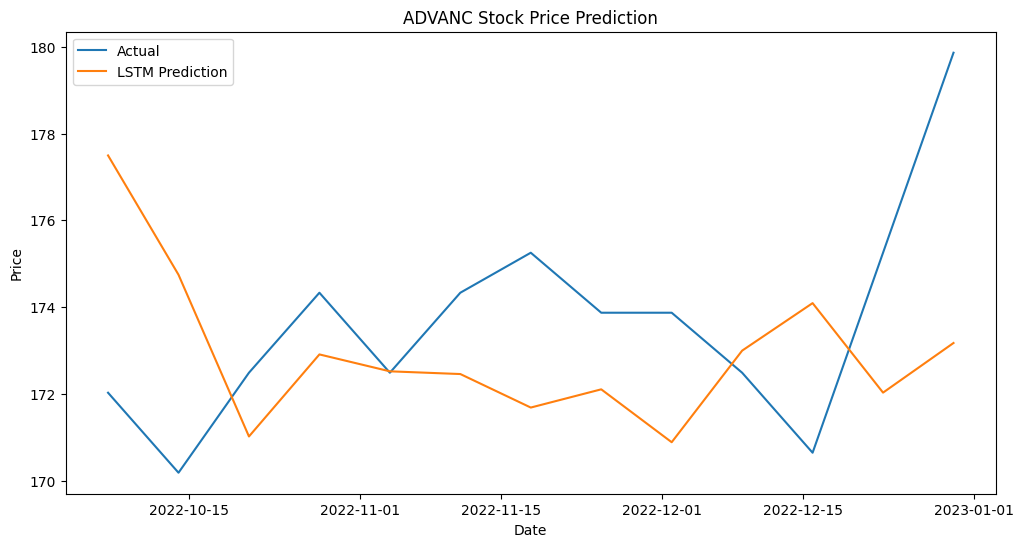

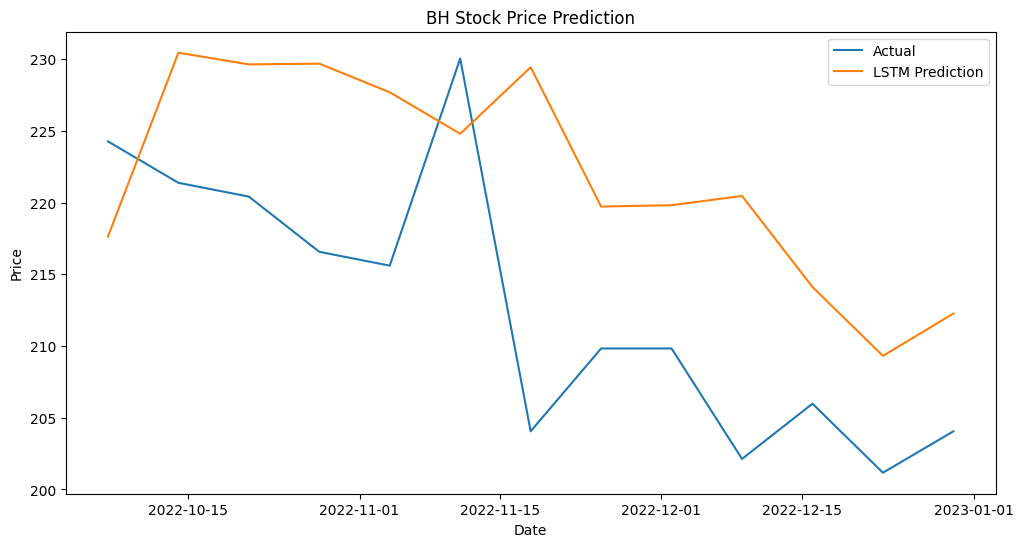

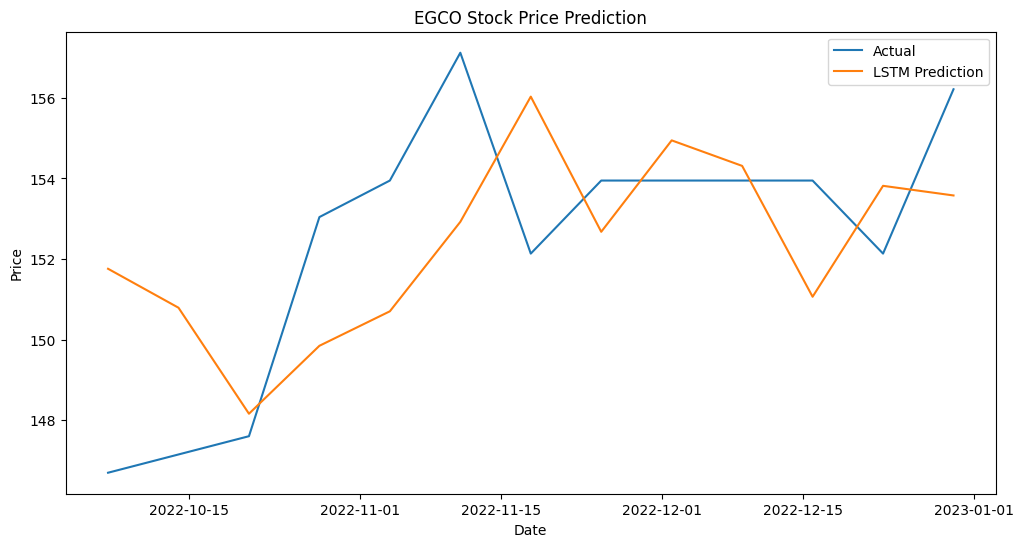

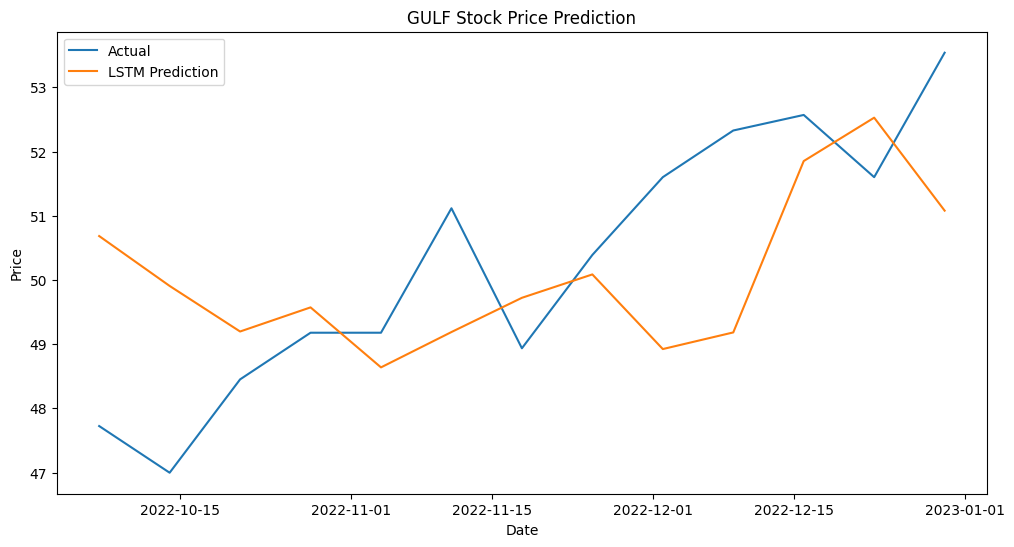

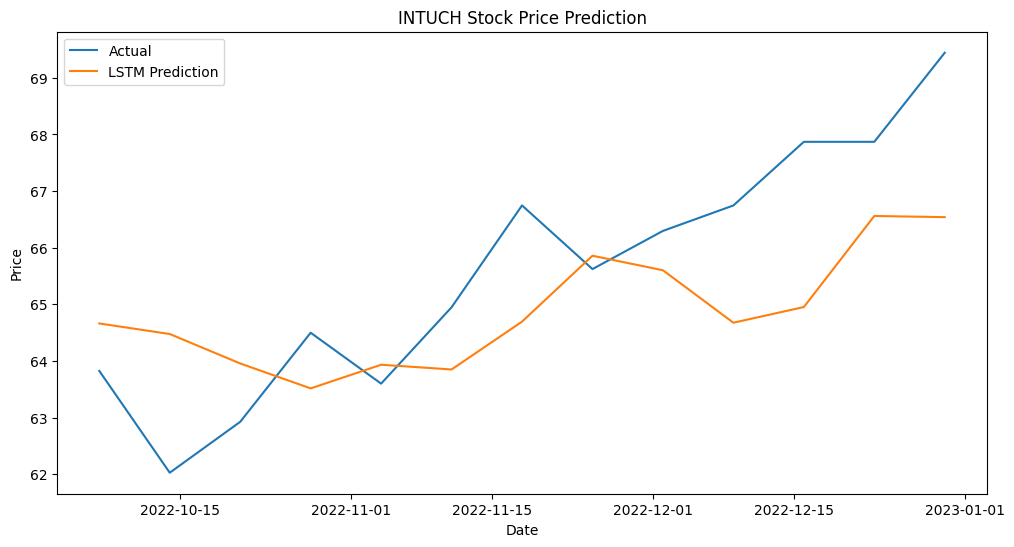

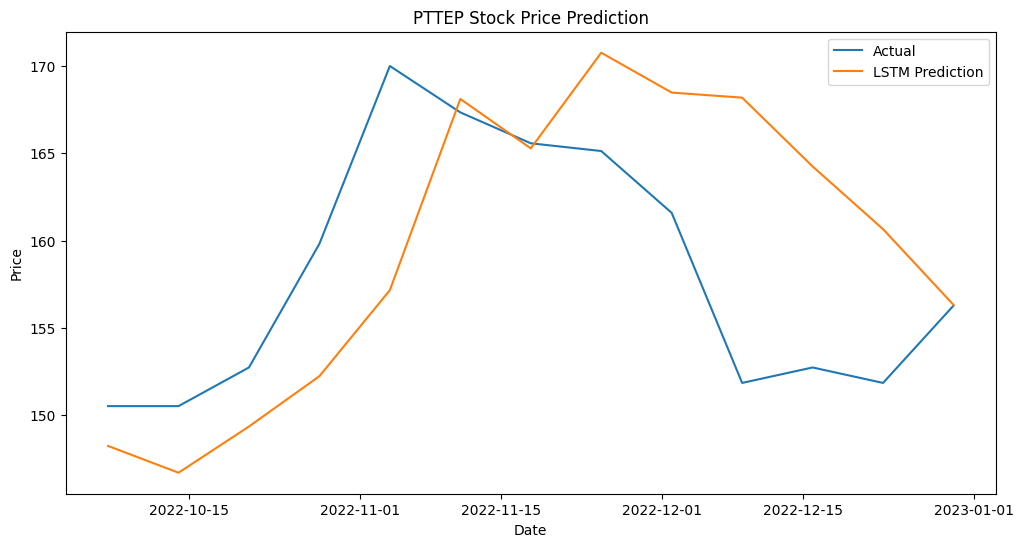

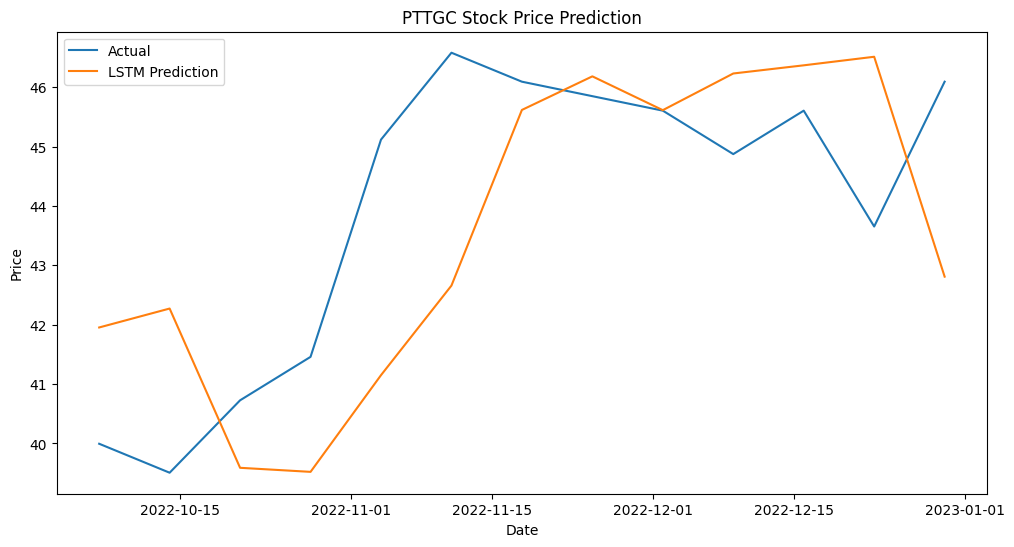

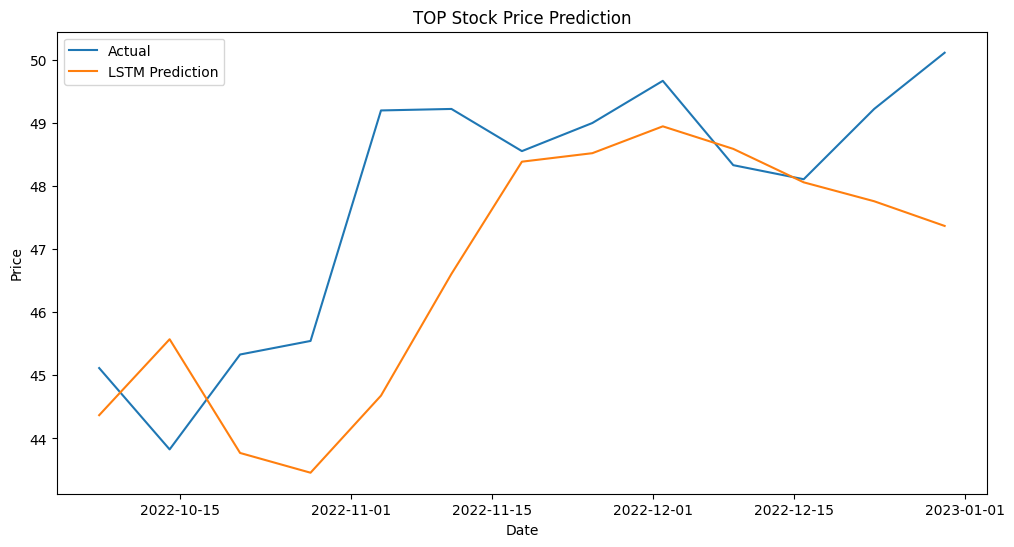

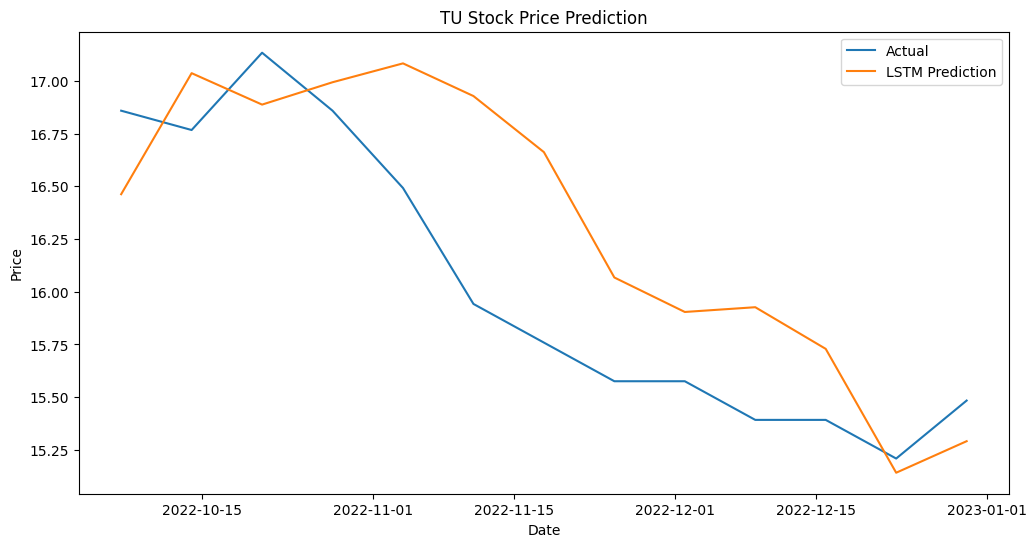

In [ ]:
# Combine the predicted prices and actual prices
combined_prices_lstm = pd.concat([predicted_prices_lstm, test_data], axis=1)
combined_prices_lstm.columns = [f'Predicted_{col}' if i < len(predicted_prices_lstm.columns) else f'Actual_{col}'
                                for i, col in enumerate(combined_prices_lstm.columns)]

print("Combined Prices (LSTM):")
print(combined_prices_lstm)

from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_lstm = predicted_directions_lstm.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_lstm = predicted_directions_lstm.dropna()

# Align both series to have the same length
predicted_directions_lstm = predicted_directions_lstm.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies_lstm = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_lstm[stock].values)
    all_accuracies_lstm.append(accuracy)
    print(f"LSTM Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall LSTM Model Accuracy: {np.mean(all_accuracies_lstm) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_lstm[stock].values)
    print(f"\nLSTM Confusion Matrix for {stock}:")
    print(conf_matrix)


# Visualize the predictions
import matplotlib.pyplot as plt

def plot_predictions(stock):
    plt.figure(figsize=(12, 6))
    plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Actual_{stock}'], label='Actual')
    plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Predicted_{stock}'], label='LSTM Prediction')
    plt.title(f'{stock} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot predictions for each stock
for stock in test_data.columns:
    plot_predictions(stock)

In [ ]:
predicted_prices_lstm.to_csv('predicted_prices1_lstm.csv')
predicted_directions_lstm.to_csv('predicted_directions1_lstm.csv')
selected_stocks_lstm_df.to_csv('selected_stocks_lstm.csv', index=False)



# Assuming selected_stocks_lstm is your dictionary
selected_stocks_lstm_df = pd.DataFrame(list(selected_stocks_lstm.items()), columns=['Date', 'Selected Stocks'])

# Convert the 'Selected Stocks' column (which contains lists) to strings
selected_stocks_lstm_df['Selected Stocks'] = selected_stocks_lstm_df['Selected Stocks'].apply(', '.join)



# Convert the dictionary to a DataFrame
actual_selected_stock_df = pd.DataFrame(list(actual_selected_stock.items()),
                                       columns=['Date', 'Selected Stocks'])

# Assuming 'Selected Stocks' column might contain lists, convert them to strings
actual_selected_stock_df['Selected Stocks'] = actual_selected_stock_df['Selected Stocks'].apply(', '.join)

actual_selected_stock_df.to_csv('selected_stock_actual.csv', index=False)





# Now you can save it to a CSV
#predicted_prices.to_csv('predicted_prices.csv')
#predicted_directions.to_csv('predicted_directions.csv')
#actual_directions.to_csv('actual_directions.csv')
#test_data.to_csv('test_data.csv')

NameError: name 'selected_stocks_lstm_df' is not defined

In [ ]:
actual_selected_stock=selectted_stocks(actual_directions)
actual_selected_stock



{'2022-10-07': ['BH', 'PTTEP', 'TOP'],
 '2022-10-14': ['EGCO'],
 '2022-10-21': ['ADVANC',
  'EGCO',
  'GULF',
  'INTUCH',
  'PTTEP',
  'PTTGC',
  'TOP',
  'TU'],
 '2022-10-28': ['ADVANC', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-04': ['EGCO', 'PTTEP', 'PTTGC', 'TOP'],
 '2022-11-11': ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTGC', 'TOP'],
 '2022-11-18': ['ADVANC', 'INTUCH'],
 '2022-11-25': ['BH', 'EGCO', 'GULF', 'TOP'],
 '2022-12-02': ['GULF', 'INTUCH', 'TOP'],
 '2022-12-09': ['GULF', 'INTUCH'],
 '2022-12-16': ['BH', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC'],
 '2022-12-23': ['ADVANC', 'TOP'],
 '2022-12-30': ['ADVANC',
  'BH',
  'EGCO',
  'GULF',
  'INTUCH',
  'PTTEP',
  'PTTGC',
  'TOP',
  'TU']}

In [ ]:
selected_stocks_lstm=selectted_stocks(predicted_directions_lstm)
selected_stocks_lstm

{'2022-10-07': ['EGCO', 'TOP'],
 '2022-10-14': ['BH', 'EGCO', 'GULF', 'INTUCH', 'PTTGC', 'TU'],
 '2022-10-21': ['ADVANC', 'BH', 'GULF', 'INTUCH', 'PTTGC', 'TOP', 'TU'],
 '2022-10-28': ['ADVANC', 'INTUCH'],
 '2022-11-04': ['PTTGC', 'TU'],
 '2022-11-11': ['ADVANC', 'INTUCH', 'TU'],
 '2022-11-18': ['TU'],
 '2022-11-25': ['BH', 'EGCO', 'GULF', 'TU'],
 '2022-12-02': ['ADVANC', 'EGCO', 'INTUCH', 'PTTGC', 'TU'],
 '2022-12-09': ['ADVANC', 'INTUCH', 'PTTEP', 'PTTGC'],
 '2022-12-16': ['EGCO', 'PTTEP', 'PTTGC', 'TU'],
 '2022-12-23': ['ADVANC', 'EGCO', 'PTTEP', 'TU'],
 '2022-12-30': ['ADVANC', 'BH', 'INTUCH', 'PTTGC', 'TU']}

In [ ]:
                                                       #ARIMA  (download) + actual


from os import lstat
test_data.to_csv('test_data.csv')
full_train_data.to_csv('full_train_data.csv')
actual_directions.to_csv('actual_directions.csv')
predicted_directions.to_csv('predicted_directions_arima.csv')
predicted_prices.to_csv('predicted_prices_arima.csv')
combined_prices.to_csv('combined_prices_arima.csv')


import pandas as pd

# Assuming selected_stocks_arima is a dictionary
selected_stocks_arima_df = pd.DataFrame(list(selected_stocks_arima.items()),
                                       columns=['Date', 'Selected Stocks'])

# If 'Selected Stocks' column contains lists, convert them to strings
selected_stocks_arima_df['Selected Stocks'] = selected_stocks_arima_df['Selected Stocks'].apply(', '.join)

selected_stocks_arima_df.to_csv('selected_stocks_arima.csv', index=False)




import pandas as pd

# Convert the dictionary to a DataFrame
actual_selected_stock_df = pd.DataFrame(list(actual_selected_stock.items()),
                                       columns=['Date', 'Selected Stocks'])

# Assuming 'Selected Stocks' column might contain lists, convert them to strings
actual_selected_stock_df['Selected Stocks'] = actual_selected_stock_df['Selected Stocks'].apply(', '.join)

# Now you can save the DataFrame to CSV
actual_selected_stock_df.to_csv('actual_selected_stock.csv', index=False)


In [ ]:


                                          #LSTM  (download)


predicted_directions_lstm.to_csv('predicted_directions_lstm1.csv')
predicted_prices_lstm.to_csv('predicted_prices_lstm1.csv')
combined_prices_lstm.to_csv('combined_prices_lstm1.csv')


# Convert selected_stocks_lstm to a DataFrame before saving to CSV
selected_stocks_lstm_df = pd.DataFrame(list(selected_stocks_lstm.items()),
                                       columns=['Date', 'Selected Stocks'])
# Applying similar logic for consistency for selected_stocks_lstm
selected_stocks_lstm_df['Selected Stocks'] = selected_stocks_lstm_df['Selected Stocks'].apply(', '.join)

selected_stocks_lstm_df.to_csv('selected_stocks_lstm1.csv', index=False) # Now using the DataFrame

In [ ]:
combined_prices_lstm

Predicted_ADVANC Predicted_BH Predicted_EGCO Predicted_GULF  \
2022-10-07       177.044769   219.257965     151.725098      51.748314   
2022-10-14        177.92691   230.863388     150.190109      50.180363   
2022-10-21       170.121094   224.312103     149.016983      49.072514   
2022-10-28       171.663605   223.467285     147.796722      48.528828   
2022-11-04       173.612915   221.963715     150.807388      48.400246   
2022-11-11        173.61525   219.153671     154.150909      49.219883   
2022-11-18       174.710846   228.739319     155.666382      49.498486   
2022-11-25       174.484482   217.623734     155.021286      49.845253   
2022-12-02       173.612457   213.260208     153.446228      50.187138   
2022-12-09       175.482178   210.478333     151.959747      51.209126   
2022-12-16       174.337387   208.065033     151.609543      50.647781   
2022-12-23       171.022903   205.249786     152.683945      51.823524   
2022-12-30        170.97583   207.729553      152.22023      51.712349   

           Predicted_INTUCH Predicted_PTTEP Predicted_PTTGC Predicted_TOP  \
2022-10-07        64.949493      145.814957        42.33567     45.220093   
2022-10-14        64.997246      148.644302       41.188129     44.729385   
2022-10-21        62.773186      150.335114        40.45359     43.959801   
2022-10-28        62.554852      153.442383       40.254776     44.877838   
2022-11-04        63.883652      158.355576       41.349884     45.398533   
2022-11-11        62.976143      164.677979        42.42944     46.671101   
2022-11-18        64.460533      173.356476       44.026314     48.029835   
2022-11-25        65.776749      173.956406       45.349453     47.715221   
2022-12-02          64.1371      171.297256       46.082664     48.004684   
2022-12-09         66.34446      167.869797       45.824333     48.293762   
2022-12-16        68.142258      155.363495       45.192333     48.576458   
2022-12-23        66.782768      153.198959       44.295586     48.322529   
2022-12-30        67.678413       153.41658       44.353474     48.179539   

           Predicted_TU  Actual_ADVANC   Actual_BH  Actual_EGCO  Actual_GULF  \
2022-10-07    17.065413     172.024826  224.268814   146.702072    47.724339   
2022-10-14    16.831583     170.180054  221.381226   147.154846    46.997574   
2022-10-21    16.839594     172.486023  220.418701   147.607635    48.451107   
2022-10-28    16.859049     174.330780  216.568588   153.041061    49.177872   
2022-11-04    16.639202     172.486023  215.606064   153.946609    49.177872   
2022-11-11    16.591719     174.330780  230.043976   157.116104    51.115917   
2022-11-18    16.219822     175.253174  204.055740   152.135483    48.935616   
2022-11-25    16.064634     173.869614  209.830902   153.946609    50.389149   
2022-12-02    15.913555     173.869614  209.830902   153.946609    51.600426   
2022-12-09    15.903871     172.486023  202.130676   153.946609    52.327194   
2022-12-16    15.324272     170.641235  205.980804   153.946609    52.569450   
2022-12-23    15.426005     175.253174  201.168182   152.135483    51.600426   
2022-12-30    15.365173     179.865097  204.055740   156.210526    53.538471   

            Actual_INTUCH  Actual_PTTEP  Actual_PTTGC  Actual_TOP  Actual_TU  
2022-10-07      63.824615    150.516159     39.994839   45.114910  16.858238  
2022-10-14      62.026741    150.516159     39.507099   43.825916  16.766619  
2022-10-21      62.925686    152.729630     40.726452   45.329742  17.133101  
2022-10-28      64.498817    159.812729     41.458069   45.544579  16.858238  
2022-11-04      63.599884    169.994720     45.116131   49.196735  16.491756  
2022-11-11      64.948296    167.338547     46.579353   49.220390  15.942031  
2022-11-18      66.746170    165.567780     46.091614   48.552238  15.758789  
2022-11-25      65.622498    165.125076     45.847744   48.997673  15.575548  
2022-12-02      66.296700    161.583511     45.603870   49.6658

In [ ]:
# Initialize dictionaries to store the results for each stock
rmse_dict = {}
mae_dict = {}
mape_dict = {}
r2_dict = {}

# Loop through each stock (column pair of actual and predicted values)
for stock in predicted_values.columns:
    # Extract the predicted and actual values for this stock
    actual_col = stock.replace('Predicted', 'Actual')
    predicted_stock = combined_prices_lstm[stock]
    actual_stock = combined_prices_lstm[actual_col]

    # Calculate RMSE
    rmse_dict[stock] = np.sqrt(mean_squared_error(actual_stock, predicted_stock))

    # Calculate MAE
    mae_dict[stock] = mean_absolute_error(actual_stock, predicted_stock)

    # Calculate MAPE
    mape_dict[stock] = np.mean(np.abs((actual_stock - predicted_stock) / actual_stock)) * 100

    # Calculate R-squared
    r2_dict[stock] = r2_score(actual_stock, predicted_stock)

# Print the results for each stock
for stock in predicted_values.columns:
    print(f"Metrics for {stock.replace('Predicted_', '')}:")
    print(f"  RMSE: {rmse_dict[stock]}")
    print(f"  MAE: {mae_dict[stock]}")
    print(f"  MAPE: {mape_dict[stock]}%")
    print(f"  R-squared: {r2_dict[stock]}")
    print("\n")


NameError: name 'predicted_values' is not defined

#lstm + volume

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# List of tickers
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']

# Define start and end date for historical data
start_date = '2017-12-08'
end_date = '2023-12-30'

# Download the adjusted close price data
df_price = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
df_price = df_price.resample('W-FRI').last()  # Resample to weekly data
df_price.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

# Download the volume data
df_volume = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Volume']
df_volume = df_volume.resample('W-FRI').last()  # Resample to weekly data
df_volume.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# List of tickers
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']

# Define start and end date for historical data
start_date = '2017-12-08'
end_date = '2023-12-30'

# Download the adjusted close price data
df_price = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
df_price = df_price.resample('W-FRI').last()  # Resample to weekly data
df_price.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

# Download the volume data
df_volume = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Volume']
df_volume = df_volume.resample('W-FRI').last()  # Resample to weekly data
df_volume.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

# Function to prepare data for LSTM (price + volume)
def prepare_data_for_lstm(data_price, data_volume, look_back):
    # Combine price and volume into one DataFrame
    data_combined = pd.concat([data_price, data_volume], axis=1)

    # Scale both price and volume
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_combined)

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back), :])  # Lagged price and volume
        y.append(scaled_data[i + look_back, 0])  # Target is the future price

    return np.array(X), np.array(y), scaler

# # Function to create LSTM model with two inputs (price + volume)
# def create_lstm_model(look_back):
#     model = Sequential()
#     model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
#     model.add(LSTM(units=5))  # LSTM layer with 3 neurons
#     model.add(Dense(units=1))  # Output layer
#     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
#     return model


# Function 2: Change LSTM to GRU in the model creation function
def create_lstm_model(look_back):
    model = Sequential()
    model.add(Input(shape=(look_back, 2)))  # Input layer
    model.add(GRU(units=2))  # GRU layer with 3 units
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model


# Function to forecast stocks using LSTM (price + volume)
def forecast_stocks_lstm(data_price, data_volume, forecast_horizon=1, look_back=150, epochs=30, batch_size=32):
    forecasted_prices = {}
    directions = {}

    for column in data_price.columns:
        X, y, scaler = prepare_data_for_lstm(data_price[column], data_volume[column], look_back)
        X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: price and volume

        model = create_lstm_model(look_back)
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Prepare the last 'look_back' days for forecasting
        last_look_back_days_price = data_price[column].iloc[-look_back:].values.reshape(-1, 1)
        last_look_back_days_volume = data_volume[column].iloc[-look_back:].values.reshape(-1, 1)
        last_look_back_days_combined = np.concatenate([last_look_back_days_price, last_look_back_days_volume], axis=1)

        last_look_back_days_scaled = scaler.transform(last_look_back_days_combined)
        X_forecast = last_look_back_days_scaled.reshape(1, look_back, 2)  # 2 features

        # Forecast
        forecast_scaled = model.predict(X_forecast)
        forecast = scaler.inverse_transform(np.concatenate([forecast_scaled, np.zeros((1, 1))], axis=1))[0][0]

        # Store forecasted price
        forecasted_prices[column] = forecast

        # Determine direction: 1 for up, -1 for down
        last_actual_price = data_price[column].iloc[-1]
        direction = 1 if forecast > last_actual_price else -1
        directions[column] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

# Initialize variables
initial_train_end = '2022-09-30'
full_train_data_price = df_price[df_price.index <= initial_train_end]
full_train_data_volume = df_volume[df_volume.index <= initial_train_end]
test_data = df_price[(df_price.index > initial_train_end) & (df_price.index <= '2022-12-31')]

# DataFrames to store both forecasted prices and directions
predicted_prices_lstm = pd.DataFrame(index=test_data.index, columns=df_price.columns)
predicted_directions_lstm = pd.DataFrame(index=test_data.index, columns=df_price.columns)

# Loop over each week in the test set
for i in range(len(test_data)):
    test_week_price = df_price.iloc[i:i+1]
    test_week_volume = df_volume.iloc[i:i+1]
    current_date = test_data.index[i]

    # Forecast prices and directions using LSTM (price + volume)
    forecasts, directions = forecast_stocks_lstm(full_train_data_price, full_train_data_volume)

    # Store forecasted prices and directions
    predicted_prices_lstm.loc[current_date] = forecasts
    predicted_directions_lstm.loc[current_date] = directions

    # Add the actual prices and volumes of the current test week to the training data
    full_train_data_price = pd.concat([full_train_data_price, test_week_price])
    full_train_data_volume = pd.concat([full_train_data_volume, test_week_volume])



[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


In [ ]:
# Print results
print("LSTM Predicted Prices:")
print(predicted_prices_lstm)
print("LSTM Predicted Directions:")
print(predicted_directions_lstm)
selected_stocks_lstm = selectted_stocks(predicted_directions_lstm)
print("Selected Stocks (LSTM):")
print(selected_stocks_lstm)

LSTM Predicted Prices:
                               ADVANC          BH        EGCO       GULF  \
Date                                                                       
2022-10-07 00:00:00+00:00  183.161044  172.533866  157.071924  39.460579   
2022-10-14 00:00:00+00:00  152.531344  196.717435  150.856579  46.209002   
2022-10-21 00:00:00+00:00  143.586638  174.682508  165.372615  31.342907   
2022-10-28 00:00:00+00:00  141.324896  134.141935  146.552613   40.21635   
2022-11-04 00:00:00+00:00  149.749395  136.507189  166.973287  12.407273   
2022-11-11 00:00:00+00:00  152.284343  164.015039  163.986417  18.112387   
2022-11-18 00:00:00+00:00  147.808873   168.53689  166.677412  24.653807   
2022-11-25 00:00:00+00:00  147.857799  170.456661  156.453893  35.168404   
2022-12-02 00:00:00+00:00  149.410364  155.919266  161.725696  44.229635   
2022-12-09 00:00:00+00:00  149.560217  164.563324  163.278435  19.039235   
2022-12-16 00:00:00+00:00  149.615522  160.992759  162.271287    

Combined Prices (LSTM):
                          Predicted_ADVANC Predicted_BH Predicted_EGCO  \
Date                                                                     
2022-10-07 00:00:00+00:00       183.161044   172.533866     157.071924   
2022-10-14 00:00:00+00:00       152.531344   196.717435     150.856579   
2022-10-21 00:00:00+00:00       143.586638   174.682508     165.372615   
2022-10-28 00:00:00+00:00       141.324896   134.141935     146.552613   
2022-11-04 00:00:00+00:00       149.749395   136.507189     166.973287   
2022-11-11 00:00:00+00:00       152.284343   164.015039     163.986417   
2022-11-18 00:00:00+00:00       147.808873    168.53689     166.677412   
2022-11-25 00:00:00+00:00       147.857799   170.456661     156.453893   
2022-12-02 00:00:00+00:00       149.410364   155.919266     161.725696   
2022-12-09 00:00:00+00:00       149.560217   164.563324     163.278435   
2022-12-16 00:00:00+00:00       149.615522   160.992759     162.271287   
2022-12-23 00:

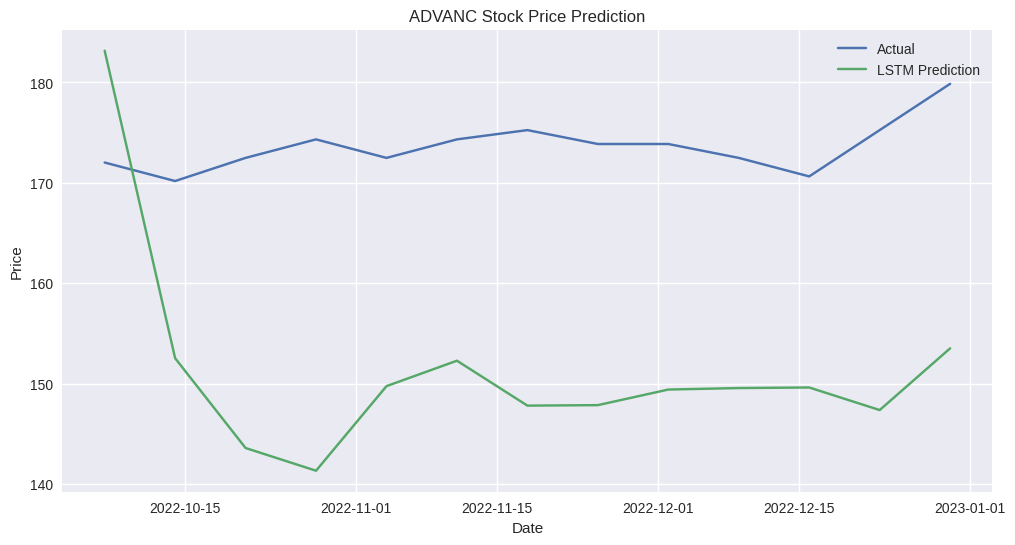

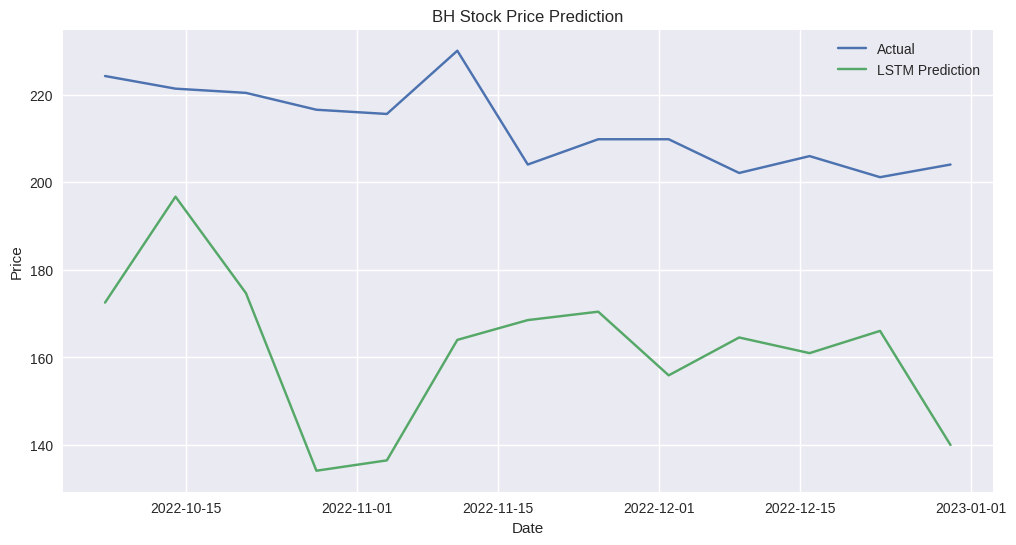

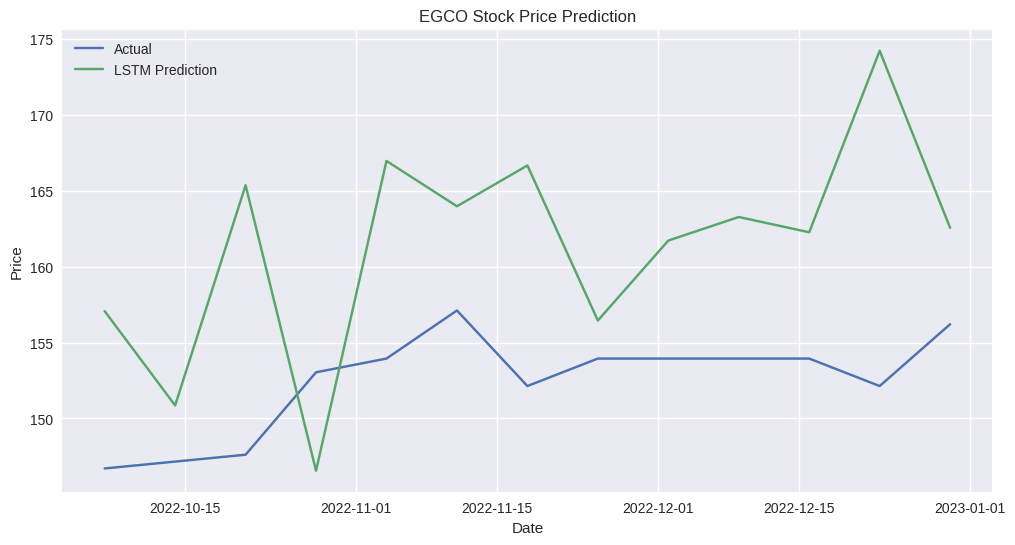

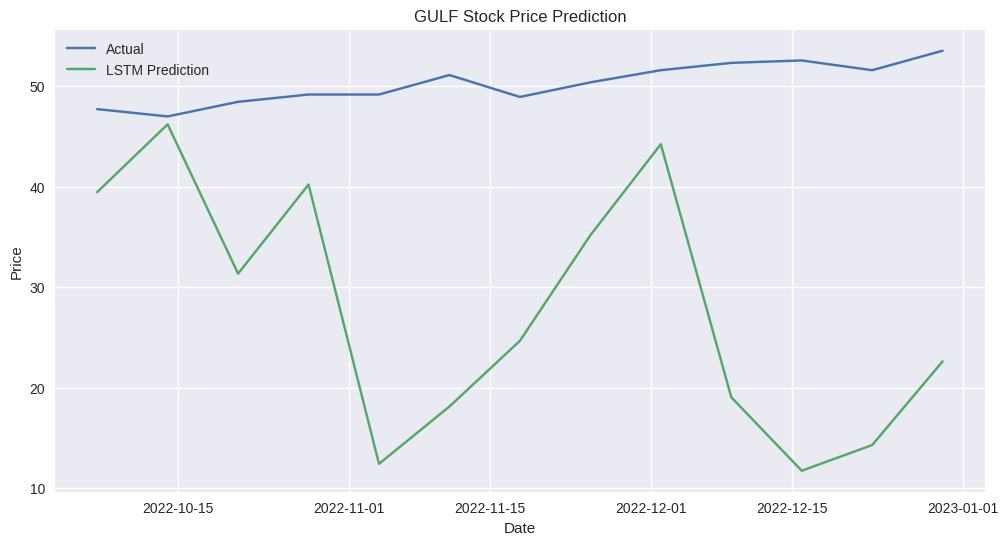

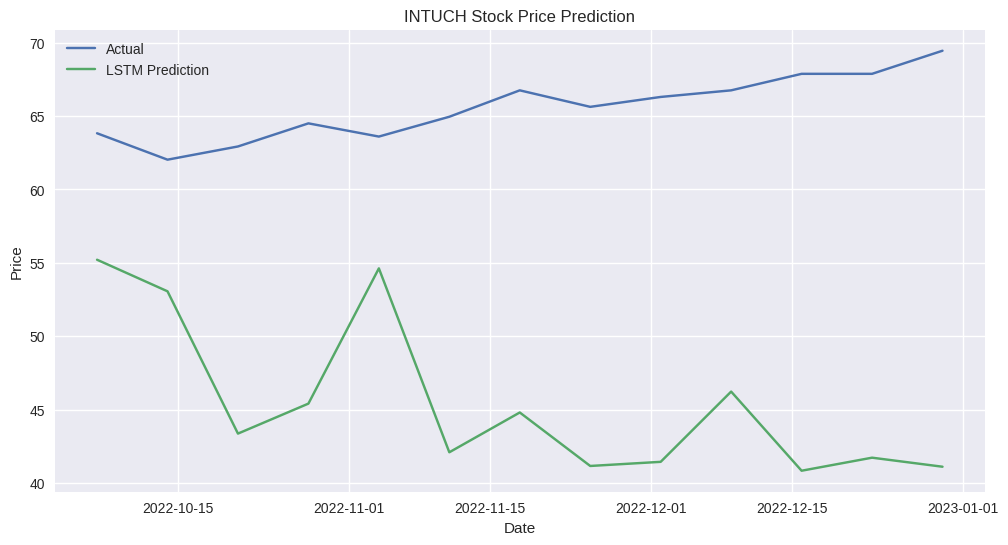

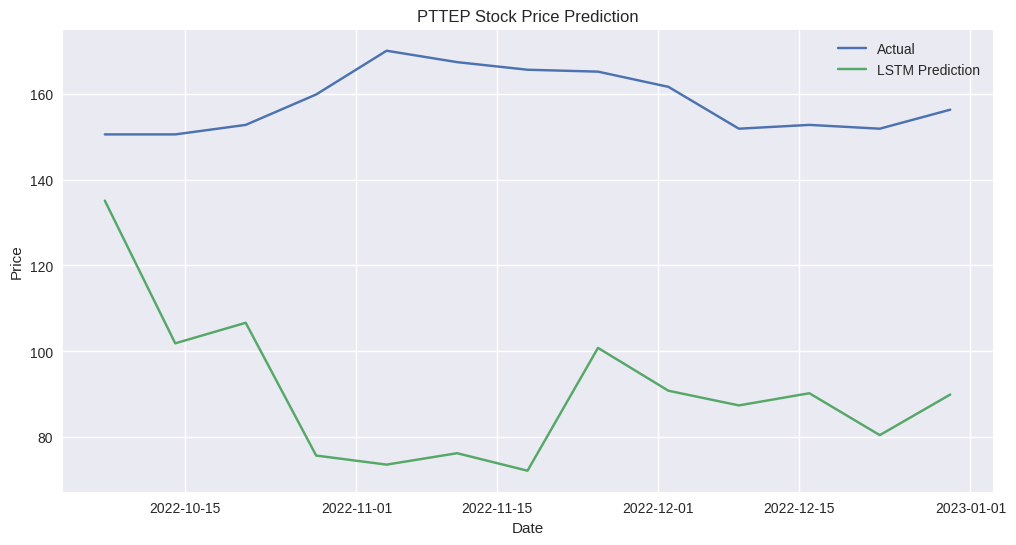

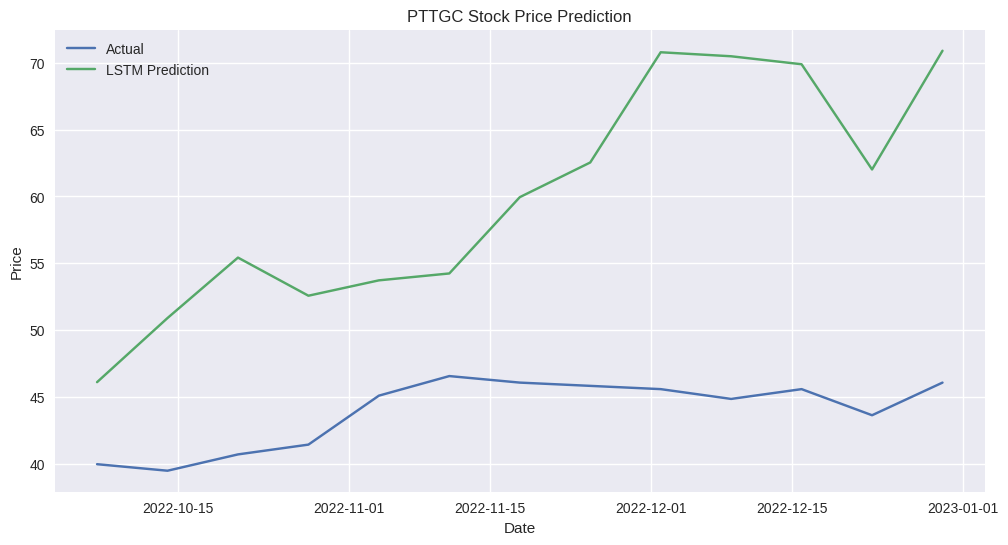

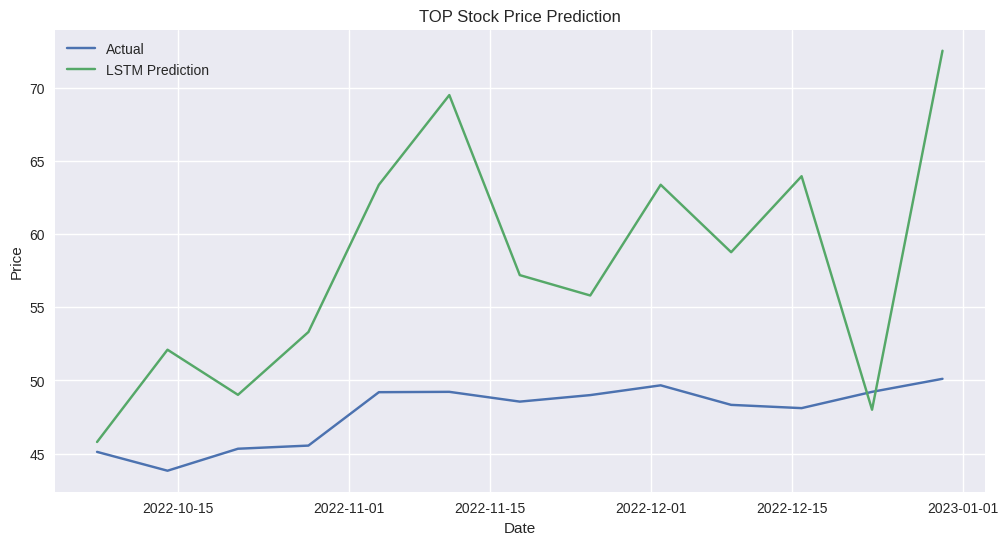

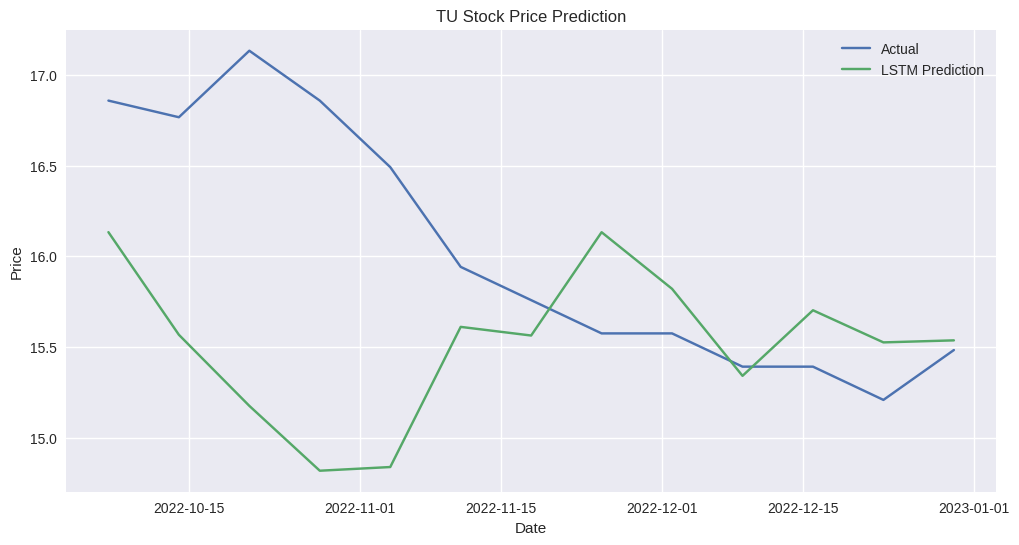

In [ ]:
# Combine the predicted prices and actual prices
combined_prices_lstm = pd.concat([predicted_prices_lstm, test_data], axis=1)
combined_prices_lstm.columns = [f'Predicted_{col}' if i < len(predicted_prices_lstm.columns) else f'Actual_{col}'
                                for i, col in enumerate(combined_prices_lstm.columns)]

print("Combined Prices (LSTM):")
print(combined_prices_lstm)

from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_lstm = predicted_directions_lstm.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_lstm = predicted_directions_lstm.dropna()
predicted_directions_lstm.index = predicted_directions_lstm.index.date

# Align both series to have the same length
predicted_directions_lstm = predicted_directions_lstm.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies_lstm = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_lstm[stock].values)
    all_accuracies_lstm.append(accuracy)
    print(f"LSTM Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall LSTM Model Accuracy: {np.mean(all_accuracies_lstm) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_lstm[stock].values)
    print(f"\nLSTM Confusion Matrix for {stock}:")
    print(conf_matrix)


# Visualize the predictions
import matplotlib.pyplot as plt

def plot_predictions(stock):
    plt.figure(figsize=(12, 6))
    plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Actual_{stock}'], label='Actual')
    plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Predicted_{stock}'], label='LSTM Prediction')
    plt.title(f'{stock} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot predictions for each stock
for stock in test_data.columns:
    plot_predictions(stock)

#lstm + volume  4 star (included in my thesis)

In [ ]:
def selectted_stocks(predicted_directions):
  selected_stocks={}
  for i in range(len(predicted_directions)):
    date_str = predicted_directions.index[i].strftime('%Y-%m-%d')
    selected_stocks[date_str] = predicted_directions.iloc[i][predicted_directions.iloc[i]==1].index.tolist()

  return selected_stocks


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# List of tickers
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']

# Define start and end date for historical data
start_date = '2017-12-08'
end_date = '2023-12-30'

# Download the adjusted close price data
df_price = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
df_price = df_price.resample('W-FRI').last()  # Resample to weekly data
df_price.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

# Download the volume data
df_volume = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Volume']
df_volume = df_volume.resample('W-FRI').last()  # Resample to weekly data
df_volume.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


In [ ]:
df_price

ADVANC          BH        EGCO       GULF  \
Date                                                                       
2017-12-08 00:00:00+00:00  136.462509  175.947464  170.262924  10.030400   
2017-12-15 00:00:00+00:00  142.612946  171.592316  169.485458   9.892996   
2017-12-22 00:00:00+00:00  142.997330  169.414764  173.372757  10.213603   
2017-12-29 00:00:00+00:00  146.841370  164.624115  167.930573  11.908237   
2018-01-05 00:00:00+00:00  149.916595  167.672714  167.930573  12.595250   
...                               ...         ...         ...        ...   
2023-12-01 00:00:00+00:00  209.930481  216.196136  120.347847  44.600224   
2023-12-08 00:00:00+00:00  210.889069  209.348297  118.926414  44.600224   
2023-12-15 00:00:00+00:00  210.889069  213.261337  117.978790  45.580448   
2023-12-22 00:00:00+00:00  211.847656  211.304825  120.347847  43.865055   
2023-12-29 00:00:00+00:00  208.013306  217.174408  121.295464  43.619999   

                              INTUCH       PTTEP      PTTGC        TOP  \
Date                                                                     
2017-12-08 00:00:00+00:00  39.609104   65.345444  64.348137  72.496758   
2017-12-15 00:00:00+00:00  39.609104   66.044327  65.326065  74.870705   
2017-12-22 00:00:00+00:00  39.969193   69.713455  66.695175  73.775024   
2017-12-29 00:00:00+00:00  40.509312   69.888168  66.499573  75.601143   
2018-01-05 00:00:00+00:00  41.409523   74.780342  70.606911  78.157692   
...                              ...         ...        ...        ...   
2023-12-01 00:00:00+00:00  67.220261  139.151657  37.754841  47.709446   
2023-12-08 00:00:00+00:00  66.505157  133.060852  38.000000  47.476715   
2023-12-15 00:00:00+00:00  66.743523  137.746094  38.490322  49.338547   
2023-12-22 00:00:00+00:00  67.697006  138.214600  37.754841  50.036736   
2023-12-29 00:00:00+00:00  68.173737  140.088699  37.754841  50.036736   

                                  TU  
Date                                  
2017-12-08 00:00:00+00:00  14.680014  
2017-12-15 00:00:00+00:00  14.529448  
2017-12-22 00:00:00+00:00  14.454167  
2017-12-29 00:00:00+00:00  14.981139  
2018-01-05 00:00:00+00:00  15.658679  
...                              ...  
2023-12-01 00:00:00+00:00  14.260377  
2023-12-08 00:00:00+00:00  14.549439  
2023-12-15 00:00:00+00:00  14.453085  
2023-12-22 00:00:00+00:00  13.874961  
2023-12-29 00:00:00+00:00  14.453085  

[317 rows x 9 columns]

In [ ]:
# Updated function to prepare data for LSTM with separate scalers for price and volume
def prepare_data_for_lstm(data_price, data_volume, look_back):
    # Define scalers for price and volume
    scaler_price = MinMaxScaler(feature_range=(0, 1))
    scaler_volume = MinMaxScaler(feature_range=(0, 1))

    # Scale price and volume independently
    scaled_price = scaler_price.fit_transform(data_price.values.reshape(-1, 1))
    scaled_volume = scaler_volume.fit_transform(data_volume.values.reshape(-1, 1))

    # Combine scaled price and volume into one dataset
    scaled_data = np.hstack((scaled_price, scaled_volume))

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back), :])  # Lagged price and volume
        y.append(scaled_price[i + look_back, 0])  # Target is the future price

    return np.array(X), np.array(y), scaler_price, scaler_volume


# Function to create LSTM model with two hidden LSTM layers
def create_lstm_model(look_back):
    model = Sequential()
    model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
    model.add(LSTM(units=50, return_sequences=True))  # First LSTM layer with 107 units
    model.add(LSTM(units=20))  # Second LSTM layer with 79 units
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

# Updated forecast function to handle separate scalers
def forecast_stocks_lstm(data_price, data_volume, forecast_horizon=1, look_back=10, epochs=50, batch_size=32):
    forecasted_prices = {}
    directions = {}

    for column in data_price.columns:
        # Prepare data for LSTM using the modified function
        X, y, scaler_price, scaler_volume = prepare_data_for_lstm(data_price[column], data_volume[column], look_back)
        X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: price and volume

        # Create and train the LSTM model
        model = create_lstm_model(look_back)
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Prepare the last 'look_back' days for forecasting
        last_look_back_days_price = data_price[column].iloc[-look_back:].values.reshape(-1, 1)
        last_look_back_days_volume = data_volume[column].iloc[-look_back:].values.reshape(-1, 1)

        # Scale last 'look_back' days data separately for each feature
        last_look_back_days_scaled_price = scaler_price.transform(last_look_back_days_price)
        last_look_back_days_scaled_volume = scaler_volume.transform(last_look_back_days_volume)
        last_look_back_days_combined = np.hstack((last_look_back_days_scaled_price, last_look_back_days_scaled_volume))
        X_forecast = last_look_back_days_combined.reshape(1, look_back, 2)  # 2 features

        # Forecast
        forecast_scaled = model.predict(X_forecast)
        forecast = scaler_price.inverse_transform(forecast_scaled)[0][0]  # Inverse transform with price scaler

        # Store forecasted price
        forecasted_prices[column] = forecast

        # Determine direction: 1 for up, -1 for down
        last_actual_price = data_price[column].iloc[-1]
        direction = 1 if forecast > last_actual_price else -1
        directions[column] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

# The rest of the code remains the same
# Initialize variables
initial_train_end = '2022-09-30'
full_train_data_price = df_price[df_price.index <= initial_train_end]
full_train_data_volume = df_volume[df_volume.index <= initial_train_end]
test_data = df_price[(df_price.index > initial_train_end) & (df_price.index <= '2022-12-31')]

# DataFrames to store both forecasted prices and directions
predicted_prices_lstm = pd.DataFrame(index=test_data.index, columns=df_price.columns)
predicted_directions_lstm = pd.DataFrame(index=test_data.index, columns=df_price.columns)

# Loop over each week in the test set
for i in range(len(test_data)):
    test_week_price = df_price.iloc[i:i+1]
    test_week_volume = df_volume.iloc[i:i+1]
    current_date = test_data.index[i]

    # Forecast prices and directions using LSTM (price + volume)
    forecasts, directions = forecast_stocks_lstm(full_train_data_price, full_train_data_volume)

    # Store forecasted prices and directions
    predicted_prices_lstm.loc[current_date] = forecasts
    predicted_directions_lstm.loc[current_date] = directions

    # Add the actual prices and volumes of the current test week to the training data
    full_train_data_price = pd.concat([full_train_data_price, test_week_price])
    full_train_data_volume = pd.concat([full_train_data_volume, test_week_volume])

# Output results
print("Predicted Prices:\n", predicted_prices_lstm)
print("Predicted Directions:\n", predicted_directions_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:




# # Function to prepare data for LSTM (price + volume)
# def prepare_data_for_lstm(data_price, data_volume, look_back):
#     # Combine price and volume into one DataFrame
#     data_combined = pd.concat([data_price, data_volume], axis=1)

#     # Scale both price and volume
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled_data = scaler.fit_transform(data_combined)

#     X, y = [], []
#     for i in range(len(scaled_data) - look_back):
#         X.append(scaled_data[i:(i + look_back), :])  # Lagged price and volume
#         y.append(scaled_data[i + look_back, 0])  # Target is the future price

#     return np.array(X), np.array(y), scaler


# # Function to create LSTM model with two hidden LSTM layers
# def create_lstm_model(look_back):
#     model = Sequential()
#     model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
#     model.add(LSTM(units=10, return_sequences=True))  # First LSTM layer with 107 units
#     model.add(LSTM(units=5))  # Second LSTM layer with 79 units
#     model.add(Dense(units=1))  # Output layer for regression
#     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
#     return model

# # # Function to create LSTM model with two inputs (price + volume)
# # def create_lstm_model(look_back):
# #     model = Sequential()
# #     model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
# #     model.add(LSTM(units=79))  # LSTM layer with 3 neurons
# #     model.add(Dense(units=1))  # Output layer
# #     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
# #     return model

# # Function to forecast stocks using LSTM (price + volume)
# def forecast_stocks_lstm(data_price, data_volume, forecast_horizon=1, look_back=10, epochs=50, batch_size=32):
#     forecasted_prices = {}
#     directions = {}

#     for column in data_price.columns:
#         X, y, scaler = prepare_data_for_lstm(data_price[column], data_volume[column], look_back)
#         X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: price and volume

#         model = create_lstm_model(look_back)
#         model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

#         # Prepare the last 'look_back' days for forecasting
#         last_look_back_days_price = data_price[column].iloc[-look_back:].values.reshape(-1, 1)
#         last_look_back_days_volume = data_volume[column].iloc[-look_back:].values.reshape(-1, 1)
#         last_look_back_days_combined = np.concatenate([last_look_back_days_price, last_look_back_days_volume], axis=1)

#         last_look_back_days_scaled = scaler.transform(last_look_back_days_combined)
#         X_forecast = last_look_back_days_scaled.reshape(1, look_back, 2)  # 2 features

#         # Forecast
#         forecast_scaled = model.predict(X_forecast)
#         forecast = scaler.inverse_transform(np.concatenate([forecast_scaled, np.zeros((1, 1))], axis=1))[0][0]

#         # Store forecasted price
#         forecasted_prices[column] = forecast

#         # Determine direction: 1 for up, -1 for down
#         last_actual_price = data_price[column].iloc[-1]
#         direction = 1 if forecast > last_actual_price else -1
#         directions[column] = direction

#     return pd.Series(forecasted_prices), pd.Series(directions)

# # Initialize variables
# initial_train_end = '2022-09-30'
# full_train_data_price = df_price[df_price.index <= initial_train_end]
# full_train_data_volume = df_volume[df_volume.index <= initial_train_end]
# test_data = df_price[(df_price.index > initial_train_end) & (df_price.index <= '2022-12-31')]

# # DataFrames to store both forecasted prices and directions
# predicted_prices_lstm = pd.DataFrame(index=test_data.index, columns=df_price.columns)
# predicted_directions_lstm = pd.DataFrame(index=test_data.index, columns=df_price.columns)

# # Loop over each week in the test set
# for i in range(len(test_data)):
#     test_week_price = df_price.iloc[i:i+1]
#     test_week_volume = df_volume.iloc[i:i+1]
#     current_date = test_data.index[i]

#     # Forecast prices and directions using LSTM (price + volume)
#     forecasts, directions = forecast_stocks_lstm(full_train_data_price, full_train_data_volume)

#     # Store forecasted prices and directions
#     predicted_prices_lstm.loc[current_date] = forecasts
#     predicted_directions_lstm.loc[current_date] = directions

#     # Add the actual prices and volumes of the current test week to the training data
#     full_train_data_price = pd.concat([full_train_data_price, test_week_price])
#     full_train_data_volume = pd.concat([full_train_data_volume, test_week_volume])



In [ ]:
predicted_directions_lstm

ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
Date                                                                     
2022-10-07 00:00:00+00:00      1   1    1    1      1    -1     1   1  -1
2022-10-14 00:00:00+00:00      1  -1   -1    1      1     1    -1  -1  -1
2022-10-21 00:00:00+00:00     -1  -1    1    1     -1    -1     1  -1   1
2022-10-28 00:00:00+00:00     -1  -1    1    1     -1     1    -1  -1   1
2022-11-04 00:00:00+00:00     -1   1   -1    1      1     1    -1  -1  -1
2022-11-11 00:00:00+00:00     -1   1    1    1      1     1    -1   1  -1
2022-11-18 00:00:00+00:00      1  -1   -1    1      1     1     1  -1   1
2022-11-25 00:00:00+00:00      1   1   -1    1      1     1    -1  -1   1
2022-12-02 00:00:00+00:00      1   1    1    1      1     1     1   1   1
2022-12-09 00:00:00+00:00     -1  -1    1    1      1     1     1   1  -1
2022-12-16 00:00:00+00:00      1   1    1   -1      1     1    -1  -1   1
2022-12-23 00:00:00+00:00      1  -1   -1   -1      1    -1     1  -1   1
2022-12-30 00:00:00+00:00     -1  -1    1   -1      1     1     1  -1  -1

In [ ]:
predicted_prices_lstm

ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07   180.89859  218.665207  154.747086  51.229458  66.496262   
2022-10-14   145.28508  154.129471  163.317276  37.988754  48.766762   
2022-10-21  141.649689  158.792358   169.58931   14.01988  38.616207   
2022-10-28   141.66095  161.838089  174.009415   10.74225  39.609978   
2022-11-04   145.01976  164.671799  166.887878  12.399687  41.003883   
2022-11-11  146.990677  170.199249  170.247574  13.955199   42.36105   
2022-11-18  148.422623  167.619659  168.863342  15.778036  43.255772   
2022-11-25  149.339005  174.181183  167.615677  15.308383  42.479229   
2022-12-02  151.526779  172.474564  171.983704  13.531286  42.128948   
2022-12-09  149.397415   175.25119  173.032684  14.429046  42.402592   
2022-12-16  149.219635  175.313583  170.398071  13.026011  41.440624   
2022-12-23  150.170883  178.942795  182.629593  12.671062  41.872673   
2022-12-30  148.793777   178.18219  186.247482  13.083488   42.07526   

                 PTTEP      PTTGC        TOP         TU  
2022-10-07  140.912857  41.253036  44.125816  16.906544  
2022-10-14   70.783501  49.870201  60.554714  14.495161  
2022-10-21    63.67696  67.072411   72.76165  14.812712  
2022-10-28   72.582901  65.856911  69.402496  14.474788  
2022-11-04   72.234055   64.70372  75.431618  14.784837  
2022-11-11   79.013359  68.011024  79.391243  15.575967  
2022-11-18   82.207985  74.141953   73.18029  15.880922  
2022-11-25   84.354187  73.267113  71.759903  15.717037  
2022-12-02   85.745445  78.009766   77.09124  15.830525  
2022-12-09   87.959282  75.363228  75.968185  15.049007  
2022-12-16   84.585892   70.86628  71.144791   15.53021  
2022-12-23   78.860672  74.312317  71.690338  15.303081  
2022-12-30     84.0746  74.645859  71.821075  14.926985

In [ ]:
# Print results
print("LSTM Predicted Prices:")
print(predicted_prices_lstm)
print("LSTM Predicted Directions:")
print(predicted_directions_lstm)
selected_stocks_lstm = selectted_stocks(predicted_directions_lstm)
print("Selected Stocks (LSTM):")
print(selected_stocks_lstm)

LSTM Predicted Prices:
                ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07   180.89859  218.665207  154.747086  51.229458  66.496262   
2022-10-14   145.28508  154.129471  163.317276  37.988754  48.766762   
2022-10-21  141.649689  158.792358   169.58931   14.01988  38.616207   
2022-10-28   141.66095  161.838089  174.009415   10.74225  39.609978   
2022-11-04   145.01976  164.671799  166.887878  12.399687  41.003883   
2022-11-11  146.990677  170.199249  170.247574  13.955199   42.36105   
2022-11-18  148.422623  167.619659  168.863342  15.778036  43.255772   
2022-11-25  149.339005  174.181183  167.615677  15.308383  42.479229   
2022-12-02  151.526779  172.474564  171.983704  13.531286  42.128948   
2022-12-09  149.397415   175.25119  173.032684  14.429046  42.402592   
2022-12-16  149.219635  175.313583  170.398071  13.026011  41.440624   
2022-12-23  150.170883  178.942795  182.629593  12.671062  41.872673   
2022-12-30  148.793777   178.18219  186.2

In [ ]:
test_data.index=test_data.index.date

In [ ]:
test_data

ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07  172.024826  224.268814  146.702072  47.724342  63.824615   
2022-10-14  170.180054  221.381210  147.154846  46.997574  62.026745   
2022-10-21  172.486023  220.418701  147.607635  48.451107  62.925678   
2022-10-28  174.330780  216.568588  153.041061  49.177876  64.498810   
2022-11-04  172.486023  215.606079  153.946609  49.177876  63.599884   
2022-11-11  174.330780  230.043991  157.116104  51.115917  64.948296   
2022-11-18  175.253174  204.055740  152.135483  48.935619  66.746162   
2022-11-25  173.869583  209.830902  153.946609  50.389153  65.622490   
2022-12-02  173.869583  209.830902  153.946609  51.600430  66.296692   
2022-12-09  172.486023  202.130692  153.946609  52.327198  66.746162   
2022-12-16  170.641235  205.980804  153.946609  52.569450  67.869835   
2022-12-23  175.253174  201.168152  152.135483  51.600430  67.869835   
2022-12-30  179.865097  204.055740  156.210510  53.538475  69.442978   

                 PTTEP      PTTGC        TOP         TU  
2022-10-07  150.516144  39.994839  45.114910  16.858240  
2022-10-14  150.516144  39.507099  43.825916  16.766617  
2022-10-21  152.729630  40.726452  45.329742  17.133101  
2022-10-28  159.812729  41.458069  45.544579  16.858240  
2022-11-04  169.994705  45.116131  49.196739  16.491756  
2022-11-11  167.338547  46.579357  49.220390  15.942032  
2022-11-18  165.567780  46.091614  48.552238  15.758788  
2022-11-25  165.125076  45.847744  48.997673  15.575547  
2022-12-02  161.583496  45.603874  49.665821  15.575547  
2022-12-09  151.844238  44.872261  48.329525  15.392305  
2022-12-16  152.729630  45.603874  48.106808  15.392305  
2022-12-23  151.844238  43.652905  49.220390  15.209064  
2022-12-30  156.271179  46.091614  50.111256  15.483927

In [ ]:
# Combine the predicted prices and actual prices
combined_prices_lstm = pd.concat([predicted_prices_lstm, test_data], axis=1)
combined_prices_lstm.columns = [f'Predicted_{col}' if i < len(predicted_prices_lstm.columns) else f'Actual_{col}'
                                for i, col in enumerate(combined_prices_lstm.columns)]

print("Combined Prices (LSTM):")
print(combined_prices_lstm)

Combined Prices (LSTM):
           Predicted_ADVANC Predicted_BH Predicted_EGCO Predicted_GULF  \
2022-10-07        180.89859   218.665207     154.747086      51.229458   
2022-10-14        145.28508   154.129471     163.317276      37.988754   
2022-10-21       141.649689   158.792358      169.58931       14.01988   
2022-10-28        141.66095   161.838089     174.009415       10.74225   
2022-11-04        145.01976   164.671799     166.887878      12.399687   
2022-11-11       146.990677   170.199249     170.247574      13.955199   
2022-11-18       148.422623   167.619659     168.863342      15.778036   
2022-11-25       149.339005   174.181183     167.615677      15.308383   
2022-12-02       151.526779   172.474564     171.983704      13.531286   
2022-12-09       149.397415    175.25119     173.032684      14.429046   
2022-12-16       149.219635   175.313583     170.398071      13.026011   
2022-12-23       150.170883   178.942795     182.629593      12.671062   
2022-12-30    

In [ ]:
import pandas as pd

# Convert the index to datetime objects if it's not already
actual_directions.index = pd.to_datetime(actual_directions.index)

# Remove the time component by converting to date objects
actual_directions.index = actual_directions.index.date

In [ ]:
actual_directions

ADVANC  BH  EGCO  GULF  INTUCH  PTTEP  PTTGC  TOP  TU
2022-10-07      -1   1    -1    -1      -1      1     -1    1  -1
2022-10-14      -1  -1     1    -1      -1     -1     -1   -1  -1
2022-10-21       1  -1     1     1       1      1      1    1   1
2022-10-28       1  -1     1     1       1      1      1    1  -1
2022-11-04      -1  -1     1    -1      -1      1      1    1  -1
2022-11-11       1   1     1     1       1     -1      1    1  -1
2022-11-18       1  -1    -1    -1       1     -1     -1   -1  -1
2022-11-25      -1   1     1     1      -1     -1     -1    1  -1
2022-12-02      -1  -1    -1     1       1     -1     -1    1  -1
2022-12-09      -1  -1    -1     1       1     -1     -1   -1  -1
2022-12-16      -1   1    -1     1       1      1      1   -1  -1
2022-12-23       1  -1    -1    -1      -1     -1     -1    1  -1
2022-12-30       1   1     1     1       1      1      1    1   1

In [ ]:
predicted_directions_lstm

ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2022-10-07      1   1    1    1      1    -1     1   1  -1
2022-10-14      1  -1   -1    1      1     1    -1  -1  -1
2022-10-21     -1  -1    1    1     -1    -1     1  -1   1
2022-10-28     -1  -1    1    1     -1     1    -1  -1   1
2022-11-04     -1   1   -1    1      1     1    -1  -1  -1
2022-11-11     -1   1    1    1      1     1    -1   1  -1
2022-11-18      1  -1   -1    1      1     1     1  -1   1
2022-11-25      1   1   -1    1      1     1    -1  -1   1
2022-12-02      1   1    1    1      1     1     1   1   1
2022-12-09     -1  -1    1    1      1     1     1   1  -1
2022-12-16      1   1    1   -1      1     1    -1  -1   1
2022-12-23      1  -1   -1   -1      1    -1     1  -1   1
2022-12-30     -1  -1    1   -1      1     1     1  -1  -1

In [ ]:
import pandas as pd


In [ ]:
predicted_directions_lstm.index = pd.to_datetime(predicted_directions_lstm.index).date

In [ ]:
predicted_directions_lstm.index

Index([2022-10-07, 2022-10-14, 2022-10-21, 2022-10-28, 2022-11-04, 2022-11-11,
       2022-11-18, 2022-11-25, 2022-12-02, 2022-12-09, 2022-12-16, 2022-12-23,
       2022-12-30],
      dtype='object')

In [ ]:


# from sklearn.metrics import accuracy_score, confusion_matrix

# # Ensure correct data types
# actual_directions = actual_directions.astype(int)
# predicted_directions_lstm = predicted_directions_lstm.astype(int)

# # Check for NaN values
# actual_directions = actual_directions.dropna()
# predicted_directions_lstm = predicted_directions_lstm.dropna()
# #predicted_directions_lstm.index = predicted_directions_lstm.index.date

# # Align both series to have the same length
# predicted_directions_lstm = predicted_directions_lstm.loc[actual_directions.index]

# # Calculate accuracy for each stock and overall accuracy
# all_accuracies_lstm = []
# for stock in actual_directions.columns:
#     accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_lstm[stock].values)
#     all_accuracies_lstm.append(accuracy)
#     print(f"LSTM Accuracy for {stock}: {accuracy * 100:.2f}%")

# print(f"Overall LSTM Model Accuracy: {np.mean(all_accuracies_lstm) * 100:.2f}%")

# # Calculate and print confusion matrix for each stock
# for stock in actual_directions.columns:
#     conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_lstm[stock].values)
#     print(f"\nLSTM Confusion Matrix for {stock}:")
#     print(conf_matrix)


# # Visualize the predictions
# import matplotlib.pyplot as plt

# def plot_predictions(stock):
#     plt.figure(figsize=(12, 6))
#     plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Actual_{stock}'], label='Actual')
#     plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Predicted_{stock}'], label='LSTM Prediction')
#     plt.title(f'{stock} Stock Price Prediction')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()

# # Plot predictions for each stock
# for stock in test_data.columns:
#     plot_predictions(stock)

LSTM Accuracy for ADVANC: 30.77%
LSTM Accuracy for BH: 76.92%
LSTM Accuracy for EGCO: 46.15%
LSTM Accuracy for GULF: 53.85%
LSTM Accuracy for INTUCH: 46.15%
LSTM Accuracy for PTTEP: 38.46%
LSTM Accuracy for PTTGC: 30.77%
LSTM Accuracy for TOP: 46.15%
LSTM Accuracy for TU: 46.15%
Overall LSTM Model Accuracy: 46.15%

LSTM Confusion Matrix for ADVANC:
[[2 5]
 [4 2]]

LSTM Confusion Matrix for BH:
[[6 2]
 [1 4]]

LSTM Confusion Matrix for EGCO:
[[2 4]
 [3 4]]

LSTM Confusion Matrix for GULF:
[[1 4]
 [2 6]]

LSTM Confusion Matrix for INTUCH:
[[0 5]
 [2 6]]

LSTM Confusion Matrix for PTTEP:
[[1 6]
 [2 4]]

LSTM Confusion Matrix for PTTGC:
[[2 5]
 [4 2]]

LSTM Confusion Matrix for TOP:
[[3 1]
 [6 3]]

LSTM Confusion Matrix for TU:
[[5 6]
 [1 1]]


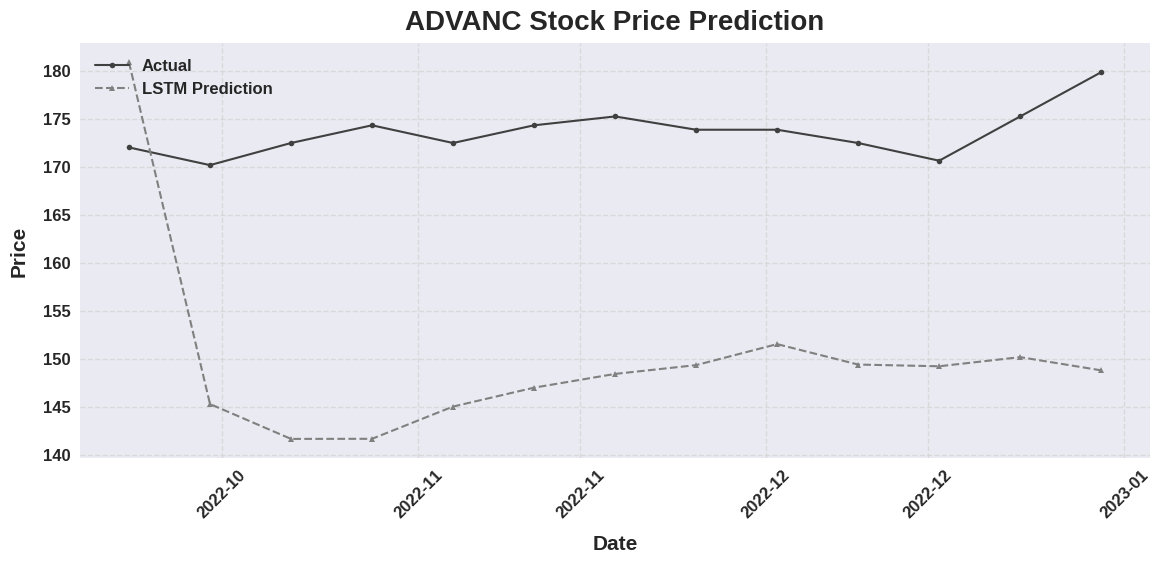

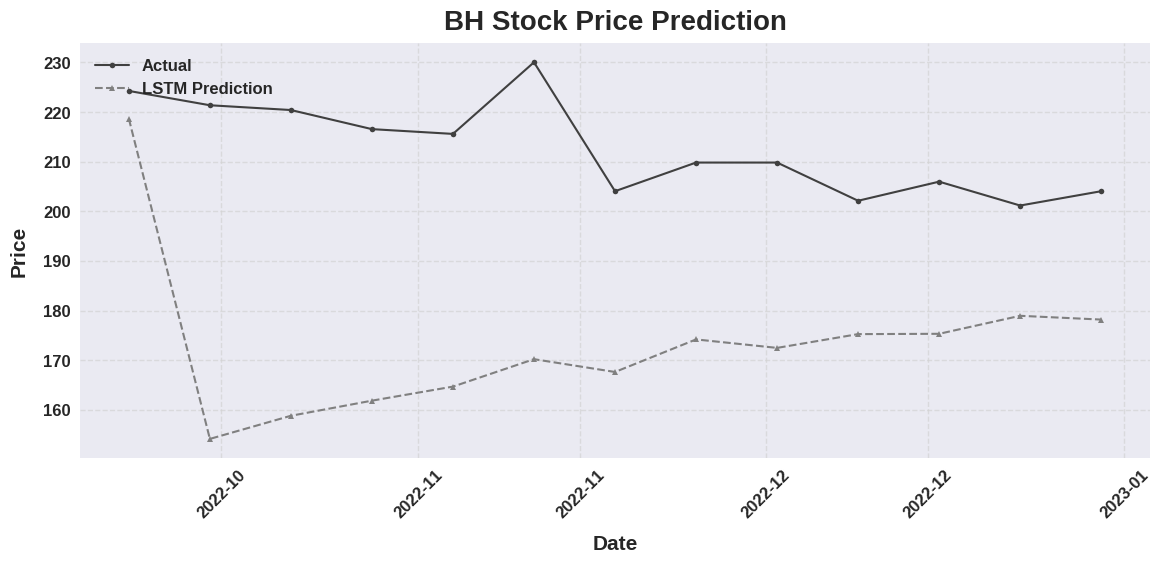

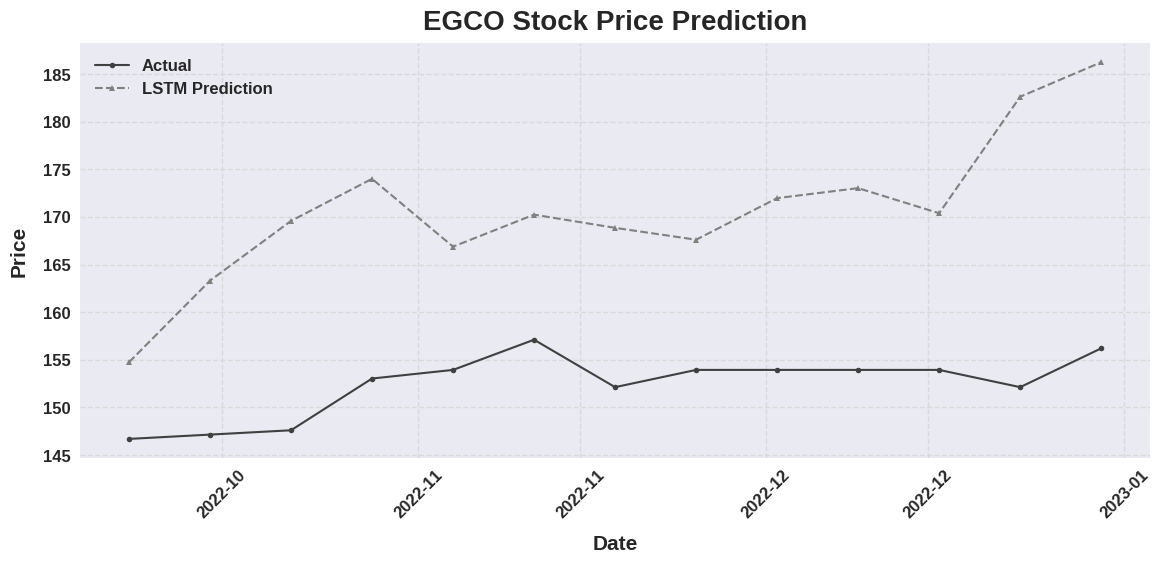

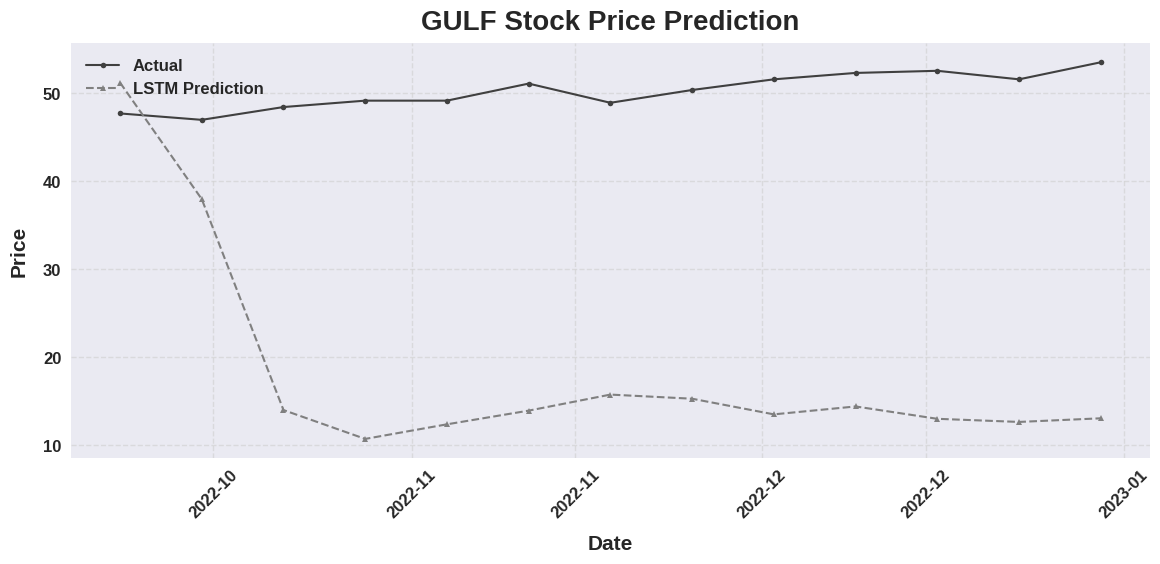

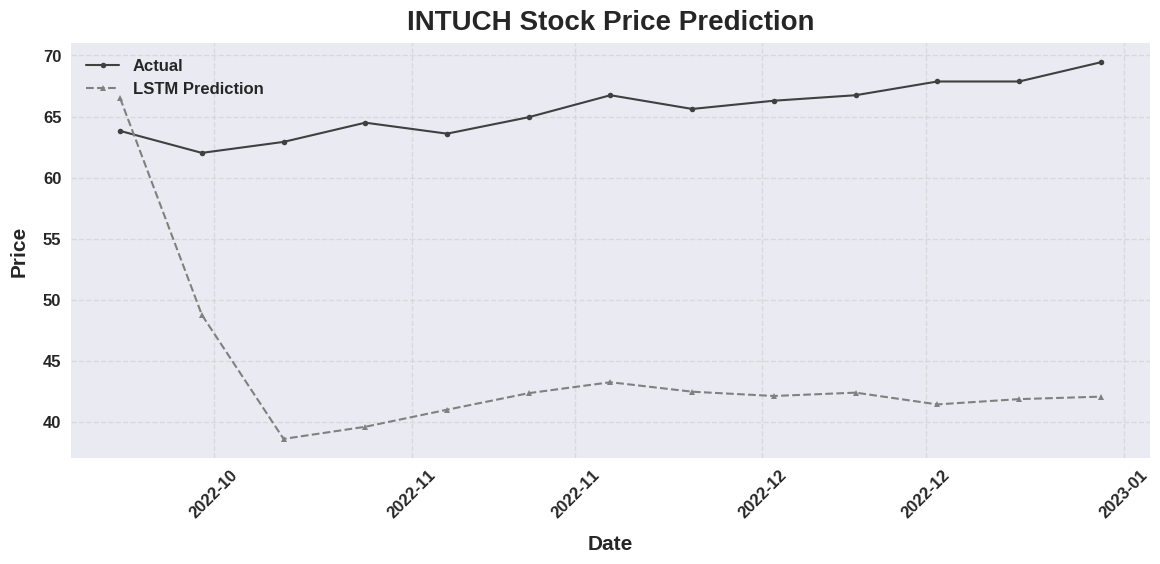

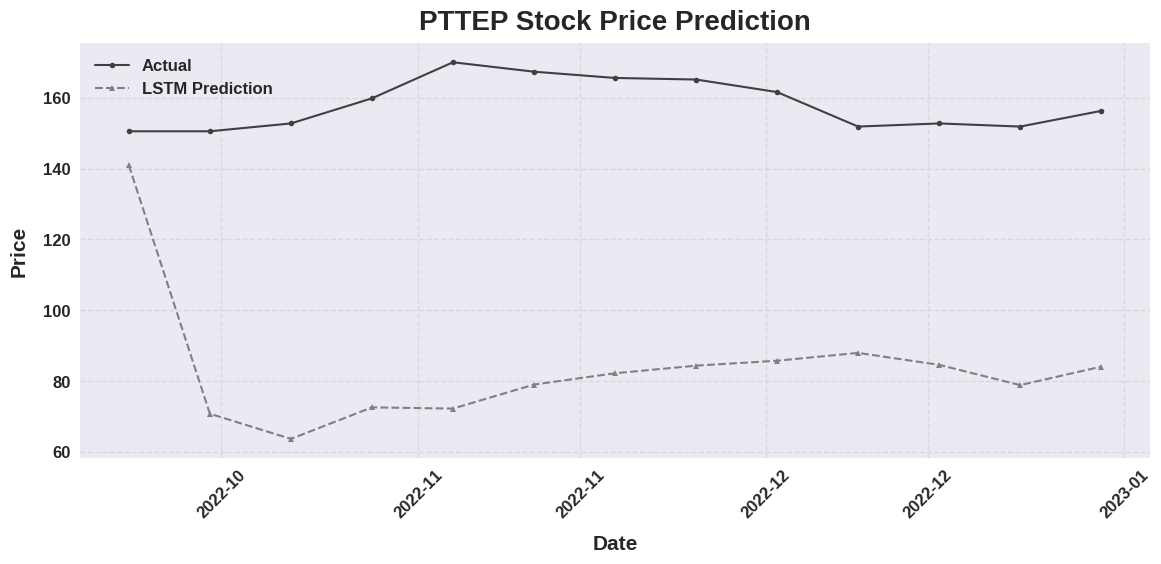

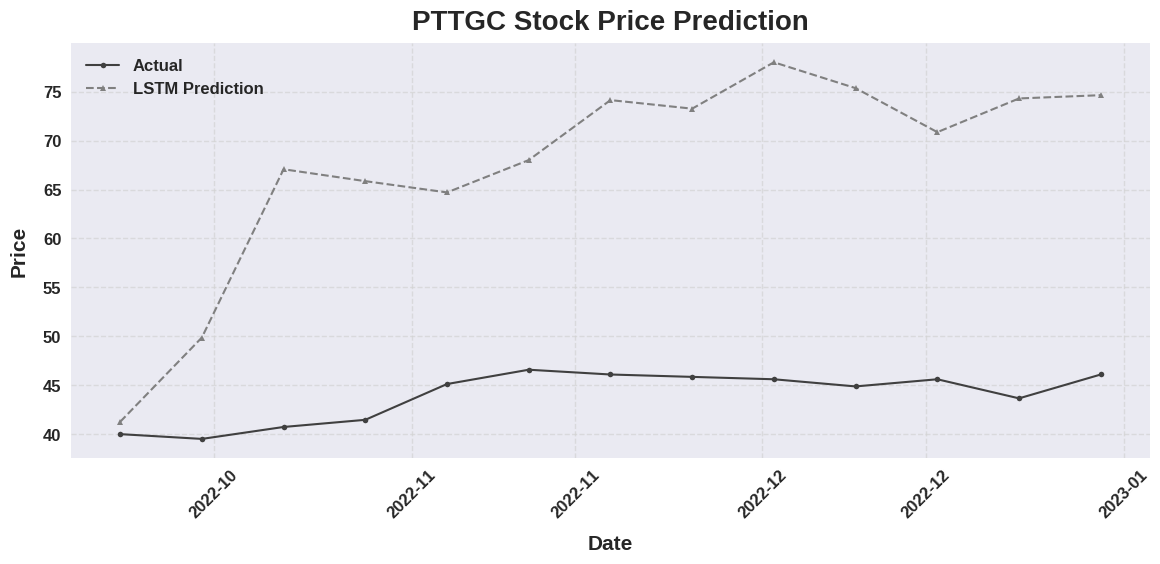

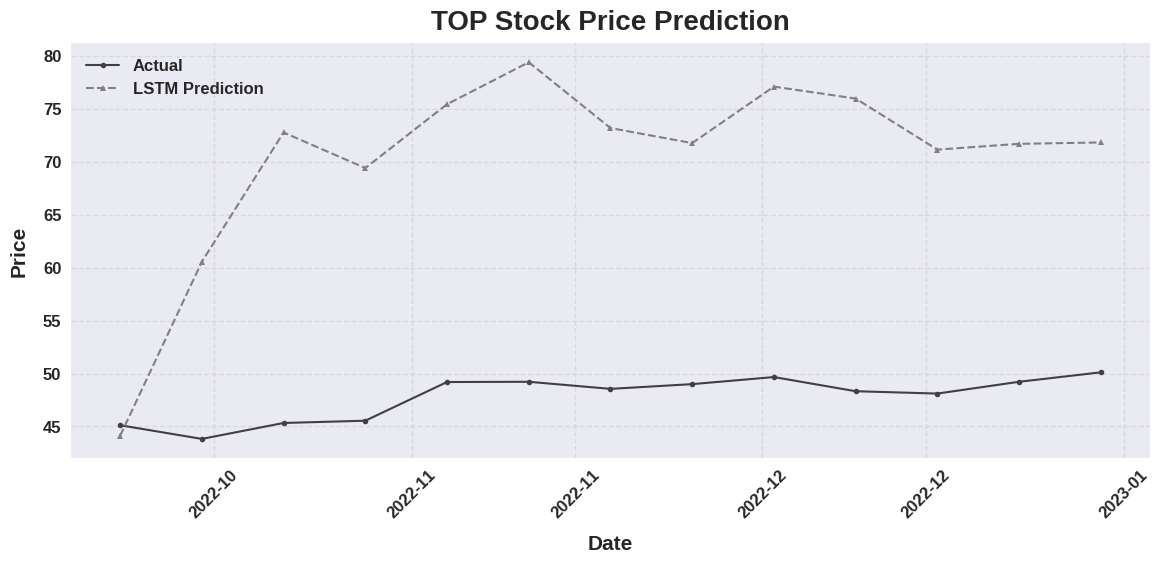

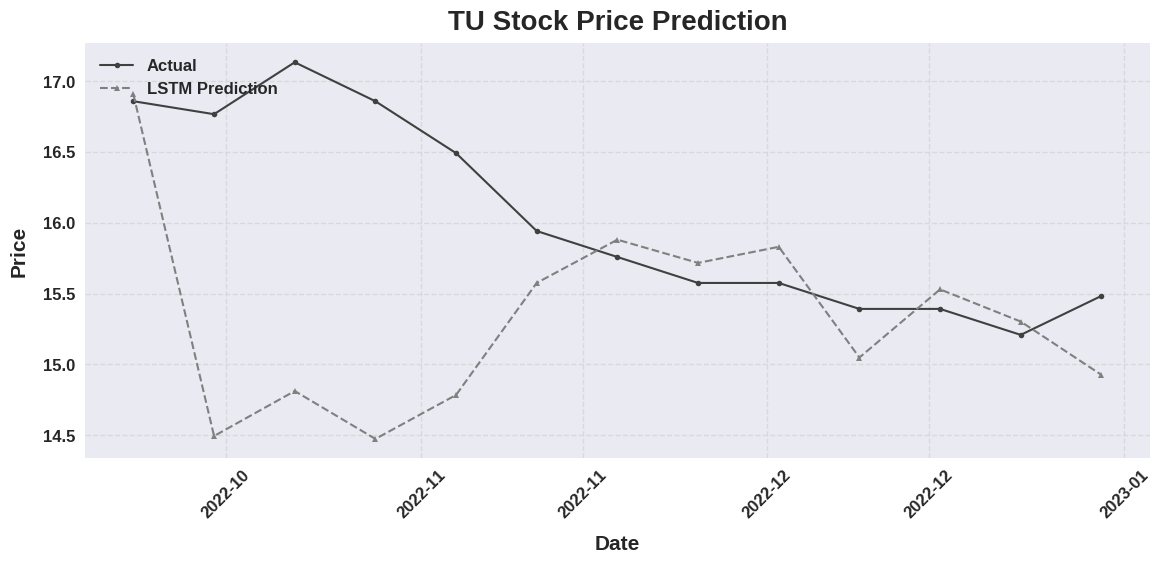

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_lstm = predicted_directions_lstm.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_lstm = predicted_directions_lstm.dropna()

# Align both series to have the same length
predicted_directions_lstm = predicted_directions_lstm.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies_lstm = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_lstm[stock].values)
    all_accuracies_lstm.append(accuracy)
    print(f"LSTM Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall LSTM Model Accuracy: {np.mean(all_accuracies_lstm) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_lstm[stock].values)
    print(f"\nLSTM Confusion Matrix for {stock}:")
    print(conf_matrix)


# Function to visualize predictions with a custom style
def plot_predictions(stock):
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(12, 6))

    # Define gray color palette
    colors = ['#404040', '#808080']  # Dark gray for actual, medium gray for forecasted

    # Plot actual vs. predicted prices
    plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Actual_{stock}'],
             label='Actual', color=colors[0], marker='o', markersize=4, linestyle='-', linewidth=1.5)
    plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Predicted_{stock}'],
             label='LSTM Prediction', color=colors[1], marker='^', markersize=4, linestyle='--', linewidth=1.5)

    # Customize title and labels with bold fonts
    plt.title(f'{stock} Stock Price Prediction', pad=10, fontsize=20, fontweight='bold')
    plt.xlabel('Date', labelpad=10, fontsize=15, fontweight='bold')
    plt.ylabel('Price', labelpad=10, fontsize=15, fontweight='bold')

    # Customize x-axis
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Add grid with light gray color
    plt.grid(True, linestyle='--', alpha=0.7, color='#D3D3D3')

    # Add legend with custom position, bold font, and increased size
    legend = plt.legend(loc='upper left', frameon=False, fontsize=12)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    # Make x-tick labels bold
    for text in plt.gca().get_xticklabels():
        text.set_fontweight('bold')
        text.set_fontsize(12)

    # Make y-tick labels bold
    for text in plt.gca().get_yticklabels():
        text.set_fontweight('bold')
        text.set_fontsize(12)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    plt.show()

# Plot predictions for each stock
for stock in test_data.columns:
    plot_predictions(stock)


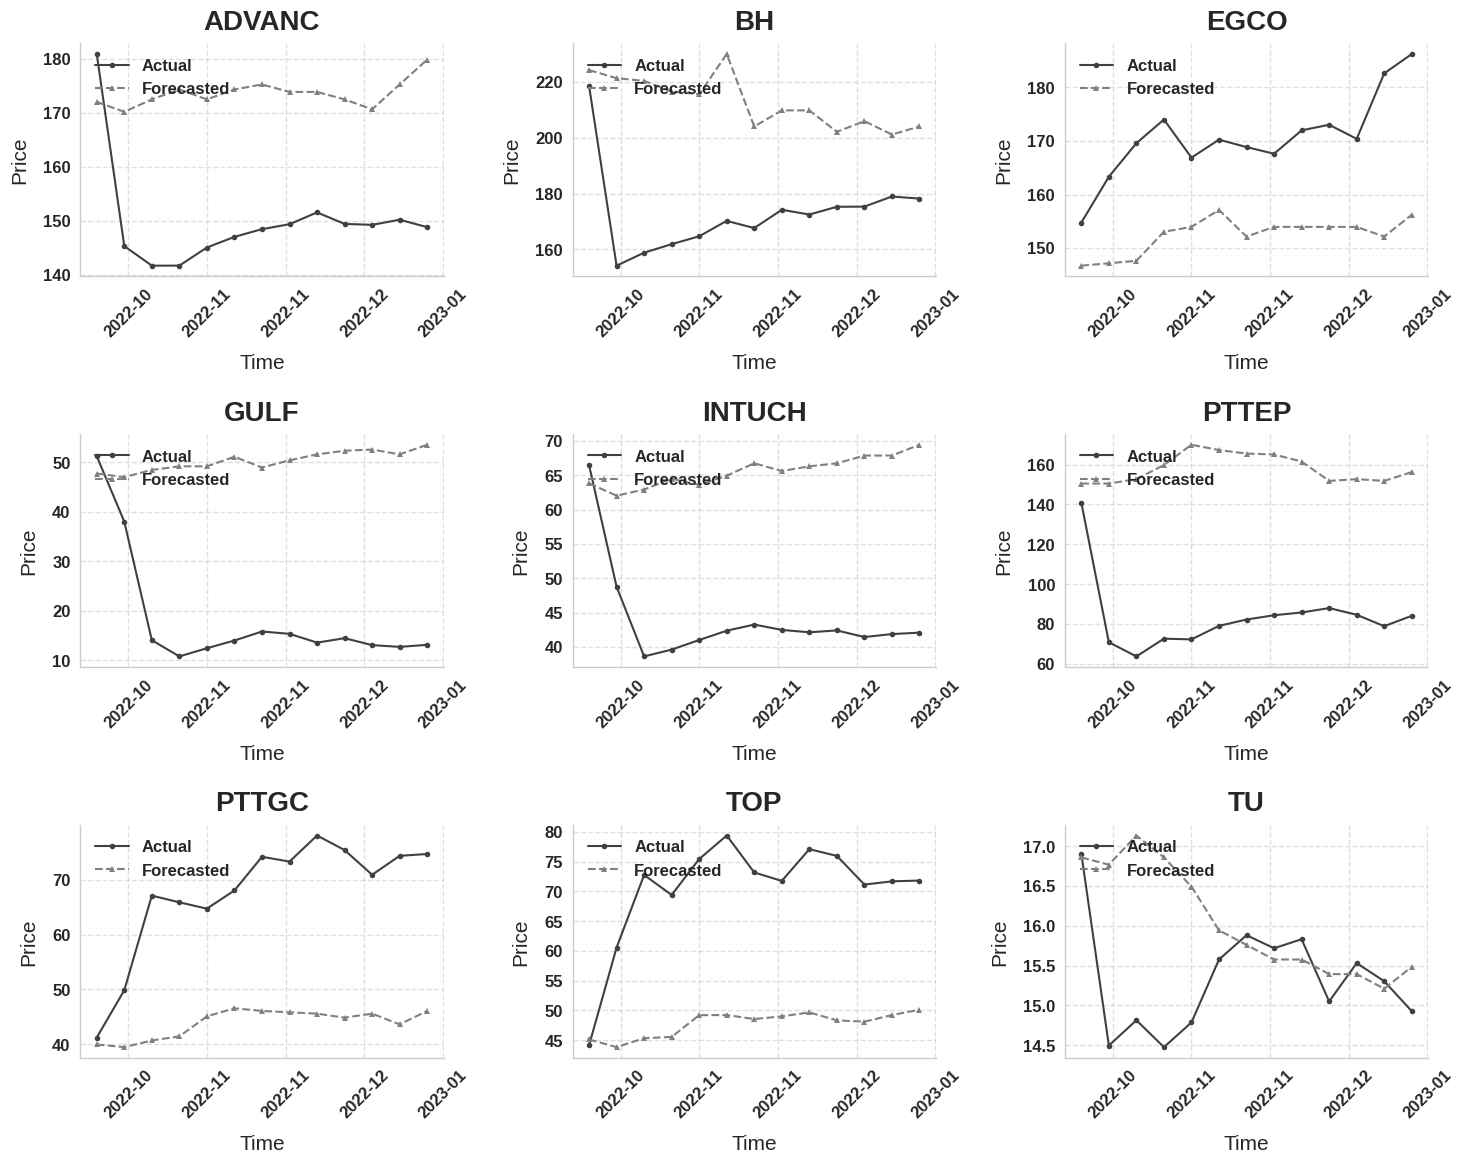

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoLocator

def plot_actual_vs_forecasted(actual_values, predicted_values):
    stocks = actual_values.columns
    plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn style for better aesthetics
    fig = plt.figure(figsize=(15, 12))

    # Define gray color palette
    colors = ['#404040', '#808080']  # Dark gray, Medium gray

    for i, stock in enumerate(stocks, 1):
        ax = plt.subplot(3, 3, i)

        # Extract data
        actual_stock_data = actual_values[stock]
        predicted_stock_name = stock.replace('Actual_', 'Predicted_')
        predicted_stock_data = predicted_values[predicted_stock_name]

        # Plot with different markers and gray colors
        ax.plot(actual_values.index, actual_stock_data,
                label='Actual',
                color=colors[0],
                marker='o',
                markersize=4,
                linestyle='-',
                linewidth=1.5)

        ax.plot(predicted_values.index, predicted_stock_data,
                label='Forecasted',
                color=colors[1],
                marker='^',
                markersize=4,
                linestyle='--',
                linewidth=1.5)

        # Customize x-axis
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        # Add grid with light gray color
        ax.grid(True, linestyle='--', alpha=0.7, color='#D3D3D3')

        # Customize title and labels
        plt.title(stock.replace('Actual_', ''), pad=10, fontsize=20, fontweight='bold')
        plt.xlabel('Time', labelpad=10, fontsize=15)
        plt.ylabel('Price', labelpad=10, fontsize=15)

        # Add legend with custom position
        plt.legend(loc='upper left', frameon=False, framealpha=0.9,  fontsize=12)

        # Add legend with custom position and get legend handles and labels
        legend = plt.legend(loc='upper left', frameon=False, framealpha=0.9, fontsize=12)

        # Make legend text bold
        for text in legend.get_texts():
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make x-tick labels bold
        for text in ax.get_xticklabels(): # This line was incorrectly indented
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make y-tick labels bold
        for text in ax.get_yticklabels():
            text.set_fontweight('bold')
            text.set_fontsize(12)


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig

# Example usage:
fig = plot_actual_vs_forecasted(predicted_prices_lstm,test_data)
plt.show()

In [ ]:
combined_prices_lstm.index=combined_prices_lstm.index.date


In [ ]:
combined_prices_lstm

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Initialize dictionaries to store the results for each stock
rmse_dict = {}
mae_dict = {}
mape_dict = {}
r2_dict = {}

# Extract predicted and actual values from combined_prices
predicted_values = combined_prices_lstm [[col for col in combined_prices_lstm .columns if col.startswith('Predicted')]]
actual_values = combined_prices_lstm [[col for col in combined_prices_lstm .columns if col.startswith('Actual')]]

# Loop through each stock (column pair of actual and predicted values)
for stock in predicted_values.columns:
    # Extract the actual and predicted values for this stock
    actual_col = stock.replace('Predicted', 'Actual')
    predicted_stock = combined_prices_lstm[stock]
    actual_stock = combined_prices_lstm [actual_col]

    # Calculate RMSE
    rmse_dict[stock] = np.sqrt(mean_squared_error(actual_stock, predicted_stock))

    # Calculate MAE
    mae_dict[stock] = mean_absolute_error(actual_stock, predicted_stock)

    # Calculate MAPE
    mape_dict[stock] = np.mean(np.abs((actual_stock - predicted_stock) / actual_stock)) * 100

    # Calculate R-squared
    r2_dict[stock] = r2_score(actual_stock, predicted_stock)

# Print the results for each stock
for stock in predicted_values.columns:
    print(f"Metrics for {stock.replace('Predicted_', '')}:")
    print(f"  RMSE: {rmse_dict[stock]}")
    print(f"  MAE: {mae_dict[stock]}")
    print(f"  MAPE: {mape_dict[stock]}%")
    print(f"  R-squared: {r2_dict[stock]}")
    print("\n")


Metrics for ADVANC:
  RMSE: 25.75912562388348
  MAE: 25.111463106595554
  MAPE: 14.446625188568024%
  R-squared: -117.84827002276276


Metrics for BH:
  RMSE: 43.2732856353241
  MAE: 39.6214599609375
  MAPE: 18.48527366163444%
  R-squared: -22.211892845985034


Metrics for EGCO:
  RMSE: 19.31074809370279
  MAE: 18.287142240084133
  MAPE: 11.982481285160432%
  R-squared: -35.67376809751743


Metrics for GULF:
  RMSE: 34.44193120318765
  MAE: 32.49639518444355
  MAPE: 64.07887758344573%
  R-squared: -312.85261959964265


Metrics for INTUCH:
  RMSE: 22.873528453418594
  MAE: 21.942479647122898
  MAPE: 33.31784491981858%
  R-squared: -118.56764515868724


Metrics for PTTEP:
  RMSE: 77.37790749738583
  MAE: 74.52937228863055
  MAPE: 46.898822392062506%
  R-squared: -128.44045339161832


Metrics for PTTGC:
  RMSE: 25.043650704709194
  MAE: 23.55599887554462
  MAPE: 53.046143923178846%
  R-squared: -101.6388843727751


Metrics for TOP:
  RMSE: 23.77581620256672
  MAE: 22.6988892188439
  MAPE:

In [ ]:
predicted_directions_lstm

ADVANC  BH  EGCO  GULF  INTUCH  PTTEP  PTTGC  TOP  TU
2022-10-07       1   1     1     1       1     -1      1    1  -1
2022-10-14       1  -1    -1     1       1      1     -1   -1  -1
2022-10-21      -1  -1     1     1      -1     -1      1   -1   1
2022-10-28      -1  -1     1     1      -1      1     -1   -1   1
2022-11-04      -1   1    -1     1       1      1     -1   -1  -1
2022-11-11      -1   1     1     1       1      1     -1    1  -1
2022-11-18       1  -1    -1     1       1      1      1   -1   1
2022-11-25       1   1    -1     1       1      1     -1   -1   1
2022-12-02       1   1     1     1       1      1      1    1   1
2022-12-09      -1  -1     1     1       1      1      1    1  -1
2022-12-16       1   1     1    -1       1      1     -1   -1   1
2022-12-23       1  -1    -1    -1       1     -1      1   -1   1
2022-12-30      -1  -1     1    -1       1      1      1   -1  -1

In [ ]:

                                          #LSTM  (download)


predicted_directions_lstm.to_csv('predicted_directions_lstm1.csv')
predicted_prices_lstm.to_csv('predicted_prices_lstm1.csv')
combined_prices_lstm.to_csv('combined_prices_lstm1.csv')


# Convert selected_stocks_lstm to a DataFrame before saving to CSV
selected_stocks_lstm_df = pd.DataFrame(list(selected_stocks_lstm.items()),
                                       columns=['Date', 'Selected Stocks'])
# Applying similar logic for consistency for selected_stocks_lstm
selected_stocks_lstm_df['Selected Stocks'] = selected_stocks_lstm_df['Selected Stocks'].apply(', '.join)

selected_stocks_lstm_df.to_csv('selected_stocks_lstm1.csv', index=False) # Now using the DataFrame

#gru + volume  4 star

In [ ]:
def selectted_stocks(predicted_directions):
  selected_stocks={}
  for i in range(len(predicted_directions)):
    date_str = predicted_directions.index[i].strftime('%Y-%m-%d')
    selected_stocks[date_str] = predicted_directions.iloc[i][predicted_directions.iloc[i]==1].index.tolist()

  return selected_stocks


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# List of tickers
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']

# Define start and end date for historical data
start_date = '2017-12-08'
end_date = '2023-12-30'

# Download the adjusted close price data
df_price = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
df_price = df_price.resample('W-FRI').last()  # Resample to weekly data
df_price.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

# Download the volume data
df_volume = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')['Volume']
df_volume = df_volume.resample('W-FRI').last()  # Resample to weekly data
df_volume.columns = ['ADVANC', 'BH', 'EGCO', 'GULF', 'INTUCH', 'PTTEP', 'PTTGC', 'TOP', 'TU']

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


In [ ]:
df_price

ADVANC          BH        EGCO       GULF  \
Date                                                                       
2017-12-08 00:00:00+00:00  136.462540  175.947464  170.262924  10.030398   
2017-12-15 00:00:00+00:00  142.612946  171.592331  169.485474   9.892996   
2017-12-22 00:00:00+00:00  142.997345  169.414780  173.372757  10.213603   
2017-12-29 00:00:00+00:00  146.841354  164.624146  167.930557  11.908237   
2018-01-05 00:00:00+00:00  149.916565  167.672714  167.930557  12.595249   
...                               ...         ...         ...        ...   
2023-12-01 00:00:00+00:00  209.930481  216.196136  120.347847  44.600224   
2023-12-08 00:00:00+00:00  210.889069  209.348297  118.926414  44.600224   
2023-12-15 00:00:00+00:00  210.889069  213.261337  117.978790  45.580448   
2023-12-22 00:00:00+00:00  211.847656  211.304825  120.347847  43.865055   
2023-12-29 00:00:00+00:00  208.013306  217.174408  121.295464  43.619999   

                              INTUCH       PTTEP      PTTGC        TOP  \
Date                                                                     
2017-12-08 00:00:00+00:00  39.609108   65.345444  64.348129  72.496758   
2017-12-15 00:00:00+00:00  39.609108   66.044342  65.326057  74.870697   
2017-12-22 00:00:00+00:00  39.969196   69.713440  66.695175  73.775032   
2017-12-29 00:00:00+00:00  40.509312   69.888176  66.499596  75.601143   
2018-01-05 00:00:00+00:00  41.409523   74.780350  70.606918  78.157700   
...                              ...         ...        ...        ...   
2023-12-01 00:00:00+00:00  67.220261  139.151657  37.754841  47.709446   
2023-12-08 00:00:00+00:00  66.505157  133.060852  38.000000  47.476715   
2023-12-15 00:00:00+00:00  66.743523  137.746094  38.490322  49.338551   
2023-12-22 00:00:00+00:00  67.697006  138.214600  37.754841  50.036736   
2023-12-29 00:00:00+00:00  68.173737  140.088699  37.754841  50.036736   

                                  TU  
Date                                  
2017-12-08 00:00:00+00:00  14.680013  
2017-12-15 00:00:00+00:00  14.529449  
2017-12-22 00:00:00+00:00  14.454166  
2017-12-29 00:00:00+00:00  14.981142  
2018-01-05 00:00:00+00:00  15.658681  
...                              ...  
2023-12-01 00:00:00+00:00  14.260377  
2023-12-08 00:00:00+00:00  14.549439  
2023-12-15 00:00:00+00:00  14.453085  
2023-12-22 00:00:00+00:00  13.874961  
2023-12-29 00:00:00+00:00  14.453085  

[317 rows x 9 columns]

In [ ]:
# Updated function to prepare data for GRU with separate scalers for price and volume
def prepare_data_for_gru(data_price, data_volume, look_back):
    # Define scalers for price and volume
    scaler_price = MinMaxScaler(feature_range=(0, 1))
    scaler_volume = MinMaxScaler(feature_range=(0, 1))

    # Scale price and volume independently
    scaled_price = scaler_price.fit_transform(data_price.values.reshape(-1, 1))
    scaled_volume = scaler_volume.fit_transform(data_volume.values.reshape(-1, 1))

    # Combine scaled price and volume into one dataset
    scaled_data = np.hstack((scaled_price, scaled_volume))

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back), :])  # Lagged price and volume
        y.append(scaled_price[i + look_back, 0])  # Target is the future price

    return np.array(X), np.array(y), scaler_price, scaler_volume


# Function to create GRU model with two hidden GRU layers
def create_gru_model(look_back):
    model = Sequential()
    model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
    model.add(GRU(units=50, return_sequences=True))  # First GRU layer with 107 units
    model.add(GRU(units=20))  # Second GRU layer with 79 units
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

# Updated forecast function to handle separate scalers
def forecast_stocks_gru(data_price, data_volume, forecast_horizon=1, look_back=100, epochs=50, batch_size=32):
    forecasted_prices = {}
    directions = {}

    for column in data_price.columns:
        # Prepare data for GRU using the modified function
        X, y, scaler_price, scaler_volume = prepare_data_for_gru(data_price[column], data_volume[column], look_back)
        X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: price and volume

        # Create and train the GRU model
        model = create_gru_model(look_back)
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Prepare the last 'look_back' days for forecasting
        last_look_back_days_price = data_price[column].iloc[-look_back:].values.reshape(-1, 1)
        last_look_back_days_volume = data_volume[column].iloc[-look_back:].values.reshape(-1, 1)

        # Scale last 'look_back' days data separately for each feature
        last_look_back_days_scaled_price = scaler_price.transform(last_look_back_days_price)
        last_look_back_days_scaled_volume = scaler_volume.transform(last_look_back_days_volume)
        last_look_back_days_combined = np.hstack((last_look_back_days_scaled_price, last_look_back_days_scaled_volume))
        X_forecast = last_look_back_days_combined.reshape(1, look_back, 2)  # 2 features

        # Forecast
        forecast_scaled = model.predict(X_forecast)
        forecast = scaler_price.inverse_transform(forecast_scaled)[0][0]  # Inverse transform with price scaler

        # Store forecasted price
        forecasted_prices[column] = forecast

        # Determine direction: 1 for up, -1 for down
        last_actual_price = data_price[column].iloc[-1]
        direction = 1 if forecast > last_actual_price else -1
        directions[column] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

# The rest of the code remains the same
# Initialize variables
initial_train_end = '2022-09-30'
full_train_data_price = df_price[df_price.index <= initial_train_end]
full_train_data_volume = df_volume[df_volume.index <= initial_train_end]
test_data = df_price[(df_price.index > initial_train_end) & (df_price.index <= '2022-12-31')]

# DataFrames to store both forecasted prices and directions
predicted_prices_gru = pd.DataFrame(index=test_data.index, columns=df_price.columns)
predicted_directions_gru = pd.DataFrame(index=test_data.index, columns=df_price.columns)

# Loop over each week in the test set
for i in range(len(test_data)):
    test_week_price = df_price.iloc[i:i+1]
    test_week_volume = df_volume.iloc[i:i+1]
    current_date = test_data.index[i]

    # Forecast prices and directions using GRU (price + volume)
    forecasts, directions = forecast_stocks_gru(full_train_data_price, full_train_data_volume)

    # Store forecasted prices and directions
    predicted_prices_gru.loc[current_date] = forecasts
    predicted_directions_gru.loc[current_date] = directions

    # Add the actual prices and volumes of the current test week to the training data
    full_train_data_price = pd.concat([full_train_data_price, test_week_price])
    full_train_data_volume = pd.concat([full_train_data_volume, test_week_volume])

# Output results
print("Predicted Prices:\n", predicted_prices_gru)
print("Predicted Directions:\n", predicted_directions_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:




# # Function to prepare data for GRU (price + volume)
# def prepare_data_for_gru(data_price, data_volume, look_back):
#     # Combine price and volume into one DataFrame
#     data_combined = pd.concat([data_price, data_volume], axis=1)

#     # Scale both price and volume
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled_data = scaler.fit_transform(data_combined)

#     X, y = [], []
#     for i in range(len(scaled_data) - look_back):
#         X.append(scaled_data[i:(i + look_back), :])  # Lagged price and volume
#         y.append(scaled_data[i + look_back, 0])  # Target is the future price

#     return np.array(X), np.array(y), scaler


# # Function to create GRU model with two hidden GRU layers
# def create_gru_model(look_back):
#     model = Sequential()
#     model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
#     model.add(GRU(units=10, return_sequences=True))  # First GRU layer with 107 units
#     model.add(GRU(units=5))  # Second GRU layer with 79 units
#     model.add(Dense(units=1))  # Output layer for regression
#     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
#     return model

# # # Function to create GRU model with two inputs (price + volume)
# # def create_gru_model(look_back):
# #     model = Sequential()
# #     model.add(Input(shape=(look_back, 2)))  # 2 features: price and volume
# #     model.add(GRU(units=79))  # GRU layer with 3 neurons
# #     model.add(Dense(units=1))  # Output layer
# #     model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
# #     return model

# # Function to forecast stocks using GRU (price + volume)
# def forecast_stocks_gru(data_price, data_volume, forecast_horizon=1, look_back=10, epochs=50, batch_size=32):
#     forecasted_prices = {}
#     directions = {}

#     for column in data_price.columns:
#         X, y, scaler = prepare_data_for_gru(data_price[column], data_volume[column], look_back)
#         X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: price and volume

#         model = create_gru_model(look_back)
#         model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

#         # Prepare the last 'look_back' days for forecasting
#         last_look_back_days_price = data_price[column].iloc[-look_back:].values.reshape(-1, 1)
#         last_look_back_days_volume = data_volume[column].iloc[-look_back:].values.reshape(-1, 1)
#         last_look_back_days_combined = np.concatenate([last_look_back_days_price, last_look_back_days_volume], axis=1)

#         last_look_back_days_scaled = scaler.transform(last_look_back_days_combined)
#         X_forecast = last_look_back_days_scaled.reshape(1, look_back, 2)  # 2 features

#         # Forecast
#         forecast_scaled = model.predict(X_forecast)
#         forecast = scaler.inverse_transform(np.concatenate([forecast_scaled, np.zeros((1, 1))], axis=1))[0][0]

#         # Store forecasted price
#         forecasted_prices[column] = forecast

#         # Determine direction: 1 for up, -1 for down
#         last_actual_price = data_price[column].iloc[-1]
#         direction = 1 if forecast > last_actual_price else -1
#         directions[column] = direction

#     return pd.Series(forecasted_prices), pd.Series(directions)

# # Initialize variables
# initial_train_end = '2022-09-30'
# full_train_data_price = df_price[df_price.index <= initial_train_end]
# full_train_data_volume = df_volume[df_volume.index <= initial_train_end]
# test_data = df_price[(df_price.index > initial_train_end) & (df_price.index <= '2022-12-31')]

# # DataFrames to store both forecasted prices and directions
# predicted_prices_gru = pd.DataFrame(index=test_data.index, columns=df_price.columns)
# predicted_directions_gru = pd.DataFrame(index=test_data.index, columns=df_price.columns)

# # Loop over each week in the test set
# for i in range(len(test_data)):
#     test_week_price = df_price.iloc[i:i+1]
#     test_week_volume = df_volume.iloc[i:i+1]
#     current_date = test_data.index[i]

#     # Forecast prices and directions using GRU (price + volume)
#     forecasts, directions = forecast_stocks_gru(full_train_data_price, full_train_data_volume)

#     # Store forecasted prices and directions
#     predicted_prices_gru.loc[current_date] = forecasts
#     predicted_directions_gru.loc[current_date] = directions

#     # Add the actual prices and volumes of the current test week to the training data
#     full_train_data_price = pd.concat([full_train_data_price, test_week_price])
#     full_train_data_volume = pd.concat([full_train_data_volume, test_week_volume])



In [ ]:
predicted_directions_gru

ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
Date                                                                     
2022-10-07 00:00:00+00:00      1  -1    1   -1      1    -1    -1  -1  -1
2022-10-14 00:00:00+00:00      1   1   -1    1      1    -1    -1  -1   1
2022-10-21 00:00:00+00:00      1  -1   -1   -1      1    -1     1  -1   1
2022-10-28 00:00:00+00:00      1   1   -1   -1     -1     1    -1  -1  -1
2022-11-04 00:00:00+00:00     -1  -1   -1    1     -1     1    -1   1  -1
2022-11-11 00:00:00+00:00     -1  -1   -1    1      1    -1     1  -1  -1
2022-11-18 00:00:00+00:00      1   1   -1    1      1     1     1  -1   1
2022-11-25 00:00:00+00:00     -1   1   -1    1      1     1     1  -1   1
2022-12-02 00:00:00+00:00      1  -1   -1    1      1     1     1  -1   1
2022-12-09 00:00:00+00:00      1   1    1   -1      1     1    -1   1   1
2022-12-16 00:00:00+00:00      1  -1   -1    1     -1    -1    -1   1   1
2022-12-23 00:00:00+00:00      1  -1   -1    1      1     1    -1  -1  -1
2022-12-30 00:00:00+00:00     -1  -1   -1    1      1    -1    -1   1   1

In [ ]:
predicted_prices_gru

ADVANC          BH        EGCO       GULF  \
Date                                                                       
2022-10-07 00:00:00+00:00  180.119522  218.329437  153.224518  50.602409   
2022-10-14 00:00:00+00:00  142.131531   189.66597    168.0728  17.954748   
2022-10-21 00:00:00+00:00  149.451614  159.041214  167.006134   8.164168   
2022-10-28 00:00:00+00:00  143.750565  171.873123  171.416885   9.719085   
2022-11-04 00:00:00+00:00  144.469879  158.401108  166.606171  13.740832   
2022-11-11 00:00:00+00:00  149.320984  166.728821  164.576935  13.281178   
2022-11-18 00:00:00+00:00  148.441376  173.544128  169.705688  15.443257   
2022-11-25 00:00:00+00:00  147.688736  178.562897  167.388016  15.067045   
2022-12-02 00:00:00+00:00  150.065613  164.605347  168.524033  14.274977   
2022-12-09 00:00:00+00:00  152.045959  176.956802  172.484375  12.947444   
2022-12-16 00:00:00+00:00  150.731323  165.035645  163.076462  13.453258   
2022-12-23 00:00:00+00:00  154.437393  173.561539     185.056  14.622585   
2022-12-30 00:00:00+00:00  147.111389  174.429428  181.867172  13.736074   

                              INTUCH       PTTEP      PTTGC        TOP  \
Date                                                                     
2022-10-07 00:00:00+00:00  66.175018  141.487457  39.860558  43.871147   
2022-10-14 00:00:00+00:00  42.164082   31.028864  61.759338  69.814232   
2022-10-21 00:00:00+00:00  40.143986   65.482819  65.665092  70.594742   
2022-10-28 00:00:00+00:00  39.876293   75.995262  64.422623  70.089851   
2022-11-04 00:00:00+00:00  40.434608   70.209663  64.803185  78.610497   
2022-11-11 00:00:00+00:00  42.151535   74.485611  72.006317  77.296684   
2022-11-18 00:00:00+00:00  42.961369   78.385193  74.796684  71.801208   
2022-11-25 00:00:00+00:00  42.156708   82.010971  75.548935  70.968102   
2022-12-02 00:00:00+00:00   41.79985   85.689392  78.215843  74.785805   
2022-12-09 00:00:00+00:00  41.854927    91.38903  71.901375  77.304703   
2022-12-16 00:00:00+00:00  39.952229   78.726868  71.249786  72.980598   
2022-12-23 00:00:00+00:00   42.00563   90.432991  71.633705  73.196564   
2022-12-30 00:00:00+00:00  41.344372   82.175331  71.229317  74.065865   

                                  TU  
Date                                  
2022-10-07 00:00:00+00:00  16.895554  
2022-10-14 00:00:00+00:00  14.749683  
2022-10-21 00:00:00+00:00  14.842225  
2022-10-28 00:00:00+00:00   14.40395  
2022-11-04 00:00:00+00:00  14.943429  
2022-11-11 00:00:00+00:00  15.639016  
2022-11-18 00:00:00+00:00  15.659326  
2022-11-25 00:00:00+00:00  15.859561  
2022-12-02 00:00:00+00:00  16.200226  
2022-12-09 00:00:00+00:00   15.77303  
2022-12-16 00:00:00+00:00  15.776093  
2022-12-23 00:00:00+00:00   14.61319  
2022-12-30 00:00:00+00:00  15.431455

In [ ]:
# Print results
print("GRU Predicted Prices:")
print(predicted_prices_gru)
print("GRU Predicted Directions:")
print(predicted_directions_gru)
selected_stocks_gru = selectted_stocks(predicted_directions_gru)
print("Selected Stocks (GRU):")
print(selected_stocks_gru)

GRU Predicted Prices:
                               ADVANC          BH        EGCO       GULF  \
Date                                                                       
2022-10-07 00:00:00+00:00  180.119522  218.329437  153.224518  50.602409   
2022-10-14 00:00:00+00:00  142.131531   189.66597    168.0728  17.954748   
2022-10-21 00:00:00+00:00  149.451614  159.041214  167.006134   8.164168   
2022-10-28 00:00:00+00:00  143.750565  171.873123  171.416885   9.719085   
2022-11-04 00:00:00+00:00  144.469879  158.401108  166.606171  13.740832   
2022-11-11 00:00:00+00:00  149.320984  166.728821  164.576935  13.281178   
2022-11-18 00:00:00+00:00  148.441376  173.544128  169.705688  15.443257   
2022-11-25 00:00:00+00:00  147.688736  178.562897  167.388016  15.067045   
2022-12-02 00:00:00+00:00  150.065613  164.605347  168.524033  14.274977   
2022-12-09 00:00:00+00:00  152.045959  176.956802  172.484375  12.947444   
2022-12-16 00:00:00+00:00  150.731323  165.035645  163.076462  13.

In [ ]:
test_data

ADVANC          BH        EGCO       GULF  \
Date                                                                       
2022-10-07 00:00:00+00:00  172.024811  224.268799  146.702057  47.724339   
2022-10-14 00:00:00+00:00  170.180054  221.381241  147.154846  46.997574   
2022-10-21 00:00:00+00:00  172.486023  220.418701  147.607620  48.451107   
2022-10-28 00:00:00+00:00  174.330780  216.568588  153.041061  49.177872   
2022-11-04 00:00:00+00:00  172.486023  215.606064  153.946609  49.177872   
2022-11-11 00:00:00+00:00  174.330780  230.043976  157.116119  51.115917   
2022-11-18 00:00:00+00:00  175.253159  204.055725  152.135483  48.935616   
2022-11-25 00:00:00+00:00  173.869598  209.830902  153.946609  50.389149   
2022-12-02 00:00:00+00:00  173.869598  209.830902  153.946609  51.600426   
2022-12-09 00:00:00+00:00  172.486023  202.130692  153.946609  52.327194   
2022-12-16 00:00:00+00:00  170.641235  205.980789  153.946609  52.569450   
2022-12-23 00:00:00+00:00  175.253159  201.168167  152.135483  51.600426   
2022-12-30 00:00:00+00:00  179.865097  204.055725  156.210526  53.538471   

                              INTUCH       PTTEP      PTTGC        TOP  \
Date                                                                     
2022-10-07 00:00:00+00:00  63.824619  150.516144  39.994839  45.114914   
2022-10-14 00:00:00+00:00  62.026741  150.516144  39.507099  43.825916   
2022-10-21 00:00:00+00:00  62.925686  152.729614  40.726452  45.329742   
2022-10-28 00:00:00+00:00  64.498825  159.812744  41.458069  45.544575   
2022-11-04 00:00:00+00:00  63.599892  169.994705  45.116131  49.196739   
2022-11-11 00:00:00+00:00  64.948296  167.338547  46.579353  49.220390   
2022-11-18 00:00:00+00:00  66.746170  165.567780  46.091614  48.552238   
2022-11-25 00:00:00+00:00  65.622498  165.125076  45.847744  48.997669   
2022-12-02 00:00:00+00:00  66.296700  161.583511  45.603870  49.665821   
2022-12-09 00:00:00+00:00  66.746170  151.844223  44.872261  48.329521   
2022-12-16 00:00:00+00:00  67.869843  152.729614  45.603870  48.106808   
2022-12-23 00:00:00+00:00  67.869843  151.844223  43.652905  49.220390   
2022-12-30 00:00:00+00:00  69.442986  156.271179  46.091614  50.111256   

                                  TU  
Date                                  
2022-10-07 00:00:00+00:00  16.858240  
2022-10-14 00:00:00+00:00  16.766617  
2022-10-21 00:00:00+00:00  17.133102  
2022-10-28 00:00:00+00:00  16.858240  
2022-11-04 00:00:00+00:00  16.491756  
2022-11-11 00:00:00+00:00  15.942029  
2022-11-18 00:00:00+00:00  15.758790  
2022-11-25 00:00:00+00:00  15.575547  
2022-12-02 00:00:00+00:00  15.575547  
2022-12-09 00:00:00+00:00  15.392303  
2022-12-16 00:00:00+00:00  15.392303  
2022-12-23 00:00:00+00:00  15.209064  
2022-12-30 00:00:00+00:00  15.483926

In [ ]:
predicted_prices_gru.index=predicted_prices_gru.index.date

In [ ]:
# Combine the predicted prices and actual prices
combined_prices_gru = pd.concat([predicted_prices_gru, test_data], axis=1)
combined_prices_gru.columns = [f'Predicted_{col}' if i < len(predicted_prices_gru.columns) else f'Actual_{col}'
                                for i, col in enumerate(combined_prices_gru.columns)]

print("Combined Prices (GRU):")
print(combined_prices_gru)

ValueError: Cannot mix tz-aware with tz-naive values

In [ ]:
import pandas as pd

# Convert the index to datetime objects if it's not already
actual_directions.index = pd.to_datetime(actual_directions.index)

# Remove the time component by converting to date objects
actual_directions.index = actual_directions.index.date

In [ ]:
actual_directions

In [ ]:
predicted_directions_gru

In [ ]:
import pandas as pd


In [ ]:
predicted_directions_gru.index = pd.to_datetime(predicted_directions_gru.index).date

In [ ]:
predicted_directions_gru.index

In [ ]:


# from sklearn.metrics import accuracy_score, confusion_matrix

# # Ensure correct data types
# actual_directions = actual_directions.astype(int)
# predicted_directions_gru = predicted_directions_gru.astype(int)

# # Check for NaN values
# actual_directions = actual_directions.dropna()
# predicted_directions_gru = predicted_directions_gru.dropna()
# #predicted_directions_gru.index = predicted_directions_gru.index.date

# # Align both series to have the same length
# predicted_directions_gru = predicted_directions_gru.loc[actual_directions.index]

# # Calculate accuracy for each stock and overall accuracy
# all_accuracies_gru = []
# for stock in actual_directions.columns:
#     accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_gru[stock].values)
#     all_accuracies_gru.append(accuracy)
#     print(f"GRU Accuracy for {stock}: {accuracy * 100:.2f}%")

# print(f"Overall GRU Model Accuracy: {np.mean(all_accuracies_gru) * 100:.2f}%")

# # Calculate and print confusion matrix for each stock
# for stock in actual_directions.columns:
#     conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_gru[stock].values)
#     print(f"\nGRU Confusion Matrix for {stock}:")
#     print(conf_matrix)


# # Visualize the predictions
# import matplotlib.pyplot as plt

# def plot_predictions(stock):
#     plt.figure(figsize=(12, 6))
#     plt.plot(combined_prices_gru.index, combined_prices_gru[f'Actual_{stock}'], label='Actual')
#     plt.plot(combined_prices_gru.index, combined_prices_gru[f'Predicted_{stock}'], label='GRU Prediction')
#     plt.title(f'{stock} Stock Price Prediction')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()

# # Plot predictions for each stock
# for stock in test_data.columns:
#     plot_predictions(stock)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_gru = predicted_directions_gru.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_gru = predicted_directions_gru.dropna()

# Align both series to have the same length
predicted_directions_gru = predicted_directions_gru.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies_gru = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_gru[stock].values)
    all_accuracies_gru.append(accuracy)
    print(f"GRU Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall GRU Model Accuracy: {np.mean(all_accuracies_gru) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_gru[stock].values)
    print(f"\nGRU Confusion Matrix for {stock}:")
    print(conf_matrix)


# Function to visualize predictions with a custom style
def plot_predictions(stock):
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(12, 6))

    # Define gray color palette
    colors = ['#404040', '#808080']  # Dark gray for actual, medium gray for forecasted

    # Plot actual vs. predicted prices
    plt.plot(combined_prices_gru.index, combined_prices_gru[f'Actual_{stock}'],
             label='Actual', color=colors[0], marker='o', markersize=4, linestyle='-', linewidth=1.5)
    plt.plot(combined_prices_gru.index, combined_prices_gru[f'Predicted_{stock}'],
             label='GRU Prediction', color=colors[1], marker='^', markersize=4, linestyle='--', linewidth=1.5)

    # Customize title and labels with bold fonts
    plt.title(f'{stock} Stock Price Prediction', pad=10, fontsize=20, fontweight='bold')
    plt.xlabel('Date', labelpad=10, fontsize=15, fontweight='bold')
    plt.ylabel('Price', labelpad=10, fontsize=15, fontweight='bold')

    # Customize x-axis
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Add grid with light gray color
    plt.grid(True, linestyle='--', alpha=0.7, color='#D3D3D3')

    # Add legend with custom position, bold font, and increased size
    legend = plt.legend(loc='upper left', frameon=False, fontsize=12)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    # Make x-tick labels bold
    for text in plt.gca().get_xticklabels():
        text.set_fontweight('bold')
        text.set_fontsize(12)

    # Make y-tick labels bold
    for text in plt.gca().get_yticklabels():
        text.set_fontweight('bold')
        text.set_fontsize(12)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    plt.show()

# Plot predictions for each stock
for stock in test_data.columns:
    plot_predictions(stock)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoLocator

def plot_actual_vs_forecasted(actual_values, predicted_values):
    stocks = actual_values.columns
    plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn style for better aesthetics
    fig = plt.figure(figsize=(15, 12))

    # Define gray color palette
    colors = ['#404040', '#808080']  # Dark gray, Medium gray

    for i, stock in enumerate(stocks, 1):
        ax = plt.subplot(3, 3, i)

        # Extract data
        actual_stock_data = actual_values[stock]
        predicted_stock_name = stock.replace('Actual_', 'Predicted_')
        predicted_stock_data = predicted_values[predicted_stock_name]

        # Plot with different markers and gray colors
        ax.plot(actual_values.index, actual_stock_data,
                label='Actual',
                color=colors[0],
                marker='o',
                markersize=4,
                linestyle='-',
                linewidth=1.5)

        ax.plot(predicted_values.index, predicted_stock_data,
                label='Forecasted',
                color=colors[1],
                marker='^',
                markersize=4,
                linestyle='--',
                linewidth=1.5)

        # Customize x-axis
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        # Add grid with light gray color
        ax.grid(True, linestyle='--', alpha=0.7, color='#D3D3D3')

        # Customize title and labels
        plt.title(stock.replace('Actual_', ''), pad=10, fontsize=20, fontweight='bold')
        plt.xlabel('Time', labelpad=10, fontsize=15)
        plt.ylabel('Price', labelpad=10, fontsize=15)

        # Add legend with custom position
        plt.legend(loc='upper left', frameon=False, framealpha=0.9,  fontsize=12)

        # Add legend with custom position and get legend handles and labels
        legend = plt.legend(loc='upper left', frameon=False, framealpha=0.9, fontsize=12)

        # Make legend text bold
        for text in legend.get_texts():
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make x-tick labels bold
        for text in ax.get_xticklabels(): # This line was incorrectly indented
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make y-tick labels bold
        for text in ax.get_yticklabels():
            text.set_fontweight('bold')
            text.set_fontsize(12)


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig

# Example usage:
fig = plot_actual_vs_forecasted(predicted_prices_gru,test_data)
plt.show()

In [ ]:
combined_prices_gru.index=combined_prices_gru.index.date


In [ ]:
combined_prices_gru

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Initialize dictionaries to store the results for each stock
rmse_dict = {}
mae_dict = {}
mape_dict = {}
r2_dict = {}

# Extract predicted and actual values from combined_prices
predicted_values = combined_prices_gru [[col for col in combined_prices_gru .columns if col.startswith('Predicted')]]
actual_values = combined_prices_gru [[col for col in combined_prices_gru .columns if col.startswith('Actual')]]

# Loop through each stock (column pair of actual and predicted values)
for stock in predicted_values.columns:
    # Extract the actual and predicted values for this stock
    actual_col = stock.replace('Predicted', 'Actual')
    predicted_stock = combined_prices_gru[stock]
    actual_stock = combined_prices_gru [actual_col]

    # Calculate RMSE
    rmse_dict[stock] = np.sqrt(mean_squared_error(actual_stock, predicted_stock))

    # Calculate MAE
    mae_dict[stock] = mean_absolute_error(actual_stock, predicted_stock)

    # Calculate MAPE
    mape_dict[stock] = np.mean(np.abs((actual_stock - predicted_stock) / actual_stock)) * 100

    # Calculate R-squared
    r2_dict[stock] = r2_score(actual_stock, predicted_stock)

# Print the results for each stock
for stock in predicted_values.columns:
    print(f"Metrics for {stock.replace('Predicted_', '')}:")
    print(f"  RMSE: {rmse_dict[stock]}")
    print(f"  MAE: {mae_dict[stock]}")
    print(f"  MAPE: {mape_dict[stock]}%")
    print(f"  R-squared: {r2_dict[stock]}")
    print("\n")


In [ ]:
predicted_directions_gru

In [ ]:

                                          #GRU  (download)


predicted_directions_gru.to_csv('predicted_directions_gru1.csv')
predicted_prices_gru.to_csv('predicted_prices_gru1.csv')
combined_prices_gru.to_csv('combined_prices_gru1.csv')


# Convert selected_stocks_gru to a DataFrame before saving to CSV
selected_stocks_gru_df = pd.DataFrame(list(selected_stocks_gru.items()),
                                       columns=['Date', 'Selected Stocks'])
# Applying similar logic for consistency for selected_stocks_gru
selected_stocks_gru_df['Selected Stocks'] = selected_stocks_gru_df['Selected Stocks'].apply(', '.join)

selected_stocks_gru_df.to_csv('selected_stocks_gru1.csv', index=False) # Now using the DataFrame

#RF (include in my thesis)

In [ ]:
!pip install numpy==1.23.0 --force

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
bigframes 1.25.0 requires numpy>=1.24.0, but you have numpy 1.23.0 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
ibis-framework 9.2.0 requires numpy<3,>=1.23.2, but you have numpy 1.23.0 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.0 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.

In [ ]:
# First, run these commands to install system dependencies and TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install TA-Lib

--2024-11-02 14:07:11--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-11-02 14:07:11--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-11-02 14:07:11--  http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import yfinance as yf

# Data collection block (modified to include OHLCV)
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']
start_date = '2017-12-08'
end_date = '2023-12-30'
data = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')[['Open', 'High', 'Low', 'Close', 'Volume']]
data = data.resample('W-FRI').last()  # Weekly data

# Set multi-level column names for easier access
data.columns.names = ['Feature', 'Ticker']
data.index = pd.to_datetime(data.index.date)

# Function to prepare data with OHLCV features and lagged variables for Random Forest
def prepare_data_for_rf(data, look_back):
    # Separate scaling per stock
    scaler_dict = {ticker: MinMaxScaler(feature_range=(0, 1)) for ticker in data.columns.levels[1]}
    X_dict, y_dict = {}, {}

    for ticker in data.columns.levels[1]:
        # Select close, high, low, and volume data for the ticker
        df = data.xs(ticker, level='Ticker', axis=1)

        # Scaling
        scaled_data = scaler_dict[ticker].fit_transform(df)

        # Generate lagged features
        X, y = [], []
        for i in range(look_back, len(scaled_data)):
            # Combine lagged OHLCV values as input features
            features = scaled_data[i-look_back:i].flatten()
            X.append(features)
            y.append(scaled_data[i, 3])  # Close price as target (index 3 since it's in OHLCV order)

        X_dict[ticker], y_dict[ticker] = np.array(X), np.array(y)

    return X_dict, y_dict, scaler_dict

# Function to forecast using Random Forest with OHLCV features
def forecast_stocks_rf(data, look_back=150, n_estimators=200, max_depth=10):
    forecasted_prices = {}
    directions = {}

    # Prepare data
    X_dict, y_dict, scaler_dict = prepare_data_for_rf(data, look_back)

    for ticker in data.columns.levels[1]:
        # Train Random Forest model for each ticker
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=5,
            min_samples_leaf=2,
            n_jobs=-1,
            random_state=42
        )

        # Fit the model with ticker-specific data
        X, y = X_dict[ticker], y_dict[ticker]
        model.fit(X, y)

        # Prepare the last 'look_back' days for forecasting
        last_data = data.xs(ticker, level='Ticker', axis=1).iloc[-look_back:]
        last_scaled = scaler_dict[ticker].transform(last_data).flatten().reshape(1, -1)

        # Forecast
        forecast_scaled = model.predict(last_scaled)

        # Ensure placeholder input has correct structure
        placeholder_input = np.zeros((1, 5))  # [open, high, low, close, volume]
        placeholder_input[0, 3] = forecast_scaled[0]  # Set forecast close price at correct index (3rd position)

        # Perform inverse transform on full placeholder array
        forecast = scaler_dict[ticker].inverse_transform(placeholder_input)[0][3]

        # Store forecasted price and direction
        forecasted_prices[ticker] = forecast
        last_actual_price = data.loc[data.index[-1], ('Close', ticker)]
        direction = 1 if (forecast - last_actual_price) / last_actual_price > 0.01 else -1
        directions[ticker] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

# Initializing variables for the backtesting loop
initial_train_end = '2022-09-30'
full_train_data = data[data.index <= initial_train_end]
test_data = data[(data.index > initial_train_end) & (data.index <= '2022-12-31')]

# DataFrames to store forecasted prices and directions
predicted_prices_rf = pd.DataFrame(index=test_data.index, columns=data.columns.levels[1])
predicted_directions_rf = pd.DataFrame(index=test_data.index, columns=data.columns.levels[1])

# Loop over each week in the test set
for i in range(len(test_data)):
    test_week = test_data.iloc[i:i+1]
    current_date = test_data.index[i]

    # Forecast prices and directions
    forecasts, directions = forecast_stocks_rf(full_train_data)

    # Store forecasted prices and directions
    predicted_prices_rf.loc[current_date] = forecasts
    predicted_directions_rf.loc[current_date] = directions

    # Add the actual prices of the current test week to the training data (rolling window)
    full_train_data = pd.concat([full_train_data, test_week]).iloc[-365:]  # Using a 1-year rolling window

# Results
print("Random Forest Predicted Prices:")
print(predicted_prices_rf)
print("Random Forest Predicted Directions:")
print(predicted_directions_rf)


[*********************100%***********************]  9 of 9 completed


Random Forest Predicted Prices:
Ticker       ADVANC.BK       BH.BK     EGCO.BK    GULF.BK  INTUCH.BK  \
2022-10-07  195.413595  212.606743  170.672369  51.509875  72.331429   
2022-10-14  189.986344  217.252006  170.871811  50.332041  71.547348   
2022-10-21  188.261134  217.954169  166.615532  49.561097   70.93273   
2022-10-28  187.981097  217.875994  167.109608  49.015987  70.835768   
2022-11-04  188.868743  215.846941  167.501778  50.732086  71.303838   
2022-11-11  189.633143  220.168156  169.473271  49.909171  70.931431   
2022-11-18  188.698331  223.916714  169.816979  50.534946  71.475732   
2022-11-25  188.660834  219.939726  170.038668  50.581428  72.762993   
2022-12-02   188.50493    218.8508  168.272524  50.668292  72.006767   
2022-12-09  188.153506  214.699474  169.816586  52.369545  72.818322   
2022-12-16  187.383781    214.9843  169.556371  53.111604  73.227133   
2022-12-23  187.383225  213.347014   169.02808  53.493378  75.343473   
2022-12-30  189.248946  213.7634

In [ ]:
def selectted_stocks(predicted_directions):
  selected_stocks={}
  for i in range(len(predicted_directions)):
    date_str = predicted_directions.index[i].strftime('%Y-%m-%d')
    selected_stocks[date_str] = predicted_directions.iloc[i][predicted_directions.iloc[i]==1].index.tolist()

  return selected_stocks

In [ ]:
selected_stocks_rf=selectted_stocks(predicted_directions_rf)
selected_stocks_rf

{'2022-10-07': ['EGCO.BK', 'PTTEP.BK', 'PTTGC.BK'],
 '2022-10-14': ['ADVANC.BK', 'EGCO.BK', 'GULF.BK', 'PTTGC.BK'],
 '2022-10-21': ['ADVANC.BK',
  'EGCO.BK',
  'GULF.BK',
  'INTUCH.BK',
  'PTTGC.BK',
  'TOP.BK'],
 '2022-10-28': ['EGCO.BK', 'INTUCH.BK', 'PTTGC.BK'],
 '2022-11-04': ['PTTGC.BK'],
 '2022-11-11': ['ADVANC.BK'],
 '2022-11-18': [],
 '2022-11-25': ['BH.BK', 'EGCO.BK'],
 '2022-12-02': [],
 '2022-12-09': [],
 '2022-12-16': ['BH.BK', 'PTTEP.BK', 'TOP.BK'],
 '2022-12-23': ['ADVANC.BK', 'PTTEP.BK'],
 '2022-12-30': ['BH.BK', 'EGCO.BK', 'PTTGC.BK', 'TU.BK']}

In [ ]:
predicted_directions_rf

Ticker     ADVANC.BK BH.BK EGCO.BK GULF.BK INTUCH.BK PTTEP.BK PTTGC.BK TOP.BK  \
2022-10-07        -1    -1       1      -1        -1        1        1     -1   
2022-10-14         1    -1       1       1        -1       -1        1     -1   
2022-10-21         1    -1       1       1         1       -1        1      1   
2022-10-28        -1    -1       1      -1         1       -1        1     -1   
2022-11-04        -1    -1      -1      -1        -1       -1        1     -1   
2022-11-11         1    -1      -1      -1        -1       -1       -1     -1   
2022-11-18        -1    -1      -1      -1        -1       -1       -1     -1   
2022-11-25        -1     1       1      -1        -1       -1       -1     -1   
2022-12-02        -1    -1      -1      -1        -1       -1       -1     -1   
2022-12-09        -1    -1      -1      -1        -1       -1       -1     -1   
2022-12-16        -1     1      -1      -1        -1        1       -1      1   
2022-12-23         1    -1      -1      -1        -1        1       -1     -1   
2022-12-30        -1     1       1      -1        -1       -1        1     -1   

Ticker     TU.BK  
2022-10-07    -1  
2022-10-14    -1  
2022-10-21    -1  
2022-10-28    -1  
2022-11-04    -1  
2022-11-11    -1  
2022-11-18    -1  
2022-11-25    -1  
2022-12-02    -1  
2022-12-09    -1  
2022-12-16    -1  
2022-12-23    -1  
2022-12-30     1

In [ ]:
predicted_directions

ADVANC  BH  EGCO  GULF  INTUCH  PTTEP  PTTGC  TOP  TU
2022-10-07      -1  -1     1    -1      -1      1      1   -1  -1
2022-10-14       1  -1     1     1      -1     -1      1   -1  -1
2022-10-21       1  -1     1     1       1     -1      1    1  -1
2022-10-28      -1  -1     1    -1       1     -1      1   -1  -1
2022-11-04      -1  -1    -1    -1      -1     -1      1   -1  -1
2022-11-11       1  -1    -1    -1      -1     -1     -1   -1  -1
2022-11-18      -1  -1    -1    -1      -1     -1     -1   -1  -1
2022-11-25      -1   1     1    -1      -1     -1     -1   -1  -1
2022-12-02      -1  -1    -1    -1      -1     -1     -1   -1  -1
2022-12-09      -1  -1    -1    -1      -1     -1     -1   -1  -1
2022-12-16      -1   1    -1    -1      -1      1     -1    1  -1
2022-12-23       1  -1    -1    -1      -1      1     -1   -1  -1
2022-12-30      -1   1     1    -1      -1     -1      1   -1   1

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Ensure correct data types and values
actual_directions = actual_directions.astype(int)
predicted_directions = predicted_directions_rf.astype(int)

# Replace any values other than -1, 0, and 1 with 0 in both DataFrames
actual_directions = actual_directions.replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)
predicted_directions = predicted_directions.replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)
actual_directions[~actual_directions.isin([-1, 1])] = 0
predicted_directions[~predicted_directions.isin([-1, 1])] = 0

# Check for NaN values and drop them
actual_directions = actual_directions.dropna()
predicted_directions = predicted_directions.dropna()

# Align column names of predicted_directions to match actual_directions
# This line is added to fix the KeyError
predicted_directions.columns = actual_directions.columns

# Align both series to have the same length and columns
predicted_directions = predicted_directions.loc[actual_directions.index, actual_directions.columns]

# Calculate accuracy for each stock and overall accuracy
all_accuracies = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions[stock].values)
    all_accuracies.append(accuracy)
    print(f"Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall Model Accuracy: {np.mean(all_accuracies) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions[stock].values)
    print(f"\nConfusion Matrix for {stock}:")
    print(conf_matrix)

Accuracy for ADVANC: 69.23%
Accuracy for BH: 84.62%
Accuracy for EGCO: 76.92%
Accuracy for GULF: 38.46%
Accuracy for INTUCH: 53.85%
Accuracy for PTTEP: 61.54%
Accuracy for PTTGC: 69.23%
Accuracy for TOP: 30.77%
Accuracy for TU: 92.31%
Overall Model Accuracy: 64.10%

Confusion Matrix for ADVANC:
[[6 1]
 [3 3]]

Confusion Matrix for BH:
[[8 0]
 [2 3]]

Confusion Matrix for EGCO:
[[5 1]
 [2 5]]

Confusion Matrix for GULF:
[[4 1]
 [7 1]]

Confusion Matrix for INTUCH:
[[5 0]
 [6 2]]

Confusion Matrix for PTTEP:
[[6 1]
 [4 2]]

Confusion Matrix for PTTGC:
[[5 2]
 [2 4]]

Confusion Matrix for TOP:
[[3 1]
 [8 1]]

Confusion Matrix for TU:
[[11  0]
 [ 1  1]]


In [ ]:
predicted_prices_rf

Ticker          ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07  195.413595  212.606743  170.672369  51.509875  72.331429   
2022-10-14  189.986344  217.252006  170.871811  50.332041  71.547348   
2022-10-21  188.261134  217.954169  166.615532  49.561097   70.93273   
2022-10-28  187.981097  217.875994  167.109608  49.015987  70.835768   
2022-11-04  188.868743  215.846941  167.501778  50.732086  71.303838   
2022-11-11  189.633143  220.168156  169.473271  49.909171  70.931431   
2022-11-18  188.698331  223.916714  169.816979  50.534946  71.475732   
2022-11-25  188.660834  219.939726  170.038668  50.581428  72.762993   
2022-12-02   188.50493    218.8508  168.272524  50.668292  72.006767   
2022-12-09  188.153506  214.699474  169.816586  52.369545  72.818322   
2022-12-16  187.383781    214.9843  169.556371  53.111604  73.227133   
2022-12-23  187.383225  213.347014   169.02808  53.493378  75.343473   
2022-12-30  189.248946  213.763423  169.974045  52.900068  75.293419   

Ticker           PTTEP      PTTGC        TOP         TU  
2022-10-07   163.51375  44.301021  51.559328  18.471818  
2022-10-14  165.630854  49.298608  52.945319  18.162827  
2022-10-21  164.857183  47.064384  51.777854  18.111249  
2022-10-28  166.402381   45.51882  53.074922  18.633813  
2022-11-04  170.774852  44.762634  53.407204  18.432663  
2022-11-11  177.256211  46.423403  56.209698  18.004368  
2022-11-18  179.195095  46.768458  54.467514  17.484549  
2022-11-25  182.305758  46.762853  54.025059  17.205708  
2022-12-02  183.358392  46.603834  54.420023  17.005706  
2022-12-09  182.660032  46.307241  55.453662  17.043206  
2022-12-16  180.130817  46.170302  54.827106  16.915851  
2022-12-23  175.108912  46.406881   54.05898  16.829308  
2022-12-30  171.173031  46.047732  54.018471  16.946854

In [ ]:
# Assuming predicted_directions_lstm is your DataFrame
predicted_prices_rf.columns = predicted_prices_rf.columns.str.replace('.BK', '', regex=False)

In [ ]:
test_data

ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07  172.024826  224.268799  146.702072  47.724342  63.824612   
2022-10-14  170.180054  221.381241  147.154846  46.997574  62.026730   
2022-10-21  172.486023  220.418701  147.607635  48.451107  62.925671   
2022-10-28  174.330780  216.568588  153.041061  49.177876  64.498825   
2022-11-04  172.486023  215.606064  153.946609  49.177876  63.599888   
2022-11-11  174.330780  230.043976  157.116119  51.115917  64.948288   
2022-11-18  175.253174  204.055740  152.135483  48.935619  66.746162   
2022-11-25  173.869614  209.830902  153.946609  50.389153  65.622490   
2022-12-02  173.869614  209.830902  153.946609  51.600430  66.296692   
2022-12-09  172.486023  202.130692  153.946609  52.327198  66.746162   
2022-12-16  170.641235  205.980789  153.946609  52.569450  67.869843   
2022-12-23  175.253174  201.168182  152.135483  51.600430  67.869843   
2022-12-30  179.865097  204.055740  156.210526  53.538475  69.442978   

                 PTTEP      PTTGC        TOP         TU  
2022-10-07  150.516144  39.994839  45.114914  16.858240  
2022-10-14  150.516144  39.507099  43.825912  16.766617  
2022-10-21  152.729614  40.726452  45.329746  17.133102  
2022-10-28  159.812744  41.458069  45.544579  16.858240  
2022-11-04  169.994720  45.116131  49.196735  16.491756  
2022-11-11  167.338547  46.579357  49.220390  15.942031  
2022-11-18  165.567764  46.091614  48.552238  15.758788  
2022-11-25  165.125076  45.847744  48.997673  15.575547  
2022-12-02  161.583511  45.603874  49.665821  15.575547  
2022-12-09  151.844223  44.872261  48.329525  15.392305  
2022-12-16  152.729614  45.603874  48.106808  15.392305  
2022-12-23  151.844223  43.652905  49.220390  15.209064  
2022-12-30  156.271179  46.091614  50.111256  15.483925

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoLocator

def plot_actual_vs_forecasted(actual_values, predicted_values):
    stocks = actual_values.columns
    plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn style for better aesthetics
    fig = plt.figure(figsize=(15, 12))

    # Define gray color palette
    colors = ['#404040', '#808080']  # Dark gray, Medium gray

    for i, stock in enumerate(stocks, 1):
        ax = plt.subplot(3, 3, i)

        # Extract data
        actual_stock_data = actual_values[stock]
        predicted_stock_name = stock.replace('Actual_', 'Predicted_')
        predicted_stock_data = predicted_values[predicted_stock_name]

        # Plot with different markers and gray colors
        ax.plot(actual_values.index, actual_stock_data,
                label='Actual',
                color=colors[0],
                marker='o',
                markersize=4,
                linestyle='-',
                linewidth=1.5)

        ax.plot(predicted_values.index, predicted_stock_data,
                label='Forecasted',
                color=colors[1],
                marker='^',
                markersize=4,
                linestyle='--',
                linewidth=1.5)

        # Customize x-axis
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        # Add grid with light gray color
        ax.grid(True, linestyle='--', alpha=0.7, color='#D3D3D3')

        # Customize title and labels
        plt.title(stock.replace('Actual_', ''), pad=10, fontsize=20, fontweight='bold')
        plt.xlabel('Time', labelpad=10, fontsize=15)
        plt.ylabel('Price', labelpad=10, fontsize=15)

        # Add legend with custom position
        plt.legend(loc='upper left', frameon=False, framealpha=0.9,  fontsize=12)

        # Add legend with custom position and get legend handles and labels
        legend = plt.legend(loc='upper left', frameon=False, framealpha=0.9, fontsize=12)

        # Make legend text bold
        for text in legend.get_texts():
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make x-tick labels bold
        for text in ax.get_xticklabels(): # This line was incorrectly indented
            text.set_fontweight('bold')
            text.set_fontsize(12)

        # Make y-tick labels bold
        for text in ax.get_yticklabels():
            text.set_fontweight('bold')
            text.set_fontsize(12)


        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig



In [ ]:
predicted_prices_rf

Ticker          ADVANC          BH        EGCO       GULF     INTUCH  \
2022-10-07  195.413595  212.606743  170.672369  51.509875  72.331429   
2022-10-14  189.986344  217.252006  170.871811  50.332041  71.547348   
2022-10-21  188.261134  217.954169  166.615532  49.561097   70.93273   
2022-10-28  187.981097  217.875994  167.109608  49.015987  70.835768   
2022-11-04  188.868743  215.846941  167.501778  50.732086  71.303838   
2022-11-11  189.633143  220.168156  169.473271  49.909171  70.931431   
2022-11-18  188.698331  223.916714  169.816979  50.534946  71.475732   
2022-11-25  188.660834  219.939726  170.038668  50.581428  72.762993   
2022-12-02   188.50493    218.8508  168.272524  50.668292  72.006767   
2022-12-09  188.153506  214.699474  169.816586  52.369545  72.818322   
2022-12-16  187.383781    214.9843  169.556371  53.111604  73.227133   
2022-12-23  187.383225  213.347014   169.02808  53.493378  75.343473   
2022-12-30  189.248946  213.763423  169.974045  52.900068  75.293419   

Ticker           PTTEP      PTTGC        TOP         TU  
2022-10-07   163.51375  44.301021  51.559328  18.471818  
2022-10-14  165.630854  49.298608  52.945319  18.162827  
2022-10-21  164.857183  47.064384  51.777854  18.111249  
2022-10-28  166.402381   45.51882  53.074922  18.633813  
2022-11-04  170.774852  44.762634  53.407204  18.432663  
2022-11-11  177.256211  46.423403  56.209698  18.004368  
2022-11-18  179.195095  46.768458  54.467514  17.484549  
2022-11-25  182.305758  46.762853  54.025059  17.205708  
2022-12-02  183.358392  46.603834  54.420023  17.005706  
2022-12-09  182.660032  46.307241  55.453662  17.043206  
2022-12-16  180.130817  46.170302  54.827106  16.915851  
2022-12-23  175.108912  46.406881   54.05898  16.829308  
2022-12-30  171.173031  46.047732  54.018471  16.946854

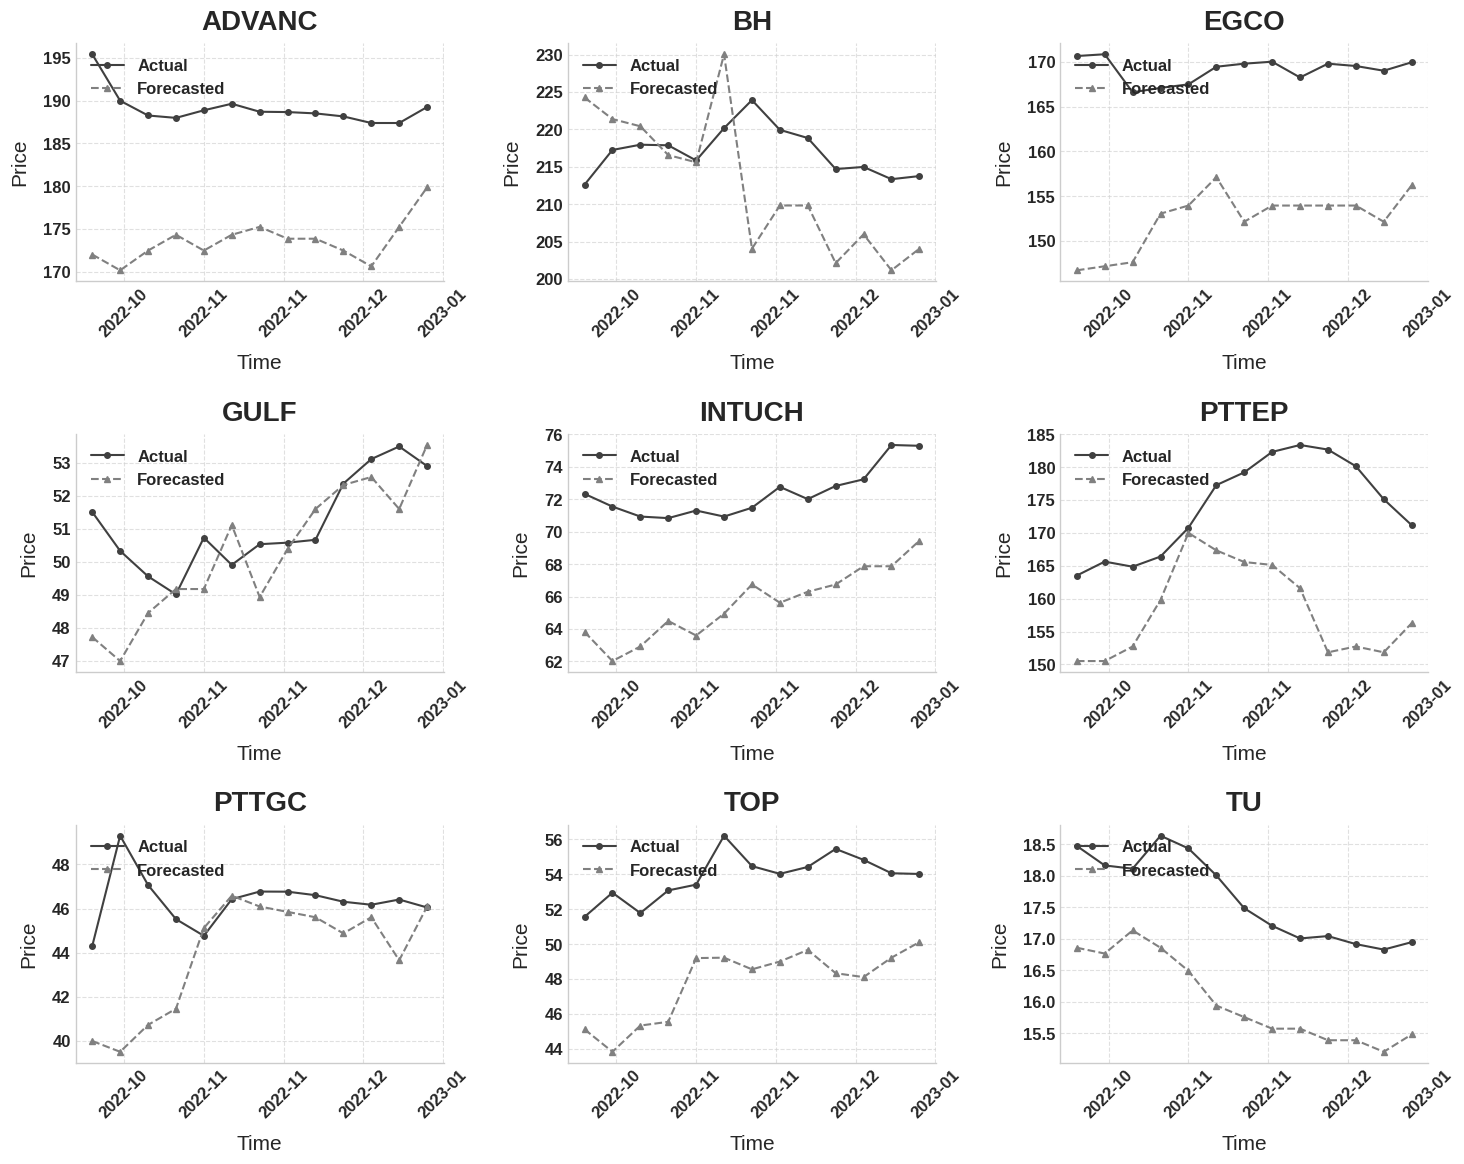

In [ ]:
# Example usage:
fig = plot_actual_vs_forecasted(predicted_prices_rf,test_data)
plt.show()

In [ ]:
# Combine the predicted prices and actual prices
combined_prices_rf = pd.concat([predicted_prices_rf, test_data], axis=1)
combined_prices_rf.columns = [f'Predicted_{col}' if i < len(predicted_prices_rf.columns) else f'Actual_{col}'
                                for i, col in enumerate(combined_prices_rf.columns)]

print("Combined Prices (rf):")
print(combined_prices_rf)

Combined Prices (rf):
           Predicted_ADVANC Predicted_BH Predicted_EGCO Predicted_GULF  \
2022-10-07       195.413595   212.606743     170.672369      51.509875   
2022-10-14       189.986344   217.252006     170.871811      50.332041   
2022-10-21       188.261134   217.954169     166.615532      49.561097   
2022-10-28       187.981097   217.875994     167.109608      49.015987   
2022-11-04       188.868743   215.846941     167.501778      50.732086   
2022-11-11       189.633143   220.168156     169.473271      49.909171   
2022-11-18       188.698331   223.916714     169.816979      50.534946   
2022-11-25       188.660834   219.939726     170.038668      50.581428   
2022-12-02        188.50493     218.8508     168.272524      50.668292   
2022-12-09       188.153506   214.699474     169.816586      52.369545   
2022-12-16       187.383781     214.9843     169.556371      53.111604   
2022-12-23       187.383225   213.347014      169.02808      53.493378   
2022-12-30      

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Initialize dictionaries to store the results for each stock
rmse_dict = {}
mae_dict = {}
mape_dict = {}
r2_dict = {}

# Extract predicted and actual values from combined_prices
predicted_values = combined_prices_rf [[col for col in combined_prices_rf .columns if col.startswith('Predicted')]]
actual_values = combined_prices_rf [[col for col in combined_prices_rf .columns if col.startswith('Actual')]]

# Loop through each stock (column pair of actual and predicted values)
for stock in predicted_values.columns:
    # Extract the actual and predicted values for this stock
    actual_col = stock.replace('Predicted', 'Actual')
    predicted_stock = combined_prices_rf[stock]
    actual_stock = combined_prices_rf [actual_col]

    # Calculate RMSE
    rmse_dict[stock] = np.sqrt(mean_squared_error(actual_stock, predicted_stock))

    # Calculate MAE
    mae_dict[stock] = mean_absolute_error(actual_stock, predicted_stock)

    # Calculate MAPE
    mape_dict[stock] = np.mean(np.abs((actual_stock - predicted_stock) / actual_stock)) * 100

    # Calculate R-squared
    r2_dict[stock] = r2_score(actual_stock, predicted_stock)

# Print the results for each stock
for stock in predicted_values.columns:
    print(f"Metrics for {stock.replace('Predicted_', '')}:")
    print(f"  RMSE: {rmse_dict[stock]}")
    print(f"  MAE: {mae_dict[stock]}")
    print(f"  MAPE: {mape_dict[stock]}%")
    print(f"  R-squared: {r2_dict[stock]}")
    print("\n")

Metrics for ADVANC:
  RMSE: 15.815735465521648
  MAE: 15.469322627075776
  MAPE: 8.932003218886996%
  R-squared: -43.803220591080475


Metrics for BH:
  RMSE: 10.069118366184135
  MAE: 8.625263636415106
  MAPE: 4.110905358061776%
  R-squared: -0.2567650535002559


Metrics for EGCO:
  RMSE: 17.05166823185322
  MAE: 16.685488364635578
  MAPE: 10.995423919015938%
  R-squared: -27.59500919256772


Metrics for GULF:
  RMSE: 1.717091723922245
  MAE: 1.3071099006787485
  MAPE: 2.6613674734139647%
  R-squared: 0.2199224883935541


Metrics for INTUCH:
  RMSE: 6.928435557850877
  MAE: 6.799399904938332
  MAPE: 10.427682840354215%
  R-squared: -9.970242635247308


Metrics for PTTEP:
  RMSE: 17.77127866462778
  MAE: 15.884135698896886
  MAPE: 10.179284324304621%
  R-squared: -5.827672646490442


Metrics for PTTGC:
  RMSE: 3.756911630000661
  MAE: 2.4920772589193283
  MAPE: 6.0405808829944725%
  R-squared: -1.3098224951640085


Metrics for TOP:
  RMSE: 6.2451103122900165
  MAE: 6.0791655130152265
 

In [ ]:
                                          #rf  (download)


predicted_directions_rf.to_csv('predicted_directions_rf.csv')
predicted_prices_rf.to_csv('predicted_prices_rf.csv')
combined_prices_rf.to_csv('combined_prices_rf.csv')


# Convert selected_stocks_rf to a DataFrame before saving to CSV
selected_stocks_rf_df = pd.DataFrame(list(selected_stocks_rf.items()),
                                       columns=['Date', 'Selected Stocks'])
# Applying similar logic for consistency for selected_stocks_rf
selected_stocks_rf_df['Selected Stocks'] = selected_stocks_rf_df['Selected Stocks'].apply(', '.join)

selected_stocks_rf_df.to_csv('selected_stocks_rf.csv', index=False) # Now using the DataFrame

# combined

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data collection block (modified to include OHLCV)
tickers = ['ADVANC.BK', 'BH.BK', 'EGCO.BK', 'GULF.BK', 'INTUCH.BK', 'PTTEP.BK', 'PTTGC.BK', 'TOP.BK', 'TU.BK']
start_date = '2017-12-08'
end_date = '2023-12-30'
data = yf.download(tickers=tickers, start=start_date, end=end_date, interval='1d')[['Open', 'High', 'Low', 'Close', 'Volume']]
data = data.resample('W-FRI').last()  # Weekly data

# Set multi-level column names for easier access
data.columns.names = ['Feature', 'Ticker']
data.index = pd.to_datetime(data.index.date)

# Function to prepare data for LSTM with lagged OHLCV features
def prepare_data_for_lstm(data, look_back):
    scaler_dict = {ticker: MinMaxScaler(feature_range=(0, 1)) for ticker in data.columns.levels[1]}
    X_dict, y_dict = {}, {}

    for ticker in data.columns.levels[1]:
        df = data.xs(ticker, level='Ticker', axis=1)
        scaled_data = scaler_dict[ticker].fit_transform(df)

        X, y = [], []
        for i in range(look_back, len(scaled_data)):
            X.append(scaled_data[i-look_back:i])  # Lagged sequence of OHLCV features
            y.append(scaled_data[i, 3])  # Close price as the target

        X_dict[ticker] = np.array(X)
        y_dict[ticker] = np.array(y)

    return X_dict, y_dict, scaler_dict

# Function to define and compile an LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)  # Output layer for the closing price
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Hybrid model forecasting function
def forecast_stocks_hybrid(data, look_back=60, epochs=10, batch_size=16):
    forecasted_prices = {}
    directions = {}

    # Prepare data
    X_dict, y_dict, scaler_dict = prepare_data_for_lstm(data, look_back)

    for ticker in data.columns.levels[1]:
        # Define LSTM model for each ticker
        X, y = X_dict[ticker], y_dict[ticker]
        model = create_lstm_model((X.shape[1], X.shape[2]))

        # Train LSTM model
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # Prepare the last 'look_back' days for forecasting
        last_data = data.xs(ticker, level='Ticker', axis=1).iloc[-look_back:]
        last_scaled = scaler_dict[ticker].transform(last_data).reshape(1, look_back, -1)

        # Forecast using LSTM
        lstm_forecast_scaled = model.predict(last_scaled)[0, 0]
        lstm_forecast = scaler_dict[ticker].inverse_transform(
            np.array([[0, 0, 0, lstm_forecast_scaled, 0]])  # Placeholder for OHLCV
        )[0][3]

        # Compute residuals between LSTM predictions and actual values
        residuals = y - model.predict(X).flatten()

        # Prepare XGBoost model to learn residuals
        xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
        xgb_model.fit(X.reshape(X.shape[0], -1), residuals)  # Flatten input for XGBoost

        # Forecast using XGBoost on LSTM input
        xgb_forecast = xgb_model.predict(last_scaled.reshape(1, -1))[0]

        # Hybrid forecast: LSTM forecast + XGBoost correction
        hybrid_forecast = lstm_forecast + xgb_forecast

        # Store forecasted price and direction
        forecasted_prices[ticker] = hybrid_forecast
        last_actual_price = data.loc[data.index[-1], ('Close', ticker)]
        direction = 1 if (hybrid_forecast - last_actual_price) / last_actual_price > 0.01 else -1
        directions[ticker] = direction

    return pd.Series(forecasted_prices), pd.Series(directions)

# Initializing variables for the backtesting loop
initial_train_end = '2022-09-30'
full_train_data = data[data.index <= initial_train_end]
test_data = data[(data.index > initial_train_end) & (data.index <= '2022-12-31')]

# DataFrames to store forecasted prices and directions
predicted_prices_hybrid = pd.DataFrame(index=test_data.index, columns=data.columns.levels[1])
predicted_directions_hybrid = pd.DataFrame(index=test_data.index, columns=data.columns.levels[1])

# Loop over each week in the test set
for i in range(len(test_data)):
    test_week = test_data.iloc[i:i+1]
    current_date = test_data.index[i]

    # Forecast prices and directions
    forecasts, directions = forecast_stocks_hybrid(full_train_data)

    # Store forecasted prices and directions
    predicted_prices_hybrid.loc[current_date] = forecasts
    predicted_directions_hybrid.loc[current_date] = directions

    # Add the actual prices of the current test week to the training data (rolling window)
    full_train_data = pd.concat([full_train_data, test_week]).iloc[-365:]  # Using a 1-year rolling window

# Results
print("Hybrid Model Predicted Prices:")
print(predicted_prices_hybrid)
print("Hybrid Model Predicted Directions:")
print(predicted_directions_hybrid)


[*********************100%***********************]  9 of 9 completed


7/7 [==============================] - 0s 15ms/step
Hybrid Model Predicted Prices:
Ticker       ADVANC.BK       BH.BK     EGCO.BK    GULF.BK  INTUCH.BK  \
2022-10-07  189.151246  234.341233  181.950716  49.998829  73.215637   
2022-10-14  194.060542  241.764309  176.642953  49.232027  72.598787   
2022-10-21  187.703713  219.816001  176.580349  52.204987  71.932169   
2022-10-28    192.3831  232.274818  176.873406  53.225338   69.00467   
2022-11-04  186.544956  233.513058  171.575692  51.595413  72.797095   
2022-11-11  191.582332  228.548805  169.111526   52.44391  72.836963   
2022-11-18  190.317879  241.337273  169.036698  51.034331  71.168282   
2022-11-25  188.888171  229.791428  172.805125  48.054984   71.78636   
2022-12-02  187.669906  236.333244  170.926695  51.552561  70.461537   
2022-12-09   187.86267  226.173558  169.983457  49.402171  70.936701   
2022-12-16  186.491358  223.996752  169.731509  53.753758   70.64153   
2022-12-23  188.531362   214.94687  171.455633  53.43

In [ ]:
predicted_directions_hybrid.columns = predicted_directions_hybrid.columns.str.replace('.BK', '', regex=False)


In [ ]:
predicted_directions_hybrid

Ticker     ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2022-10-07     -1   1    1   -1     -1    -1     1   1  -1
2022-10-14      1   1    1   -1      1    -1     1   1  -1
2022-10-21      1  -1    1    1      1    -1     1  -1  -1
2022-10-28      1   1    1    1     -1    -1     1  -1  -1
2022-11-04     -1   1    1    1      1    -1     1  -1  -1
2022-11-11      1   1   -1    1      1    -1    -1  -1   1
2022-11-18     -1  -1   -1   -1     -1    -1    -1  -1   1
2022-11-25     -1   1    1   -1     -1    -1    -1  -1   1
2022-12-02     -1   1   -1   -1     -1    -1    -1  -1   1
2022-12-09     -1   1   -1   -1     -1     1    -1  -1   1
2022-12-16     -1   1   -1   -1     -1     1     1  -1   1
2022-12-23      1  -1   -1   -1     -1     1     1   1  -1
2022-12-30     -1   1    1   -1     -1     1     1  -1   1

In [ ]:
           ADVANC  BH EGCO GULF INTUCH PTTEP PTTGC TOP  TU
2022-10-07     -1  -1   -1   -1      1     1    -1   1  -1
2022-10-14     -1   1    1    1     -1    -1    -1   1  -1
2022-10-21      1   1   -1   -1     -1     1     1  -1  -1
2022-10-28      1  -1    1   -1      1    -1    -1   1  -1
2022-11-04     -1  -1   -1    1      1    -1     1   1  -1
2022-11-11      1   1    1    1     -1    -1     1   1  -1
2022-11-18     -1   1   -1   -1      1     1     1   1  -1
2022-11-25      1   1    1    1      1     1    -1   1  -1
2022-12-02     -1  -1    1   -1     -1    -1     1   1  -1
2022-12-09      1  -1   -1   -1      1     1    -1  -1  -1
2022-12-16     -1   1    1    1      1     1    -1   1  -1
2022-12-23      1   1   -1   -1      1    -1     1   1  -1
2022-12-30      1  -1    1    1     -1     1    -1  -1  -1

In [ ]:
# Combine the predicted prices and actual prices
combined_prices_hybrid = pd.concat([predicted_prices_hybrid, test_data], axis=1)
combined_prices_hybrid.columns = [f'Predicted_{col}' if i < len(predicted_prices_hybrid.columns) else f'Actual_{col}'
                                for i, col in enumerate(combined_prices_hybrid.columns)]

print("Combined Prices (LSTM):")
print(combined_prices_lstm)


Combined Prices (LSTM):
                          Predicted_ADVANC Predicted_BH Predicted_EGCO  \
Date                                                                     
2022-10-07 00:00:00+00:00       180.859267   215.414092     153.140266   
2022-10-14 00:00:00+00:00       159.737567   194.413215     162.903885   
2022-10-21 00:00:00+00:00       147.800099   181.059441     158.677419   
2022-10-28 00:00:00+00:00       141.705063   180.069588     171.923292   
2022-11-04 00:00:00+00:00       143.494327   172.215992     163.671023   
2022-11-11 00:00:00+00:00       147.615198   174.959837      167.39962   
2022-11-18 00:00:00+00:00       147.176796   170.103305     166.959344   
2022-11-25 00:00:00+00:00       148.176932   171.519176     168.160625   
2022-12-02 00:00:00+00:00       146.250123   168.101238     169.098331   
2022-12-09 00:00:00+00:00       150.941716   172.765415       169.2752   
2022-12-16 00:00:00+00:00       151.534698   171.816558     165.744889   
2022-12-23 00:

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_hybrid = predicted_directions_hybrid.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_hybrid = predicted_directions_hybrid.dropna()

# Align both series to have the same length
predicted_directions_hybrid = predicted_directions_hybrid.loc[actual_directions.index]

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure correct data types
actual_directions = actual_directions.astype(int)
predicted_directions_hybrid = predicted_directions_hybrid.astype(int)

# Check for NaN values
actual_directions = actual_directions.dropna()
predicted_directions_hybrid = predicted_directions_hybrid.dropna()

# Align both series to have the same length
predicted_directions_hybrid = predicted_directions_hybrid.loc[actual_directions.index]

# Calculate accuracy for each stock and overall accuracy
all_accuracies_hybrid = []
for stock in actual_directions.columns:
    accuracy = accuracy_score(actual_directions[stock].values, predicted_directions_hybrid[stock].values)
    all_accuracies_hybrid.append(accuracy)
    print(f"hybrid Accuracy for {stock}: {accuracy * 100:.2f}%")

print(f"Overall hybrid Model Accuracy: {np.mean(all_accuracies_lstm) * 100:.2f}%")

# Calculate and print confusion matrix for each stock
for stock in actual_directions.columns:
    conf_matrix = confusion_matrix(actual_directions[stock].values, predicted_directions_hybrid[stock].values)
    print(f"\nLSTM Confusion Matrix for {stock}:")
    print(conf_matrix)


# # Visualize the predictions
# import matplotlib.pyplot as plt

# def plot_predictions(stock):
#     plt.figure(figsize=(12, 6))
#     plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Actual_{stock}'], label='Actual')
#     plt.plot(combined_prices_lstm.index, combined_prices_lstm[f'Predicted_{stock}'], label='LSTM Prediction')
#     plt.title(f'{stock} Stock Price Prediction')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()

# # Plot predictions for each stock
# for stock in test_data.columns:
#     plot_predictions(stock)

hybrid Accuracy for ADVANC: 76.92%
hybrid Accuracy for BH: 61.54%
hybrid Accuracy for EGCO: 84.62%
hybrid Accuracy for GULF: 53.85%
hybrid Accuracy for INTUCH: 38.46%
hybrid Accuracy for PTTEP: 53.85%
hybrid Accuracy for PTTGC: 69.23%
hybrid Accuracy for TOP: 38.46%
hybrid Accuracy for TU: 46.15%
Overall hybrid Model Accuracy: 48.72%

LSTM Confusion Matrix for ADVANC:
[[6 1]
 [2 4]]

LSTM Confusion Matrix for BH:
[[3 5]
 [0 5]]

LSTM Confusion Matrix for EGCO:
[[5 1]
 [1 6]]

LSTM Confusion Matrix for GULF:
[[4 1]
 [5 3]]

LSTM Confusion Matrix for INTUCH:
[[3 2]
 [6 2]]

LSTM Confusion Matrix for PTTEP:
[[5 2]
 [4 2]]

LSTM Confusion Matrix for PTTGC:
[[4 3]
 [1 5]]

LSTM Confusion Matrix for TOP:
[[3 1]
 [7 2]]

LSTM Confusion Matrix for TU:
[[5 6]
 [1 1]]
